### Project Chicago: Transform ResStock UPGRADE Results to 15 SFD prototypes (Elevate Energy)
Created on: 12/15/2020 \
By: Lixi Liu (Lixi.Liu@nrel.gov)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
print(f'Notebook path: {os.getcwd()}')

Notebook path: /Users/lliu2/Documents/GitHub/ResStock/files


### Download results online
* unprocessed upgrade results: S3/resbldg-datasets/chicagoeui
* processed result tables for plots: https://nrel.sharepoint.com/sites/ChicagoRetrofits/Shared%20Documents/Forms/AllItems.aspx?viewid=289cdd1a%2D97c9%2D4bcc%2D8416%2Dc19bf01c6302&id=%2Fsites%2FChicagoRetrofits%2FShared%20Documents%2FGeneral%2FUpgrade%20results

### Initialize
For modifying plots, can go directly to section 2.3 after initialization

In [2]:
# local path to downloaded results
iteration = '02a' # <----- options: '02a', '02b'
iter_path = f'cookcnty_upgrades_{iteration}'
result_dir = '/Users/lliu2/Documents/Chicago retrofits/ResStock results'
result_path = os.path.join(result_dir,iter_path)

## create folder for post-processed results:
if not os.path.exists(os.path.join(result_path, 'processed results')):
    os.mkdir(os.path.join(result_path, 'processed results'))
    
## create folder for exported baseline and upgrade results to csv (to share with Elevate):
combined_res_csv_path = os.path.join(result_path, 'processed results', 'raw combined csvs')
if not os.path.exists(combined_res_csv_path):
    os.mkdir(combined_res_csv_path)
    
## create folder for plots:
plot_path = os.path.join(result_path, 'processed results', 'plots')
if not os.path.exists(plot_path):
    os.mkdir(plot_path)

print(f'Result path: \n   {result_path}')


Result path: 
   /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_02a


### Functions

In [3]:
def get_per_unit_sim_output(df, res):
    """
    res (df): contains 'build_existing_model.units_represented'
    """
    cols = [x for x in df.columns if 
            x.endswith('_kwh') or
            x.endswith('_mbtu') or
            x.endswith('_therm') or
            x.endswith('_cost_usd') or
            x.endswith('_ft_2')
           ]
    df.loc[:, cols] = df.loc[:, cols].replace([None,''],np.nan).divide(
        res['build_existing_model.units_represented'], axis=0)
    
    return df

def get_per_unit_sim_output_limited(df, res):
    """
    To reduce computing time
    res (df): contains 'build_existing_model.units_represented'
    """
    cols = ['simulation_output_report.total_site_natural_gas_therm',
            'simulation_output_report.total_site_electricity_kwh',
            'simulation_output_report.total_site_energy_mbtu',
            'simulation_output_report.upgrade_cost_usd'
           ]
    df.loc[:, cols] = df.loc[:, cols].replace([None,''],np.nan).divide(
        res['build_existing_model.units_represented'], axis=0)
    
    return df

def add_sqft_eui(df):
    global res
    sqft_map = {'0-499': 328,
                '500-749': 633,
                '750-999': 885,
                '1000-1499': 1220,
                '1500-1999': 1690,
                '2000-2499': 2176,
                '2500-2999': 2663,
                '3000-3999': 3301,
                '4000+': 8194}

#     df['sqft'] = res['build_existing_model.geometry_floor_area'].map(sqft_map)
    df['sqft'] = res['simulation_output_report.floor_area_conditioned_ft_2']
    df['gas_eui'] = df['simulation_output_report.total_site_natural_gas_therm'].divide(df['sqft']) # therm/sqft
    df['elec_eui'] = df['simulation_output_report.total_site_electricity_kwh'].divide(df['sqft']) # kwh/sqft
    df['site_eui'] = df['simulation_output_report.total_site_energy_mbtu'].divide(df['sqft'])*1000 # kbtu/sqft
    
    return df

print('func loaded: "add_sqft_eui"')

def get_res_by_prototype(df, slice_by_df, row):
    """
    df: df to slice on
    slice_by_df: df used to do the slicing
    """
    res_group_i = df[slice_by_df['build_existing_model.geometry_stories'].isin(row['Stories'].split(',')) & \
        slice_by_df['build_existing_model.geometry_wall_type'].isin(row['WallType'].split(',')) & \
        slice_by_df['build_existing_model.vintage_acs'].isin(row['Vintage'].split(',')) & \
        slice_by_df['build_existing_model.geometry_building_type_recs'].isin(['Single-Family Detached'])]
    res_group_i = res_group_i[res_group_i['completed_status']=="Success"]
    
    return res_group_i

print('func loaded: "get_res_by_prototype"')

func loaded: "add_sqft_eui"
func loaded: "get_res_by_prototype"


### 1. BASELINE results

In [40]:
save_a_copy_in_csv = True # <-----
res = pd.read_parquet(os.path.join(result_path,'baseline','results_up00.parquet'))

# get sqft, gas/elec/site eui
res = add_sqft_eui(res)

# save a copy at bldg level
if save_a_copy_in_csv:
    res.to_csv(os.path.join(combined_res_csv_path,'results_baseline.csv'), index=False)

# (1) get sim output at the unit level (req for MF)
res = get_per_unit_sim_output(res, res)

# (2) get sqft, gas/elec/site eui - redo to get unit-level results
res = add_sqft_eui(res)

res

building_id  job_id          started_at        completed_at  \
0                1     111 2021-01-16 13:02:15 2021-01-16 13:03:40   
1                2      60 2021-01-16 22:34:09 2021-01-16 22:35:49   
2                3     193 2021-01-16 15:03:37 2021-01-16 15:05:03   
3                4     181 2021-01-16 20:01:20 2021-01-16 20:02:46   
4                5     101 2021-01-16 11:52:51 2021-01-16 11:54:10   
...            ...     ...                 ...                 ...   
37531        37532     141 2021-01-17 00:17:22 2021-01-17 00:24:46   
37532        37533      56 2021-01-16 16:48:17 2021-01-16 17:34:26   
37533        37534     225 2021-01-16 22:38:52 2021-01-16 22:53:23   
37534        37535      35 2021-01-16 08:22:38 2021-01-16 08:33:06   
37535        37536     176 2021-01-16 22:34:43 2021-01-16 23:25:15   

      completed_status apply_upgrade.applicable apply_upgrade.upgrade_name  \
0              Success                     None                       None   
1              Success                     None                       None   
2              Success                     None                       None   
3              Success                     None                       None   
4              Success                     None                       None   
...                ...                      ...                        ...   
37531          Success                     None                       None   
37532          Success                     None                       None   
37533          Success                     None                       None   
37534          Success                     None                       None   
37535          Success                     None                       None   

      apply_upgrade.reference_scenario  \
0                                        
1                                        
2                                        
3                                        
4                                        
...                                ...   
37531                                    
37532                                    
37533                                    
37534                                    
37535                                    

               build_existing_model.ahs_region  \
0      CBSA Chicago-Naperville-Elgin, IL-IN-WI   
1      CBSA Chicago-Naperville-Elgin, IL-IN-WI   
2      CBSA Chicago-Naperville-Elgin, IL-IN-WI   
3      CBSA Chicago-Naperville-Elgin, IL-IN-WI   
4      CBSA Chicago-Naperville-Elgin, IL-IN-WI   
...                                        ...   
37531  CBSA Chicago-Naperville-Elgin, IL-IN-WI   
37532  CBSA Chicago-Naperville-Elgin, IL-IN-WI   
37533  CBSA Chicago-Naperville-Elgin, IL-IN-WI   
37534  CBSA Chicago-Naperville-Elgin, IL-IN-WI   
37535  CBSA Chicago-Naperville-Elgin, IL-IN-WI   

      build_existing_model.applicable  ...  \
0                                True  ...   
1                                True  ...   
2                                True  ...   
3                                True  ...   
4                                True  ...   
...                               ...  ...   
37531                            True  ...   
37532                            True  ...   
37533                            True  ...   
37534                            True  ...   
37535                            True  ...   

      qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour  \
0                                              16.909091                
1                                              14.727273                
2                                              16.272727                
3                                              16.272727                
4                                              16.272727                
...                                                  ...                
37531                                          14.454545   

In [42]:
# assign heating/cooling
cooling_col = 'build_existing_model.hvac_cooling_type'
heating_col = 'build_existing_model.hvac_heating_type_and_fuel'
print('selected')

# if using a national run
if iteration == '_national_2018':
    res = res[res['build_existing_model.ahs_region']=='CBSA Chicago-Naperville-Elgin, IL-IN-WI'].reset_index(drop=True)
    res
    

selected


### 1.1. Check housing charateristics distributions in BASELINE

In [96]:
proto_chars = ['build_existing_model.geometry_stories',
              'build_existing_model.geometry_wall_type',
              'build_existing_model.vintage_acs',
              cooling_col,
              heating_col,
              'build_existing_model.geometry_floor_area'
             ]

Ns = len(res.query('completed_status=="Success"')); N = len(res)
print(f'>>> ResStock - {iter_path} - BASELINE result summary:\n')
print(f'  * {Ns} / {N} samples ran successfully, {N-Ns} failed, efficacy: {Ns/N:.1%} \n')

print('>>> Housing characteristics splits:\n')

Res_char = []
for i, char in enumerate(proto_chars,1):
    Nchar = res.groupby(char)['building_id'].count()
    Nchar = Nchar/Ns
    Nchar['N_failed'] = len(res[res[char].isnull()])
    print(f'  * [{i}] {Nchar}\n')
    
    ## append for export
    Nchar = Nchar.rename('fraction').to_frame()
    Nchar['housing_char'] = Nchar.index.name
    Res_char.append(Nchar)
    
Res_char = pd.concat(Res_char, axis=0)
Res_char.index.name = 'sub_char'
Res_char = Res_char.reset_index()
Res_char = Res_char[['housing_char','sub_char','fraction']]

Res_char.to_csv(os.path.join(result_path, 'baseline', 'baseline_housing_char_breakdown.csv'), index=False)
print(f'>>> file saved to:\n  {os.path.join(result_path, "baseline")}')

>>> ResStock - cookcnty_upgrades_02a - BASELINE result summary:

  * 37512 / 37536 samples ran successfully, 24 failed, efficacy: 99.9% 

>>> Housing characteristics splits:

  * [1] build_existing_model.geometry_stories
1            0.528151
2            0.247254
3            0.224595
N_failed    24.000000
Name: building_id, dtype: float64

  * [2] build_existing_model.geometry_wall_type
Masonry      0.728967
WoodStud     0.271033
N_failed    24.000000
Name: building_id, dtype: float64

  * [3] build_existing_model.vintage_acs
1940-59      0.241523
1960-79      0.255838
1980-99      0.123640
2000-09      0.070351
2010s        0.011490
<1940        0.297158
N_failed    24.000000
Name: building_id, dtype: float64

  * [4] build_existing_model.hvac_cooling_type
Central AC     0.604047
Heat Pump      0.025645
None           0.053903
Room AC        0.316405
N_failed      24.000000
Name: building_id, dtype: float64

  * [5] build_existing_model.hvac_heating_type_and_fuel
Electricity ASHP   

### 1.2. Add additional metrics to Baseline

In [97]:
# (2) aggregate heating and cooling end uses in ResStock results
res['total_gas_heating'] = res['simulation_output_report.natural_gas_central_system_heating_therm'] +\
    res['simulation_output_report.natural_gas_heating_therm']

res['total_elec_heating'] = res['simulation_output_report.electricity_central_system_heating_kwh'] +\
    res['simulation_output_report.electricity_central_system_pumps_heating_kwh'] +\
    res['simulation_output_report.electricity_fans_heating_kwh'] +\
    res['simulation_output_report.electricity_heating_kwh'] +\
    res['simulation_output_report.electricity_pumps_heating_kwh']

res['total_elec_cooling'] = res['simulation_output_report.electricity_central_system_cooling_kwh'] +\
    res['simulation_output_report.electricity_central_system_pumps_cooling_kwh'] +\
    res['simulation_output_report.electricity_cooling_kwh'] +\
    res['simulation_output_report.electricity_fans_cooling_kwh'] +\
    res['simulation_output_report.electricity_pumps_cooling_kwh']

## EE prototype tags
res['vintage_ee'] = '3: post-1978'
res.loc[res['build_existing_model.vintage_acs'].isin(['1940-59','1960-79']),'vintage_ee'] = '2: 1942-1978'
res.loc[res['build_existing_model.vintage_acs']=='<1940','vintage_ee'] = '1: pre-1942'

res['stories'] = '2: 2+ stories'
res.loc[res['build_existing_model.geometry_stories']=='1','stories'] = '1: <2 stories'

print('new cols added to "res"')
res

new cols added to "res"


building_id  job_id          started_at        completed_at  \
0                1     111 2021-01-16 13:02:15 2021-01-16 13:03:40   
1                2      60 2021-01-16 22:34:09 2021-01-16 22:35:49   
2                3     193 2021-01-16 15:03:37 2021-01-16 15:05:03   
3                4     181 2021-01-16 20:01:20 2021-01-16 20:02:46   
4                5     101 2021-01-16 11:52:51 2021-01-16 11:54:10   
...            ...     ...                 ...                 ...   
37531        37532     141 2021-01-17 00:17:22 2021-01-17 00:24:46   
37532        37533      56 2021-01-16 16:48:17 2021-01-16 17:34:26   
37533        37534     225 2021-01-16 22:38:52 2021-01-16 22:53:23   
37534        37535      35 2021-01-16 08:22:38 2021-01-16 08:33:06   
37535        37536     176 2021-01-16 22:34:43 2021-01-16 23:25:15   

      completed_status apply_upgrade.applicable apply_upgrade.upgrade_name  \
0              Success                     None                       None   
1              Success                     None                       None   
2              Success                     None                       None   
3              Success                     None                       None   
4              Success                     None                       None   
...                ...                      ...                        ...   
37531          Success                     None                       None   
37532          Success                     None                       None   
37533          Success                     None                       None   
37534          Success                     None                       None   
37535          Success                     None                       None   

      apply_upgrade.reference_scenario  \
0                                        
1                                        
2                                        
3                                        
4                                        
...                                ...   
37531                                    
37532                                    
37533                                    
37534                                    
37535                                    

               build_existing_model.ahs_region  \
0      CBSA Chicago-Naperville-Elgin, IL-IN-WI   
1      CBSA Chicago-Naperville-Elgin, IL-IN-WI   
2      CBSA Chicago-Naperville-Elgin, IL-IN-WI   
3      CBSA Chicago-Naperville-Elgin, IL-IN-WI   
4      CBSA Chicago-Naperville-Elgin, IL-IN-WI   
...                                        ...   
37531  CBSA Chicago-Naperville-Elgin, IL-IN-WI   
37532  CBSA Chicago-Naperville-Elgin, IL-IN-WI   
37533  CBSA Chicago-Naperville-Elgin, IL-IN-WI   
37534  CBSA Chicago-Naperville-Elgin, IL-IN-WI   
37535  CBSA Chicago-Naperville-Elgin, IL-IN-WI   

      build_existing_model.applicable  ... elec_rate elec_CO2_rate gas_fixed  \
0                                True  ...  0.126207      0.000835     45.32   
1                                True  ...  0.126207      0.000835     45.32   
2                                True  ...  0.126207      0.000835     45.32   
3                                True  ...  0.126207      0.000835     45.32   
4                                True  ...  0.107257      0.000835      0.00   
...                               ...  ...       ...           ...       ...   
37531                            True  ...  0.107257      0.000835     21.51   
37532                            True  ...  0.107257      0.000835     21.51   
37533                            True  ...  0.126207      0.000835     45.32   
37534                            True  ...  0.126207      0.000835      0.00   
37535                            True  ...  0.126207      0.000835     45.32   

      gas_rate gas_CO2_rate total_gas_heating total_elec_heating  \
0      1.84944     0.005322        642.139144           0.000000   
1      1.84944     0.00532

### 1.3. Get BASELINE results by building prototypes from Elevate Energy
#### Note: cannot add prototype tags directly to ResStock results as prototypes overlap in chars

In [98]:
## Load prototype csv
groups = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
print('prototypes loaded')


prototypes loaded


In [99]:
### (1) get count & median consumption
Metric_map1 = {'count': 'completed_status',
           'median gas': 'simulation_output_report.total_site_natural_gas_therm',
           'median elec': 'simulation_output_report.total_site_electricity_kwh'}

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map1.items():
        if metric == 'count':
            groups.loc[i, 'count'] = len(res_group_i)
        else:
            groups.loc[i, metric] = res_group_i[res_var].median()

groups['Gas Diff-med(%)'] = ((groups['Non-normalized gas usage'] - groups['median gas']) / groups['Non-normalized gas usage']) * 100
groups['Elec Diff-med(%)'] = ((groups['Non-normalized elec. usage'] - groups['median elec']) / groups['Non-normalized elec. usage']) * 100
print('>> (1) median consumption computed')


>> (1) median consumption computed


In [100]:
### (2) get mean consumption
Metric_map2 = {'mean gas': 'simulation_output_report.total_site_natural_gas_therm',
           'mean elec': 'simulation_output_report.total_site_electricity_kwh'} # metric: res_var

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = res_group_i[res_var].mean()

groups['Gas Diff-mean(%)'] = ((groups['Non-normalized gas usage'] - groups['mean gas']) / groups['Non-normalized gas usage']) * 100
groups['Elec Diff-mean(%)'] = ((groups['Non-normalized elec. usage'] - groups['mean elec']) / groups['Non-normalized elec. usage']) * 100
print('>> (2) mean consumption computed')


>> (2) mean consumption computed


In [101]:
### (3) get median & mean sqft & eui
Metric_map1 = {'median sqft': 'sqft',
               'median gas eui': 'gas_eui', 
               'median elec eui': 'elec_eui'}
Metric_map2 = {'mean sqft': 'sqft', 
               'mean gas eui': 'gas_eui', 
               'mean elec eui': 'elec_eui'}

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    ### (3.1) get median values
    for metric, res_var in Metric_map1.items():
        groups.loc[i, metric] = res_group_i[res_var].median()

    ### (3.2) get mean values
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = \
            res_group_i[res_var].mean()

print('>> (3) median & mean sqft & eui computed:');

groups.set_index(['HousingGroupNo','HousingGroupName'])[['median sqft', 'mean sqft',
                                                         'median gas','mean gas',
                                                         'median gas eui', 'mean gas eui', 
                                                         'median elec','mean elec', 
                                                         'median elec eui','mean elec eui']]


>> (3) median & mean sqft & eui computed:


median sqft  \
HousingGroupNo HousingGroupName                                     
1              Masonry Post-1978 less than 2 stories       2176.0   
2              Masonry All Years Split Level               1690.0   
3              Masonry Post-1978 2 or more stories         3301.0   
4              Masonry 1942-1978 Less than 2 Stories       1690.0   
5              Masonry 1942-1978 2 or more stories         2176.0   
6              Masonry Pre-1942 less than 2 stories        1220.0   
7              Masonry Pre-1942 2 or more stories          2176.0   
8              Frame Post-1978 Less than 2 stories         2176.0   
9              Frame Post-1978 Split Level                 2176.0   
10             Frame Post-1978 2 or more stories           2663.0   
11             Frame 1942-1978 less than 2 stories         1690.0   
12             Frame Pre-1942 Split Level                  1690.0   
13             Frame 1942-1978 2 or more stories           1690.0   
14             Frame Pre-1942 less than 2 stories          1220.0   
15             Frame Pre-1942 2 or more stories            2176.0   

                                                        mean sqft  \
HousingGroupNo HousingGroupName                                     
1              Masonry Post-1978 less than 2 stories  2394.582482   
2              Masonry All Years Split Level          2000.196867   
3              Masonry Post-1978 2 or more stories    4058.270428   
4              Masonry 1942-1978 Less than 2 Stories  1680.132653   
5              Masonry 1942-1978 2 or more stories    2392.638539   
6              Masonry Pre-1942 less than 2 stories   1460.060606   
7              Masonry Pre-1942 2 or more stories     2552.909881   
8              Frame Post-1978 Less than 2 stories    2243.300336   
9              Frame Post-1978 Split Level            3012.053452   
10             Frame Post-1978 2 or more stories      3622.142477   
11             Frame 1942-1978 less than 2 stories    1690.260624   
12             Frame Pre-1942 Split Level             2020.515977   
13             Frame 1942-1978 2 or more stories      2276.806678   
14             Frame Pre-1942 less than 2 stories     1402.300142   
15             Frame Pre-1942 2 or more stories       2325.502456   

                                                       median gas  \
HousingGroupNo HousingGroupName                                     
1              Masonry Post-1978 less than 2 stories   814.176472   
2              Masonry All Years Split Level          1160.188446   
3              Masonry Post-1978 2 or more stories    1331.608504   
4              Masonry 1942-1978 Less than 2 Stories  1041.965863   
5              Masonry 1942-1978 2 or more stories    1585.851757   
6              Masonry Pre-1942 less than 2 stories   1362.174432   
7              Masonry Pre-1942 2 or more stories     1818.719734   
8              Frame Post-1978 Less than 2 stories     857.015417   
9              Frame Post-1978 Split Level            1098.217867   
10             Frame Post-1978 2 or more stories      1341.786474   
11             Frame 1942-1978 less than 2 stories    1106.606380   
12             Frame Pre-1942 Split Level             1797.643113   
13             Frame 1942-1978 2 or more stories      1690.251095   
14             Frame Pre-1942 less than 2 stories     1417.258296   
15             Frame Pre-1942 2 or more stories       1965.872773   

                                                         mean gas  \
HousingGroupNo HousingGroupName                                     
1              Masonry Post-1978 less than 2 stories   896.130657   
2              Masonry All Years Split Level          1286.125679   
3              Masonry Post-1978 2 or more stories    1366.550260   
4              Masonry 1942-1978 Less than 2 Stories  1136.678048   
5              Masonry 1942-1978 2 or more stories    1670.642890   
6              Masonry Pre-1942 less than 2 stori

In [102]:
### (4) optional - get heating and cooling end uses to "groups"
Metric_map1 = ['frac_gas_heating', 'frac_elec_heating', 'frac_elec_cooling']
Metric_map2 = {'size_heating_kbut_h': 'simulation_output_report.size_heating_system_kbtu_h',
               'size_cooling_kbut_h': 'simulation_output_report.size_cooling_system_kbtu_h'}


for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row)
    
    ### (4.1) get fractions
    groups.loc[i, 'frac_gas_heating'] = res_group_i['total_gas_heating'].mean() / \
        res_group_i['simulation_output_report.total_site_natural_gas_therm'].mean()

    groups.loc[i, 'frac_elec_heating'] = res_group_i['total_elec_heating'].mean() / \
        res_group_i['simulation_output_report.total_site_electricity_kwh'].mean()
    
    groups.loc[i, 'frac_elec_cooling'] = res_group_i['total_elec_cooling'].mean() / \
        res_group_i['simulation_output_report.total_site_electricity_kwh'].mean()
    
    ### (4.2) get mean values
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = res_group_i[res_var].mean()

print('(4) heating and cooling end uses computed')

(4) heating and cooling end uses computed


In [103]:
### (5) optional - get heating & cooling and floor area char breakdowns
House = []
House_chars = [cooling_col, heating_col,
              #'build_existing_model.geometry_floor_area',
              'build_existing_model.insulation_unfinished_attic']

for i, row in groups.iterrows():
    
    res_group_i = get_res_by_prototype(res, res, row)
    
    Ns = len(res_group_i)
    Hi = []
    for char in House_chars:
        Nchar = res_group_i.groupby(char)['building_id'].count()/Ns # fractions
        Nchar = Nchar.rename('fraction').to_frame()
        Nchar['housing_char'] = Nchar.index.name
        Hi.append(Nchar)
    
    Hi = pd.concat(Hi, axis=0)
    Hi.index.name = 'sub_char'
    Hi = Hi.reset_index()
    Hi['HousingGroupNo'] = row['HousingGroupNo']
    
    House.append(Hi)
    
House = pd.concat(House, axis=0)
House = pd.pivot_table(House, values='fraction', index=['HousingGroupNo'],
                    columns=['housing_char','sub_char'], aggfunc=np.sum)

print('(5) heating & cooling and floor area char breakdowns computed')

(5) heating & cooling and floor area char breakdowns computed


In [104]:
### Combine "groups" + "House" into "Out" for export
out = groups.drop(['Stories','WallType','Vintage'], axis=1)
out = pd.concat([out.set_index('HousingGroupNo')], axis=1, keys=['none']).join(House)

out

none                     \
                                     HousingGroupName Chicago Prevalence   
HousingGroupNo                                                             
1               Masonry Post-1978 less than 2 stories           0.009009   
2                       Masonry All Years Split Level           0.012012   
3                 Masonry Post-1978 2 or more stories           0.044044   
4               Masonry 1942-1978 Less than 2 Stories           0.235235   
5                 Masonry 1942-1978 2 or more stories           0.072072   
6                Masonry Pre-1942 less than 2 stories           0.160160   
7                  Masonry Pre-1942 2 or more stories           0.041041   
8                 Frame Post-1978 Less than 2 stories           0.001001   
9                         Frame Post-1978 Split Level           0.004004   
10                  Frame Post-1978 2 or more stories           0.025025   
11                Frame 1942-1978 less than 2 stories           0.082082   
12                         Frame Pre-1942 Split Level           0.014014   
13                  Frame 1942-1978 2 or more stories           0.023023   
14                 Frame Pre-1942 less than 2 stories           0.218218   
15                   Frame Pre-1942 2 or more stories           0.059059   

                                                              \
               Cook Cnty Prevalence Non-normalized gas usage   
HousingGroupNo                                                 
1                          0.012987                     1133   
2                          0.019980                     1416   
3                          0.032967                     1812   
4                          0.191808                     1210   
5                          0.045954                     1427   
6                          0.073926                     1504   
7                          0.021978                     2044   
8                          0.015984                     1054   
9                          0.021978                     1168   
10                         0.087912                     1422   
11                         0.183816                     1176   
12                         0.064935                     1297   
13                         0.066933                     1530   
14                         0.109890                     1340   
15                         0.048951                     1753   

                                                                              \
               Non-normalized elec. usage   count   median gas   median elec   
HousingGroupNo                                                                 
1                                   10282   685.0   814.176472   8455.592702   
2                                    9661  9128.0  1160.188446   8691.571343   
3                                   18225   514.0  1331.608504  11165.891658   
4                                    8779  5488.0  1041.965863   8219.999688   
5                                   10549   794.0  1585.851757   9836.595137   
6                                    9299   726.0  1362.174432   8385.192118   
7                                   13272   921.0  1818.719734  10400.016131   
8                                    9353   596.0   857.015417   8409.295904   
9                                   10445  1347.0  1098.217867   9431.754031   
10                                  13495   751.0  1341.786474  10584.482546   
11                                   9213  3012.0  1106.606380   8094.493818   
12                                   9964  2128.0  1797.643113   9418.223428   
13                                  12543  1138.0  1690.251095   9622.460944   
14                                   9103   703.0  1417.258296   8167.086506   
15                                  11967  1425.0  1965.872773  10003.147123   

                                                 ...  \
               Gas Diff-med(%)

In [105]:
### export BASELINE prototype summary
out.to_csv(os.path.join(result_path, 'baseline', 'baseline_prototype_results.csv'), index=True)
print(f'BASELINE prototype summary saved to:\n  {os.path.join(result_path, "baseline")}')


BASELINE prototype summary saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_02a/baseline


## 2. UPGRADE results ###

In [109]:
### upgrade result processing funcs
def assign_utility_rates_to_upgrade(p, res, HVAC_upgrades_rate_change):    
    ## assign rates
    p['gas_rate'] = res['gas_rate']
    p['gas_fixed'] = res['gas_fixed']
    p['gas_CO2_rate'] = res['gas_CO2_rate']
    p['elec_rate'] = res['elec_rate']
    p['elec_fixed'] = res['elec_fixed']
    p['elec_CO2_rate'] = res['elec_CO2_rate']
    if n in HVAC_upgrades_rate_change.keys():
        new_rates = HVAC_upgrades_rate_change[n]
        p.loc[(p[p['simulation_output_report.applicable']==True]).index, 'gas_rate'] = new_rates[0]
        p.loc[(p[p['simulation_output_report.applicable']==True]).index, 'gas_fixed'] = new_rates[1]
        p.loc[(p[p['simulation_output_report.applicable']==True]).index, 'elec_rate'] = new_rates[2]
        p.loc[(p[p['simulation_output_report.applicable']==True]).index, 'elec_fixed'] = new_rates[3]
    # assign 0 rates to building with no energy use  
    p.loc[p['simulation_output_report.total_site_natural_gas_therm']==0, 'gas_fixed'] = 0 
    p.loc[p['simulation_output_report.total_site_natural_gas_therm']==0, 'gas_rate'] = 0 
    p.loc[p['simulation_output_report.total_site_electricity_kwh']==0, 'elec_fixed'] = 0 
    p.loc[p['simulation_output_report.total_site_electricity_kwh']==0, 'elec_rate'] = 0 
    
    return p

def combine_upgrade_cost_and_lifetime(p):
    
    ## upgrade costs (sum)
    p['upgrade_cost'] = p['simulation_output_report.upgrade_cost_usd']
    cost_cols = list(x for x in p.columns if x.endswith('cost_usd'))
    p = p.drop(cost_cols, axis=1)
    
    ## upgrade lifetime (max)
    lt_cols = list(x for x in p.columns if x.endswith('lifetime_yrs'))
    p['upgrade_lifetime'] = p[lt_cols].max(axis=1)
    p = p.drop(lt_cols, axis=1)

    p['upgrade_cost'] = p['upgrade_cost'].replace([0, None,''],np.nan)
    p['upgrade_lifetime'] = p['upgrade_lifetime'].replace([0, None,''],np.nan)
    
    return p

def get_annual_gas_elec_site_energy_saving(p, ref, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """
    p['ann_therm_gas_saving'] = ref['simulation_output_report.total_site_natural_gas_therm']-\
         p['simulation_output_report.total_site_natural_gas_therm']
    p['ann_kwh_elec_saving'] = ref['simulation_output_report.total_site_electricity_kwh']-\
         p['simulation_output_report.total_site_electricity_kwh']
    p['ann_mbtu_site_energy_saving'] = ref['simulation_output_report.total_site_energy_mbtu']-\
        p['simulation_output_report.total_site_energy_mbtu']
    
    if get_col_only:
        return p[['ann_therm_gas_saving','ann_kwh_elec_saving','ann_mbtu_site_energy_saving']]
    else:
        return p

def get_annual_energy_cost_saving(p, ref, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """
    p['ann_gas_cost_saving'] = \
        ref['simulation_output_report.total_site_natural_gas_therm']*ref['gas_rate']+ref['gas_fixed']-\
         (p['simulation_output_report.total_site_natural_gas_therm']*p['gas_rate']+p['gas_fixed'])
    p['ann_elec_cost_saving'] = \
        ref['simulation_output_report.total_site_electricity_kwh']*ref['elec_rate']+ref['elec_fixed']-\
         (p['simulation_output_report.total_site_electricity_kwh']*p['elec_rate']+p['elec_fixed'])
    
    p['ann_energy_cost_saving'] = p['ann_gas_cost_saving']+p['ann_elec_cost_saving'] #p[['ann_gas_cost_saving','ann_elec_cost_saving']].sum(axis=1)
    
    if get_col_only:
        return p['ann_energy_cost_saving']
    else:
        return p

def get_annual_metric_ton_co2e_saving(p, ref, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """
    p['ann_metric_ton_co2e_saving'] = \
        (ref['simulation_output_report.total_site_natural_gas_therm']-\
         p['simulation_output_report.total_site_natural_gas_therm'])*p['gas_CO2_rate'] +\
        (ref['simulation_output_report.total_site_electricity_kwh']-\
         p['simulation_output_report.total_site_electricity_kwh'])*p['elec_CO2_rate']
    
    if get_col_only:
        return p['ann_metric_ton_co2e_saving']
    else:
        return p

def print_metrics_report(p):
    ### (1) check for simple_payback > 100 yr or if < 0 yr
    spb_100 = p[p['simple_payback']>100]
    if len(spb_100)>0:
        print(f'    *PAYBACK1 - too large* upgrade={n} has {len(spb_100)} simple_payback>100 ' +\
              f'(including {len(p[p["simple_payback"]==np.inf])} INF)')
    spb_neg = p[p['simple_payback']<0]
    if len(spb_neg)>0:
        print(f'    *PAYBACK1 - negative*  upgrade={n} has {len(spb_neg)} simple_payback<0 ' +\
              '(due to negative energy cost saving)')

    ### (2) check for comparative_payback > 100 yr or if < 0 yr
    spb_100 = p[p['comparative_payback']>100]
    if len(spb_100)>0:
        print(f'    *PAYBACK2 - too large* upgrade={n} has {len(spb_100)} comparative_payback>100 ' +\
              f'(including {len(p[p["comparative_payback"]==np.inf])} INF)')
    spb_neg = p[p['comparative_payback']<0]
    if len(spb_neg)>0:
        print(f'    *PAYBACK2 - negative*  upgrade={n} has {len(spb_neg)} comparative_payback<0 ' +\
              '(due to negative energy cost saving)')

    ### (3) check for eui==inf
    for eui in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
        eui_inf = p[p[eui]==np.inf]
        if len(eui_inf)>0:
            print(f'       *EUI - inf* upgrade={n} has {len(eui_inf)} {eui}=INF ' +\
                  '(due to fuel introduction from upgrade)')

    ### (4) check for neg carbon savings
    ces_neg = p[p['ann_metric_ton_co2e_saving']<0]
    if len(ces_neg)>0:
        print(f'    *CARBON - negative*  upgrade={n} has {len(ces_neg)} carbon saving<0 ')
        
print('funcs loaded')

funcs loaded


In [162]:
### set utility rates ###
NG_rate_multiplier = 1 # <-----

if NG_rate_multiplier > 1:
    fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
else:
    fn_ext = ''

### utility rates ###########################################
# ref (EIA): 
# avg ComEd res elec rate 2019: $ 0.1330 /kWh
# weighted avg IL gas rate 2019: $ 0.77183 /therm

## electricity ##
# annual fixed rates = monthly x 12
EH_fixed = 15.70 * 12 # annual
NEH_fixed = 14.28 *12 # annual
# avg of summer rates (J,J,A,S) and non-summer rates
EH_rate = (0.10273*4+0.10952*8)/12 # 0.08019, $/kWh, electric rate for electric heating customers
NEH_rate = (0.12168*4+0.12847*8)/12 # 0.09889, $/kWh, electric rate for non-electric heating customers
# marginal carbon emission factor:
elec_CO2_rate = 0.000834702 # metric tons of CO2e/kWh

## gas ##
# annual fixed rates = monthly x 12
GH_fixed = 45.32 
NGH_fixed = 21.51 
# variable rates
GH_rate = 0.61648 * NG_rate_multiplier # 0.19477, $/therm, gas rate for NG heating customers
NGH_rate = 0.56758 * NG_rate_multiplier # 0.14964, $/therm, gas rate for non-NG heating customers
# marginal carbon emission factor:
gas_CO2_rate = 0.00532181 # metric tons of CO2e/therm


### upgrades that will cause utility rate change: ###########################################
HVAC_upgrades_rate_change = {
    27: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # SEER 15 ASHP
    28: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # SEER 22 ASHP
    31: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Room AC to Heat Pump
    32: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Shared Cooling to MSHP
    33: [GH_rate, GH_fixed,  NEH_rate, NEH_fixed], # EnergyStar 96% AFUE Natural Gas Furnace
    34: [GH_rate, GH_fixed,  NEH_rate, NEH_fixed], # EnergyStar Natural Gas Boiler
    36: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Electric Furnace to Heat Pump, High Eff
    37: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Electric Furnace to Heat Pump, Min Eff
    39: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Non-ducted Electric to MSHP
    40: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Non-ducted Non-electric to MSHP
    41: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Non-electric Furnace to Heat Pump, High Eff
    42: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Non-electric Furnace to Heat Pump, Min Eff
    43: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Shared Heating to MSHP
}

# assign rates accordingly
Elec_heating_types = ['Electricity Baseboard','Electricity ASHP','Electricity Electric Furnace',
                      'Electricity Electric Boiler', 'Electricity Electric Wall Furnace']
NG_heating_types = ['Natural Gas Fuel Wall/Floor Furnace', 'Natural Gas Fuel Furnace',
                    'Natural Gas Fuel Boiler']

res['elec_fixed'] = NEH_fixed
res['elec_rate'] = NEH_rate
res['elec_CO2_rate'] = elec_CO2_rate
res['gas_fixed'] = NGH_fixed
res['gas_rate'] = NGH_rate
res['gas_CO2_rate'] = gas_CO2_rate

res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(Elec_heating_types)]).index,
        'elec_fixed'] = EH_fixed
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(Elec_heating_types)]).index,
        'elec_rate'] = EH_rate
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(NG_heating_types)]).index,
       'gas_fixed'] = GH_fixed
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(NG_heating_types)]).index,
       'gas_rate'] = GH_rate
# assign 0 rates to building with no energy use 
res.loc[res['simulation_output_report.total_site_electricity_kwh']==0, 'elec_fixed'] = 0 
res.loc[res['simulation_output_report.total_site_electricity_kwh']==0, 'elec_rate'] = 0 
res.loc[res['simulation_output_report.total_site_natural_gas_therm']==0, 'gas_fixed'] = 0 
res.loc[res['simulation_output_report.total_site_natural_gas_therm']==0, 'gas_rate'] = 0 

print(f'Natural gas rate multiplier: {NG_rate_multiplier}')


Natural gas rate multiplier: 1


In [8]:
## make dictionary of upgrades paths, for mapping reference scenarios ##

res_partitions = ['02a','02b'] # <------
print(f'>>> {iter_path[:-1]} has {len(res_partitions)} partitions')
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')

## get summary table
upgrades_path_df = []

ni = 1
for part in res_partitions:
    iteration_path = f'cookcnty_upgrades_{part}'
    res_path = os.path.join(result_dir,iteration_path)

    #### count upgrades
    N_upgrades = 0

    for _, dirnames, _ in os.walk(os.path.join(res_path,'upgrades')):
        N_upgrades += len(dirnames)

    print(f'\n >> {iteration_path} has {N_upgrades:,} upgrades')
    
    for n in range(1, N_upgrades+1):
        p = pd.read_parquet(os.path.join(res_path,'upgrades',
                                         f'upgrade={n}/results_up{str(n).zfill(2)}.parquet'))
        
        upgrade_name = p['apply_upgrade.upgrade_name'].unique()[0]
        # upgrade name correction
        if upgrade_name == 'Plug Loads 25% Reduction':
            upgrade_name = 'Plug Loads 50% Reduction'
            
        ### add to summary table
        summ = pd.DataFrame()
        if not upgrade_name.startswith('Reference') and upgrade_name!='EnergyStar Refrigerator':
            summ.loc[0,'upgrade_no'] = ni
        else:
            summ.loc[0,'upgrade_no'] = np.nan
        summ.loc[0,'upgrade_name'] = upgrade_name
        summ.loc[0,'partition'] = part
        summ.loc[0,'partition_upgrade_no'] = n
        upgrades_path_df.append(summ)
        
        if not upgrade_name.startswith('Reference') and upgrade_name!='EnergyStar Refrigerator':
            ni += 1
        
upgrades_path_df = pd.concat(upgrades_path_df, axis=0).reset_index(drop=True).set_index(['upgrade_name'])
upgrades_path_df


>>> cookcnty_upgrades_02 has 2 partitions

 >> cookcnty_upgrades_02a has 43 upgrades

 >> cookcnty_upgrades_02b has 36 upgrades


upgrade_no partition  \
upgrade_name                                                               
Air Leakage 25% Reduction, with Mech Vent under...         1.0       02a   
Air Leakage to 1ACH50, with Mech Vent                      2.0       02a   
Attic Insulation, R-49                                     3.0       02a   
Attic Insulation, R-60                                     4.0       02a   
Finished Roof, R-49                                        5.0       02a   
...                                                        ...       ...   
EnergyStar Dishwasher, Most Eff                           58.0       02b   
Plug Loads 50% Reduction                                  59.0       02b   
Rooftop Solar, 4 kW                                       60.0       02b   
Reference Thermostat                                       NaN       02b   
Smart Thermostat                                          61.0       02b   

                                                    partition_upgrade_no  
upgrade_name                                                              
Air Leakage 25% Reduction, with Mech Vent under...                   1.0  
Air Leakage to 1ACH50, with Mech Vent                                2.0  
Attic Insulation, R-49                                               3.0  
Attic Insulation, R-60                                               4.0  
Finished Roof, R-49                                                  5.0  
...                                                                  ...  
EnergyStar Dishwasher, Most Eff                                     32.0  
Plug Loads 50% Reduction                                            33.0  
Rooftop Solar, 4 kW                                                 34.0  
Reference Thermostat                                                35.0  
Smart Thermostat                                                    36.0  

[79 rows x 3 columns]

### 2.1. Get UPGRADE summary

### diagnosis

In [ ]:
part = '02b' # <-----

iteration_path = f'cookcnty_upgrades_{part}'
res_path = os.path.join(result_dir,iteration_path)

#### count upgrades
N_upgrades = 5
n = 29

p = pd.read_parquet(os.path.join(res_path,'upgrades',
                                 f'upgrade={n}/results_up{str(n).zfill(2)}.parquet'))
print(f'\nUpgrade {ni} ({part}.{n})')

### get sim output at unit level
p = get_per_unit_sim_output_limited(p, res)

### assign utility rates
p = assign_utility_rates_to_upgrade(p, res, HVAC_upgrades_rate_change)

### collapse upgrade cost and lifetime cols
p = combine_upgrade_cost_and_lifetime(p)

### check if upgrade has 0 successful sims
if len(p[p['completed_status']=='Success']) == 0:
    print(f' * upgrade={n} has 0 successful simulations')

### calculate metrics
p = add_sqft_eui(p)
for var in ['gas_eui','elec_eui','site_eui']:
    p[f'pct_delta_{var}'] = ((p[var]-res[var])/res[var]*100)

# annual kBtu saved per upgrade cost:
p['ann_kbtu_saved_per_dollar'] = p['simulation_output_report.total_site_energy_mbtu'].divide(
                        p['upgrade_cost'], axis=0)*1000 

# annual energy cost saving:
p = get_annual_energy_cost_saving(p, res)

# simple payback
p['simple_payback'] = p['upgrade_cost']/p['ann_energy_cost_saving']

# comparative payback ###
p['comparative_payback'] = np.nan
ref_name = p['apply_upgrade.reference_scenario'].unique()[0]
if ref_name != '':
    print(f'  - has ref scenario: {ref_name}')
    ref_info = upgrades_path_df.loc[ref_name]

    # load ref scenario:
    iterpath = f'cookcnty_upgrades_{ref_info["partition"]}'
    n_ref = int(ref_info['partition_upgrade_no'])

    ref_path = os.path.join(result_dir,iterpath)
    refp = pd.read_parquet(os.path.join(ref_path,'upgrades',
                                 f'upgrade={n_ref}/results_up{str(n_ref).zfill(2)}.parquet'))

    # get sim output at unit level
    refp = get_per_unit_sim_output_limited(refp, res)

    # assign utility rates
    refp = assign_utility_rates_to_upgrade(refp, res, HVAC_upgrades_rate_change)

    # collapse upgrade cost and lifetime cols
    refp = combine_upgrade_cost_and_lifetime(refp)

    # annual energy cost saving:
    ann_energy_cost_saving_ref = get_annual_energy_cost_saving(p.copy(), refp, get_col_only=True)

    # update comparative payback
    p['comparative_payback'] = (p['upgrade_cost']-refp['upgrade_cost'])/ann_energy_cost_saving_ref

# annual metric ton carbon emission savings:
p = get_annual_metric_ton_co2e_saving(p, res)

### check for neg/large paybacks, inf eui, neg carbon savings 
print_metrics_report(p)

### subset to only those that have been applied with the upgrades successfully:
p = p[p['apply_upgrade.applicable']==True].reset_index(drop=True)
upgrade_name = p['apply_upgrade.upgrade_name'].unique()[0]

if round(p['ann_energy_cost_saving'].mean(),2) == np.nan: # <----x
    print(round(p['ann_energy_cost_saving'].mean(),2))

# upgrade name correction
if upgrade_name == 'Plug Loads 25% Reduction':
    upgrade_name = 'Plug Loads 50% Reduction'

if not upgrade_name.startswith('Reference') and upgrade_name!='EnergyStar Refrigerator':
    upgrade_no = ni
else:
    upgrade_no = np.nan
p['upgrade_no'] = upgrade_no


for eui in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
    p[eui] = p[eui].replace([np.inf, -np.inf], np.nan) # for mean calc
    
p

In [163]:
res_partitions = ['02a','02b'] # <------

export_all_upgrades_to_csv = False # <------

print(f'>>> {iter_path[:-1]} has {len(res_partitions)} partitions')
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
if export_all_upgrades_to_csv:
    print(f'    Exporting upgrades results to {combined_res_csv_path}\n')

## get summary table
summary_upgrades = []

ni = 1
for part in res_partitions:
    iteration_path = f'cookcnty_upgrades_{part}'
    res_path = os.path.join(result_dir,iteration_path)

    #### count upgrades
    N_upgrades = 0

    for _, dirnames, _ in os.walk(os.path.join(res_path,'upgrades')):
        N_upgrades += len(dirnames)

    print(f'\n >> {iteration_path} has {N_upgrades:,} upgrades')
    
    for n in range(1, N_upgrades+1):
        p = pd.read_parquet(os.path.join(res_path,'upgrades',
                                         f'upgrade={n}/results_up{str(n).zfill(2)}.parquet'))
        print(f'\nUpgrade {ni} ({part}.{n})')
        
        ### get sim output at unit level
        p = get_per_unit_sim_output_limited(p, res)
        
        ### assign utility rates
        p = assign_utility_rates_to_upgrade(p, res, HVAC_upgrades_rate_change)

        ### collapse upgrade cost and lifetime cols
        p = combine_upgrade_cost_and_lifetime(p)
        
        ### check if upgrade has 0 successful sims
        if len(p[p['completed_status']=='Success']) == 0:
            print(f' * upgrade={n} has 0 successful simulations')

        ### calculate metrics
        p = add_sqft_eui(p)
        for var in ['gas_eui','elec_eui','site_eui']:
            p[f'pct_delta_{var}'] = ((p[var]-res[var])/res[var]*100)

        # annual kBtu saved per upgrade cost:
        p['ann_kbtu_saved_per_dollar'] = p['simulation_output_report.total_site_energy_mbtu'].divide(
                                p['upgrade_cost'], axis=0)*1000 

        # annual energy cost saving:
        p = get_annual_energy_cost_saving(p, res)
        
        # simple payback
        p['simple_payback'] = p['upgrade_cost']/p['ann_energy_cost_saving']
        
        # comparative payback ###
        p['comparative_payback'] = np.nan
        ref_name = p['apply_upgrade.reference_scenario'].unique()[0]
        if ref_name != '':
            print(f'  - has ref scenario: {ref_name}')
            ref_info = upgrades_path_df.loc[ref_name]
            
            # load ref scenario:
            iterpath = f'cookcnty_upgrades_{ref_info["partition"]}'
            n_ref = int(ref_info['partition_upgrade_no'])
            
            ref_path = os.path.join(result_dir,iterpath)
            refp = pd.read_parquet(os.path.join(ref_path,'upgrades',
                                         f'upgrade={n_ref}/results_up{str(n_ref).zfill(2)}.parquet'))
            
            # get sim output at unit level
            refp = get_per_unit_sim_output_limited(refp, res)
        
            # assign utility rates
            refp = assign_utility_rates_to_upgrade(refp, res, HVAC_upgrades_rate_change)
            
            # collapse upgrade cost and lifetime cols
            refp = combine_upgrade_cost_and_lifetime(refp)
            
            # annual energy cost saving:
            ann_energy_cost_saving_ref = get_annual_energy_cost_saving(p.copy(), refp, get_col_only=True)
            
            # update comparative payback
            p['comparative_payback'] = (p['upgrade_cost']-refp['upgrade_cost'])/ann_energy_cost_saving_ref

        # annual metric ton carbon emission savings:
        p = get_annual_metric_ton_co2e_saving(p, res)
        
        ### check for neg/large paybacks, inf eui, neg carbon savings 
        print_metrics_report(p)

        ### subset to only those that have been applied with the upgrades successfully:
        p = p[p['apply_upgrade.applicable']==True].reset_index(drop=True)
        upgrade_name = p['apply_upgrade.upgrade_name'].unique()[0]
        
        if round(p['ann_energy_cost_saving'].mean(),2) == np.nan: # <----x
            print(round(p['ann_energy_cost_saving'].mean(),2))
        
        # upgrade name correction
        if upgrade_name == 'Plug Loads 25% Reduction':
            upgrade_name = 'Plug Loads 50% Reduction'
            
        if not upgrade_name.startswith('Reference') and upgrade_name!='EnergyStar Refrigerator':
            upgrade_no = ni
        else:
            upgrade_no = np.nan
        p['upgrade_no'] = upgrade_no

        ### export upgrade results to csv 
        if export_all_upgrades_to_csv:
            p.to_csv(os.path.join(combined_res_csv_path, f'results_up{nf}.csv'), index=False)

        for eui in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
            p[eui] = p[eui].replace([np.inf, -np.inf], np.nan) # for mean calc

        ### add to summary table
        summ = pd.DataFrame()
        summ.loc[0,'upgrade_no'] = upgrade_no
        summ.loc[0,'upgrade_name'] = upgrade_name
        summ.loc[0,'n_applied'] = len(p)
        summ.loc[0,'n_success'] = len(p[p['completed_status']=='Success'])
        summ.loc[0,'n_fail'] = len(p[p['completed_status']=='Fail'])
        summ['pct_success'] = round(summ['n_success']/summ['n_applied']*100,1)

        p = p[p['completed_status']=='Success'].reset_index(drop=True)
        summ['mean_pct_delta_gas_eui'] = round(p['pct_delta_gas_eui'].mean(), 3)
        summ['mean_pct_delta_elec_eui'] = round(p['pct_delta_elec_eui'].mean(), 3)
        summ['mean_pct_delta_site_eui'] = round(p['pct_delta_site_eui'].mean(), 3)
        summ['mean_upgrade_cost'] = round(p['upgrade_cost'].mean(),2)
        summ['mean_ann_kbtu_saved_per_dollar'] = p['ann_kbtu_saved_per_dollar'].mean() # annual kBtu saved per upgrade cost
        summ['mean_ann_energy_cost_saving'] = round(p['ann_energy_cost_saving'].mean(),2)
        summ['median_simple_payback'] = p['simple_payback'].median()
        summ['median_comparative_payback'] = p['comparative_payback'].median()
        summ['mean_ann_metric_ton_co2e_saving'] = p['ann_metric_ton_co2e_saving'].mean()

        summary_upgrades.append(summ)
        if not upgrade_name.startswith('Reference') and upgrade_name!='EnergyStar Refrigerator':
            ni += 1
    
summary_upgrades = pd.concat(summary_upgrades).reset_index(drop=True)
summary_upgrades


>>> cookcnty_upgrades_02 has 2 partitions
Natural gas rate multiplier: 1

 >> cookcnty_upgrades_02a has 43 upgrades

Upgrade 1 (02a.1)
    *PAYBACK - too large* upgrade=1 has 1181 simple_payback>100 (including 7 INF)
    *PAYBACK - negative*  upgrade=1 has 2448 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=1 has 2334 carbon saving<0 

Upgrade 2 (02a.2)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=2 has 2998 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=2 has 3035 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=2 has 2861 carbon saving<0 

Upgrade 3 (02a.3)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=3 has 562 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=3 has 4 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=3 has 4 carbon saving<0 

Upgrade 4 (02a.4)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=4 has 2110 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=4 has 6 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=4 has 6 carbon saving<0 

Upgrade 5 (02a.5)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *CARBON - negative*  upgrade=5 has 32 carbon saving<0 

Upgrade 6 (02a.6)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=6 has 7710 simple_payback>100 (including 44 INF)
    *PAYBACK - negative*  upgrade=6 has 5009 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=6 has 5084 carbon saving<0 

Upgrade 7 (02a.7)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=7 has 2249 simple_payback>100 (including 7 INF)
    *PAYBACK - negative*  upgrade=7 has 79 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=7 has 73 carbon saving<0 

Upgrade 8 (02a.8)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=8 has 26252 simple_payback>100 (including 7 INF)
    *PAYBACK - negative*  upgrade=8 has 404 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=8 has 377 carbon saving<0 

Upgrade 9 (02a.9)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=9 has 26126 simple_payback>100 (including 7 INF)
    *PAYBACK - negative*  upgrade=9 has 120 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=9 has 119 carbon saving<0 

Upgrade 10 (02a.10)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=10 has 23977 simple_payback>100 (including 4479 INF)
    *PAYBACK - negative*  upgrade=10 has 13535 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=10 has 13498 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Upgrade 10 (02a.11)
  - has ref scenario: Reference Roof Replacement
    *PAYBACK - too large* upgrade=11 has 31049 simple_payback>100 (including 7 INF)
    *PAYBACK - negative*  upgrade=11 has 6447 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=11 has 7791 carbon saving<0 

Upgrade 11 (02a.12)
    *PAYBACK - too large* upgrade=12 has 1151 simple_payback>100 (including 1 INF)
    *PAYBACK - negative*  upgrade=12 has 30 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=12 has 30 carbon saving<0 

Upgrade 12 (02a.13)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=13 has 250 simple_payback>100 (including 1 INF)
    *PAYBACK - negative*  upgrade=13 has 36 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=13 has 36 carbon saving<0 

Upgrade 13 (02a.14)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=14 has 326 simple_payback>100 (including 1 INF)
    *PAYBACK - negative*  upgrade=14 has 32 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=14 has 32 carbon saving<0 

Upgrade 14 (02a.15)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=15 has 2311 simple_payback>100 (including 7 INF)
    *PAYBACK - negative*  upgrade=15 has 157 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=15 has 146 carbon saving<0 

Upgrade 15 (02a.16)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=16 has 16257 simple_payback>100 (including 7 INF)
    *PAYBACK - negative*  upgrade=16 has 185 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=16 has 172 carbon saving<0 

Upgrade 16 (02a.17)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=17 has 273 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=17 has 45 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=17 has 44 carbon saving<0 

Upgrade 17 (02a.18)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=18 has 674 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=18 has 45 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=18 has 45 carbon saving<0 

Upgrade 18 (02a.19)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=19 has 1119 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=19 has 619 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=19 has 630 carbon saving<0 

Upgrade 19 (02a.20)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=20 has 2766 simple_payback>100 (including 3 INF)
    *PAYBACK - negative*  upgrade=20 has 305 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=20 has 322 carbon saving<0 

Upgrade 20 (02a.21)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=21 has 2 simple_payback>100 (including 0 INF)

Upgrade 21 (02a.22)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=22 has 24 simple_payback>100 (including 0 INF)

Upgrade 22 (02a.23)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=23 has 2055 simple_payback>100 (including 1507 INF)
    *PAYBACK - negative*  upgrade=23 has 1018 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=23 has 5085 carbon saving<0 

Upgrade 23 (02a.24)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=24 has 15292 simple_payback>100 (including 183 INF)
    *PAYBACK - negative*  upgrade=24 has 2945 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=24 has 2952 carbon saving<0 

Upgrade 23 (02a.25)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


  - has ref scenario: Reference AC, SEER 15
    *PAYBACK - too large* upgrade=25 has 3635 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=25 has 16185 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=25 has 36 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=25 has 20460 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=25 has 16186 carbon saving<0 

Upgrade 24 (02a.26)
  - has ref scenario: Reference AC, SEER 15
    *PAYBACK - too large* upgrade=26 has 11477 simple_payback>100 (including 0 INF)
    *PAYBACK - too large* upgrade=26 has 373 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=26 has 268 comparative_payback<0 (due to negative energy cost saving)

Upgrade 25 (02a.27)
  - has ref scenario: Reference AC, SEER 15
    *PAYBACK - too large* upgrade=27 has 1417 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upg

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=30 has 7768 simple_payback>100 (including 165 INF)
    *PAYBACK - negative*  upgrade=30 has 1740 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=30 has 1805 carbon saving<0 

Upgrade 28 (02a.31)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


  - has ref scenario: Reference Room AC
    *PAYBACK - too large* upgrade=31 has 1488 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=31 has 2339 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=31 has 1581 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=31 has 3637 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=31 has 3109 carbon saving<0 

Upgrade 29 (02a.32)
  - has ref scenario: Reference Room AC
    *PAYBACK - too large* upgrade=32 has 302 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=32 has 51 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=32 has 64 carbon saving<0 

Upgrade 30 (02a.33)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=33 has 5970 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=33 has 250 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=33 has 216 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=33 has 250 carbon saving<0 

Upgrade 31 (02a.34)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=34 has 688 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=34 has 21 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=34 has 17 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=34 has 21 carbon saving<0 

Upgrade 32 (02a.35)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=35 has 548 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=35 has 541 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=35 has 541 carbon saving<0 

Upgrade 32 (02a.36)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


  - has ref scenario: Reference Electric Furnace
    *PAYBACK - too large* upgrade=36 has 442 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=36 has 33 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=36 has 32 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=36 has 1 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=36 has 33 carbon saving<0 

Upgrade 33 (02a.37)
  - has ref scenario: Reference Electric Furnace
    *PAYBACK - too large* upgrade=37 has 565 simple_payback>100 (including 9 INF)
    *PAYBACK - negative*  upgrade=37 has 96 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=37 has 36 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=37 has 1 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=37 has 96 carbon saving<0 

Upgrade 34 (02a.38)
    

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


  - has ref scenario: Reference Non-ducted Electric
    *PAYBACK - too large* upgrade=39 has 16 simple_payback>100 (including 0 INF)
    *PAYBACK - too large* upgrade=39 has 15 comparative_payback>100 (including 0 INF)

Upgrade 35 (02a.40)
  - has ref scenario: Reference Non-ducted Electric
    *PAYBACK - too large* upgrade=40 has 626 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=40 has 144 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=40 has 298 carbon saving<0 

Upgrade 36 (02a.41)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


  - has ref scenario: EnergyStar 96% AFUE Natural Gas Furnace
    *PAYBACK - too large* upgrade=41 has 3701 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=41 has 13604 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=41 has 157 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=41 has 18913 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=41 has 18091 carbon saving<0 

Upgrade 37 (02a.42)
  - has ref scenario: EnergyStar 96% AFUE Natural Gas Furnace
    *PAYBACK - too large* upgrade=42 has 1668 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=42 has 17024 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=42 has 64 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=42 has 19053 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=42 has

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=1 has 18862 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=1 has 2035 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=1 has 417 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=1 has 745 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Upgrade 39 (02b.2)
  - has ref scenario: Reference Gas Water Heater
    *PAYBACK - too large* upgrade=2 has 259 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=2 has 241 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=2 has 67 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=2 has 169 comparative_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=2 has 417 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=2 has 448 carbon saving<0 

Upgrade 40 (02b.3)
  - has ref scenario: Reference Gas Water Heater
    *PAYBACK - too large* upgrade=3 has 3971 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=3 has 220 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=3 has 2707 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=3 has 703 comparative_payback<0 (du

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


  - has ref scenario: Reference Electric Water Heater
    *PAYBACK - too large* upgrade=5 has 53 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=5 has 22 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=5 has 21 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=5 has 12 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=5 has 22 carbon saving<0 

Upgrade 42 (02b.6)
  - has ref scenario: Reference Electric Water Heater
    *PAYBACK - too large* upgrade=6 has 596 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=6 has 265 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=6 has 444 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=6 has 347 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=6 has 265 carbon saving<0 

Upgrade 43 (02b.7)
 

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Upgrade 45 (02b.10)
  - has ref scenario: Reference Electric Clothes Dryer
    *PAYBACK - too large* upgrade=10 has 29 simple_payback>100 (including 1 INF)
    *PAYBACK - negative*  upgrade=10 has 1 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=10 has 3 comparative_payback>100 (including 1 INF)
    *PAYBACK - negative*  upgrade=10 has 1 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=10 has 1 carbon saving<0 

Upgrade 46 (02b.11)
    *PAYBACK - too large* upgrade=11 has 11939 simple_payback>100 (including 7271 INF)
    *PAYBACK - negative*  upgrade=11 has 4742 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=11 has 164 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=11 has 4832 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Upgrade 46 (02b.12)
  - has ref scenario: Reference Fuel Clothes Dryer
    *PAYBACK - too large* upgrade=12 has 45 simple_payback>100 (including 1 INF)
    *PAYBACK - negative*  upgrade=12 has 16636 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=12 has 10 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=12 has 44 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=12 has 16680 carbon saving<0 

Upgrade 47 (02b.13)
  - has ref scenario: Reference Fuel Clothes Dryer
    *PAYBACK - too large* upgrade=13 has 98 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=13 has 16583 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=13 has 59 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=13 has 16583 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=13 has 16681 ca

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


  - has ref scenario: Reference Pool Pump

Upgrade 49 (02b.16)
    *PAYBACK - too large* upgrade=16 has 282 simple_payback>100 (including 213 INF)
    *PAYBACK - negative*  upgrade=16 has 67 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=16 has 68 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Upgrade 49 (02b.17)
  - has ref scenario: Reference Pool Heating

Upgrade 50 (02b.18)
    *PAYBACK - too large* upgrade=18 has 11666 simple_payback>100 (including 5106 INF)
    *PAYBACK - negative*  upgrade=18 has 6493 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=18 has 270 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=18 has 6662 carbon saving<0 

Upgrade 50 (02b.19)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


  - has ref scenario: Reference Gas Cooking
    *PAYBACK - too large* upgrade=19 has 127 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=19 has 18032 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=19 has 23 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=19 has 18029 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=19 has 18159 carbon saving<0 

Upgrade 51 (02b.20)
  - has ref scenario: Reference Gas Cooking
    *PAYBACK - too large* upgrade=20 has 180 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=20 has 17979 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=20 has 181 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=20 has 17978 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=20 has 18158 carbon saving<0 

Upgrade 52 (0

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Upgrade 52 (02b.22)
  - has ref scenario: Reference Electric Cooking
    *PAYBACK - too large* upgrade=22 has 13214 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=22 has 4706 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=22 has 10661 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=22 has 4706 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=22 has 4707 carbon saving<0 

Upgrade 53 (02b.23)
    *PAYBACK - too large* upgrade=23 has 29 simple_payback>100 (including 0 INF)

Upgrade 54 (02b.24)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=24 has 24609 simple_payback>100 (including 6227 INF)
    *PAYBACK - negative*  upgrade=24 has 8486 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=24 has 8464 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Upgrade 54 (02b.25)
  - has ref scenario: Reference Refrigerator
    *PAYBACK - too large* upgrade=25 has 24930 simple_payback>100 (including 6182 INF)
    *PAYBACK - negative*  upgrade=25 has 8587 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=25 has 22781 comparative_payback>100 (including 9487 INF)
    *PAYBACK - negative*  upgrade=25 has 14137 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=25 has 8591 carbon saving<0 

Upgrade 54 (02b.26)
  - has ref scenario: Reference Refrigerator
    *PAYBACK - too large* upgrade=26 has 33730 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=26 has 5 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=26 has 37283 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=26 has 5 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=26 has 5 carbon 

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Upgrade 55 (02b.28)
  - has ref scenario: Reference Clothes Washer
    *PAYBACK - too large* upgrade=28 has 6 comparative_payback>100 (including 1 INF)
    *PAYBACK - negative*  upgrade=28 has 2 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=28 has 2 carbon saving<0 

Upgrade 56 (02b.29)
  - has ref scenario: Reference Clothes Washer
    *PAYBACK - too large* upgrade=29 has 12742 simple_payback>100 (including 1 INF)
    *PAYBACK - negative*  upgrade=29 has 11 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=29 has 6209 comparative_payback>100 (including 1 INF)
    *PAYBACK - negative*  upgrade=29 has 12 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=29 has 8 carbon saving<0 

Upgrade 57 (02b.30)
    *PAYBACK - too large* upgrade=30 has 8649 simple_payback>100 (including 4172 INF)
    *PAYBACK - negative*  upgrade=30 has 4631 simple_payback<0 (due to negative

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Upgrade 57 (02b.31)
  - has ref scenario: Reference Dishwasher
    *PAYBACK - too large* upgrade=31 has 518 simple_payback>100 (including 0 INF)
    *PAYBACK - too large* upgrade=31 has 6 comparative_payback>100 (including 1 INF)
    *PAYBACK - negative*  upgrade=31 has 5 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=31 has 3 carbon saving<0 

Upgrade 58 (02b.32)
  - has ref scenario: Reference Dishwasher
    *PAYBACK - too large* upgrade=32 has 800 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=32 has 1 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=32 has 2284 comparative_payback>100 (including 1 INF)
    *PAYBACK - negative*  upgrade=32 has 8 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=32 has 10 carbon saving<0 

Upgrade 59 (02b.33)
    *PAYBACK - too large* upgrade=33 has 123 simple_payback>100 (including 0 INF)
    *PAYBACK

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=34 has 9011 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=34 has 5725 simple_payback<0 (due to negative energy cost saving)

Upgrade 61 (02b.35)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


 * upgrade=35 has 0 successful simulations

Upgrade 61 (02b.36)
  - has ref scenario: Reference Thermostat
    *PAYBACK - too large* upgrade=36 has 773 simple_payback>100 (including 117 INF)
    *PAYBACK - negative*  upgrade=36 has 732 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=36 has 8884 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


upgrade_no                                       upgrade_name  n_applied  \
0          1.0  Air Leakage 25% Reduction, with Mech Vent unde...    37512.0   
1          2.0              Air Leakage to 1ACH50, with Mech Vent    37512.0   
2          3.0                             Attic Insulation, R-49    37512.0   
3          4.0                             Attic Insulation, R-60    37512.0   
4          5.0                                Finished Roof, R-49    37512.0   
..         ...                                                ...        ...   
74        58.0                    EnergyStar Dishwasher, Most Eff    37512.0   
75        59.0                           Plug Loads 50% Reduction    37512.0   
76        60.0                                Rooftop Solar, 4 kW    37512.0   
77         NaN                               Reference Thermostat    37512.0   
78        61.0                                   Smart Thermostat    37512.0   

    n_success  n_fail  pct_success  mean_pct_delta_gas_eui  \
0     37499.0     0.0        100.0                  -8.519   
1     37512.0     0.0        100.0                 -25.460   
2     15365.0     0.0         41.0                  -6.197   
3     16753.0     0.0         44.7                  -6.165   
4     19431.0     0.0         51.8                  -1.702   
..        ...     ...          ...                     ...   
74    13280.0     0.0         35.4                  -0.379   
75    37512.0     0.0        100.0                   2.249   
76    37512.0     0.0        100.0                   0.000   
77        0.0     0.0          0.0                     NaN   
78    35968.0     0.0         95.9                  -0.603   

    mean_pct_delta_elec_eui  mean_pct_delta_site_eui  mean_upgrade_cost  \
0                    -2.051                   -7.340            1585.81   
1                    -4.617                  -21.518            5178.38   
2                    -2.707                   -5.646            1681.51   
3                    -2.667                   -5.603            2225.10   
4                    -1.001                   -1.618                NaN   
..                      ...                      ...                ...   
74                   -0.396                   -0.376            1200.00   
75                  -15.171                   -2.189             300.00   
76                  -34.508                   -7.137           12000.00   
77                      NaN                      NaN                NaN   
78                   -0.230                   -0.532             300.00   

    mean_ann_kbtu_saved_per_dollar  mean_ann_energy_cost_saving  \
0                        78.759515                        85.22   
1                        21.183446                       246.11   
2                       146.459759                       107.88   
3                       106.892597                       105.49   
4                              NaN                        21.21   
..                             ...                          ...   
74                      114.023672                       200.06   
75                      419.217347                        97.94   
76                        9.879452                       300.85   
77                             NaN                          NaN   
78                      431.361027                       187.85   

    median_simple_payback  median_comparative_payback  \
0               18.460492                         NaN   
1               24.374933                         NaN   
2               42.177128                         NaN   
3               55.997169                         NaN   
4                     NaN                         NaN   
..                    ...                         ...   
74               6.287192                   62.970668   
75               2.252782                         NaN   
76              18.731848                         NaN   
77                    

In [164]:
### export UPGRADE summary
summary_upgrades.to_csv(os.path.join(result_path,'processed results',f'upgrades_summary{fn_ext}.csv'), index=False)
print(f'UPGRADE summary table saved to:\n  {os.path.join(result_path, "processed results")}')

UPGRADE summary table saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_02a/processed results


In [11]:
### optional - export specific upgrade parquet as csv
save_to_csv = False # <-----
n = 5 # <----- number or 'bl'

if save_to_csv:
    if n in ['baseline', 'bl', 0]:
        p = pd.read_parquet(os.path.join(result_path,'baseline',
                                     'results_up00.parquet'))
        p.to_csv(os.path.join(result_path,'baseline',
                                         'results_up00.csv'), index=False)
        print(f'baseline parquet file exported as csv')
        
    else:
        nf = f'0{n}' if n<10 else n
        p = pd.read_parquet(os.path.join(result_path,'upgrades',
                                         f'upgrade={n}/results_up{str(n).zfill(2)}.parquet'))
        p.to_csv(os.path.join(result_path,'upgrades',
                                         f'upgrade={n}/results_up{str(n).zfill(2)}.csv'), index=False)
        print(f'upgrade {nf} parquet file exported as csv')


### 2.1B. Get UPGRADE results for Multi-Family

In [165]:
## Process UPGRADE results for Multi-Family

process_2_4_flats_only_for_mf = True # <----- False for all MF

if process_2_4_flats_only_for_mf:
    MF = ['Multi-Family with 2 - 4 Units']
    mf_prefix = 'mf_2_4_flats_'
else:
    MF = ['Multi-Family with 2 - 4 Units', 'Multi-Family with 5+ Units']
    mf_prefix = 'mf_all_'
    
res_mf = res[res['build_existing_model.geometry_building_type_recs'].isin(MF)].reset_index(drop=True)

if len(res_mf)>0:
    res_partitions = ['02a','02b'] # <------

    print('** Processing UPGRADE results for Multi-Family **')
    print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
    ## get summary table
    summary_upgrades_mf = []

    ni = 1
    for part in res_partitions:
        iteration_path = f'cookcnty_upgrades_{part}'
        res_path = os.path.join(result_dir,iteration_path)

        #### count upgrades
        N_upgrades = 0

        for _, dirnames, _ in os.walk(os.path.join(res_path,'upgrades')):
            N_upgrades += len(dirnames)

        print(f'\n >> {iteration_path} has {N_upgrades:,} upgrades')

        for n in range(1, N_upgrades+1):
            p = pd.read_parquet(os.path.join(res_path,'upgrades',
                                             f'upgrade={n}/results_up{str(n).zfill(2)}.parquet'))
            print(f'\nUpgrade {ni} ({part}.{n})')

            ### subset to MF
            p = p[res['build_existing_model.geometry_building_type_recs'].isin(MF)].reset_index(drop=True)
            
            ### get sim output at unit level
            p = get_per_unit_sim_output_limited(p, res_mf)

            ### assign utility rates
            p = assign_utility_rates_to_upgrade(p, res_mf, HVAC_upgrades_rate_change)

            ### collapse upgrade cost and lifetime cols
            p = combine_upgrade_cost_and_lifetime(p)

            ### check if upgrade has 0 successful sims
            if len(p[p['completed_status']=='Success']) == 0:
                print(f' * upgrade={n} has 0 successful simulations')

            ### calculate metrics
            p = add_sqft_eui(p)
            for var in ['gas_eui','elec_eui','site_eui']:
                p[f'pct_delta_{var}'] = ((p[var]-res[var])/res[var]*100)

            # annual kBtu saved per upgrade cost:
            p['ann_kbtu_saved_per_dollar'] = p['simulation_output_report.total_site_energy_mbtu'].divide(
                                    p['upgrade_cost'])*1000 

            # annual energy cost saving:
            p = get_annual_energy_cost_saving(p, res_mf)

            # simple payback
            p['simple_payback'] = p['upgrade_cost']/p['ann_energy_cost_saving']

            # comparative payback ###
            p['comparative_payback'] = np.nan
            ref_name = p['apply_upgrade.reference_scenario'].unique()[0]
            if ref_name != '':
                print(f'  - has ref scenario: {ref_name}')
                ref_info = upgrades_path_df.loc[ref_name]

                # load ref scenario:
                iterpath = f'cookcnty_upgrades_{ref_info["partition"]}'
                n_ref = int(ref_info['partition_upgrade_no'])

                ref_path = os.path.join(result_dir,iterpath)
                refp = pd.read_parquet(os.path.join(ref_path,'upgrades',
                                             f'upgrade={n_ref}/results_up{str(n_ref).zfill(2)}.parquet'))
                
                # subset to MF
                refp = refp[res['build_existing_model.geometry_building_type_recs'].isin(MF)].reset_index(drop=True)

                # get sim output at unit level
                refp = get_per_unit_sim_output_limited(refp, res_mf)
                
                # assign utility rates
                refp = assign_utility_rates_to_upgrade(refp, res_mf, HVAC_upgrades_rate_change)

                # collapse upgrade cost and lifetime cols
                refp = combine_upgrade_cost_and_lifetime(refp)

                # annual energy cost saving:
                ann_energy_cost_saving_ref = get_annual_energy_cost_saving(p.copy(), refp, get_col_only=True)

                # update comparative payback
                p['comparative_payback'] = (p['upgrade_cost']-refp['upgrade_cost'])/ann_energy_cost_saving_ref

            # annual metric ton carbon emission savings:
            p = get_annual_metric_ton_co2e_saving(p, res_mf)

            ### check for neg/large paybacks, inf eui, neg carbon savings 
            print_metrics_report(p)

            ### subset to only those that have been applied with the upgrades successfully:
            p = p[p['apply_upgrade.applicable']==True].reset_index(drop=True)
            upgrade_name = p['apply_upgrade.upgrade_name'].unique()[0]
            
            # upgrade name correction
            if upgrade_name == 'Plug Loads 25% Reduction':
                upgrade_name = 'Plug Loads 50% Reduction'
            
            if not upgrade_name.startswith('Reference') and upgrade_name!='EnergyStar Refrigerator':
                upgrade_no = ni
            else:
                upgrade_no = np.nan
                
            p['upgrade_no'] = ni

            for eui in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
                p[eui] = p[eui].replace([np.inf, -np.inf], np.nan) # for mean calc

            ### add to summary table
            summ = pd.DataFrame()
            summ.loc[0,'upgrade_no'] = upgrade_no
            summ.loc[0,'upgrade_name'] = upgrade_name
            summ.loc[0,'n_applied'] = len(p)
            summ.loc[0,'n_success'] = len(p[p['completed_status']=='Success'])
            summ.loc[0,'n_fail'] = len(p[p['completed_status']=='Fail'])
            summ['pct_success'] = round(summ['n_success']/summ['n_applied']*100,1)

            p = p[p['completed_status']=='Success']
            summ['mean_pct_delta_gas_eui'] = round(p['pct_delta_gas_eui'].mean(), 3)
            summ['mean_pct_delta_elec_eui'] = round(p['pct_delta_elec_eui'].mean(), 3)
            summ['mean_pct_delta_site_eui'] = round(p['pct_delta_site_eui'].mean(), 3)
            summ['mean_upgrade_cost'] = round(p['upgrade_cost'].mean(),2)
            summ['mean_ann_kbtu_saved_per_dollar'] = p['ann_kbtu_saved_per_dollar'].mean() # annual kBtu saved per upgrade cost
            summ['mean_ann_energy_cost_saving'] = round(p['ann_energy_cost_saving'].mean(),2)
            summ['median_simple_payback'] = p['simple_payback'].median()
            summ['median_comparative_payback'] = p['comparative_payback'].median()
            summ['mean_ann_metric_ton_co2e_saving'] = p['ann_metric_ton_co2e_saving'].mean()

            summary_upgrades_mf.append(summ)
            if not upgrade_name.startswith('Reference') and upgrade_name!='EnergyStar Refrigerator':
                ni += 1

    summary_upgrades_mf = pd.concat(summary_upgrades_mf).reset_index(drop=True)
    display(summary_upgrades_mf)
    

** Processing UPGRADE results for Multi-Family **
Natural gas rate multiplier: 1

 >> cookcnty_upgrades_02a has 43 upgrades

Upgrade 1 (02a.1)
    *PAYBACK - too large* upgrade=1 has 185 simple_payback>100 (including 3 INF)
    *PAYBACK - negative*  upgrade=1 has 251 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=1 has 148 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=1 has 231 carbon saving<0 

Upgrade 2 (02a.2)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=2 has 299 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=2 has 295 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=2 has 148 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=2 has 278 carbon saving<0 

Upgrade 3 (02a.3)
 * upgrade=3 has 0 successful simulations

Upgrade 4 (02a.4)
 * upgrade=4 has 0 successful simulations

Upgrade 5 (02a.5)
       *EUI - inf* upgrade=5 has 138 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=5 has 3 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Upgrade 6 (02a.6)
    *PAYBACK - too large* upgrade=6 has 2296 simple_payback>100 (including 34 INF)
    *PAYBACK - negative*  upgrade=6 has 1368 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=6 has 101 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=6 has 1378 carbon saving<0 

Upgrade 7 (02a.7)
    *PAYBACK - too large* upgrade=7 has 710 simple_payback>100 (including 3 INF)
    *PAYBACK - negative*  upgrade=7 has 15 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=7 has 148 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=7 has 15 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Upgrade 8 (02a.8)
    *PAYBACK - too large* upgrade=8 has 5313 simple_payback>100 (including 3 INF)
    *PAYBACK - negative*  upgrade=8 has 48 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=8 has 148 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=8 has 48 carbon saving<0 

Upgrade 9 (02a.9)
    *PAYBACK - too large* upgrade=9 has 5259 simple_payback>100 (including 3 INF)
    *PAYBACK - negative*  upgrade=9 has 19 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=9 has 148 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=9 has 19 carbon saving<0 

Upgrade 10 (02a.10)
    *PAYBACK - too large* upgrade=10 has 4387 simple_payback>100 (including 77 INF)
    *PAYBACK - negative*  upgrade=10 has 3325 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=10 has 148 pct_delta_gas_eui=INF (due to fuel introducti

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Upgrade 10 (02a.11)
  - has ref scenario: Reference Roof Replacement
    *PAYBACK - too large* upgrade=11 has 6088 simple_payback>100 (including 3 INF)
    *PAYBACK - negative*  upgrade=11 has 1616 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=11 has 148 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=11 has 1741 carbon saving<0 

Upgrade 11 (02a.12)
    *PAYBACK - too large* upgrade=12 has 90 simple_payback>100 (including 1 INF)
    *PAYBACK - negative*  upgrade=12 has 6 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=12 has 35 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=12 has 6 carbon saving<0 

Upgrade 12 (02a.13)
    *PAYBACK - too large* upgrade=13 has 50 simple_payback>100 (including 1 INF)
    *PAYBACK - negative*  upgrade=13 has 7 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=13

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *CARBON - negative*  upgrade=13 has 7 carbon saving<0 

Upgrade 13 (02a.14)
    *PAYBACK - too large* upgrade=14 has 52 simple_payback>100 (including 1 INF)
    *PAYBACK - negative*  upgrade=14 has 7 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=14 has 36 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=14 has 7 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Upgrade 14 (02a.15)
    *PAYBACK - too large* upgrade=15 has 346 simple_payback>100 (including 3 INF)
    *PAYBACK - negative*  upgrade=15 has 15 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=15 has 148 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=15 has 15 carbon saving<0 

Upgrade 15 (02a.16)
    *PAYBACK - too large* upgrade=16 has 2670 simple_payback>100 (including 3 INF)
    *PAYBACK - negative*  upgrade=16 has 17 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=16 has 148 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=16 has 17 carbon saving<0 

Upgrade 16 (02a.17)
 * upgrade=17 has 0 successful simulations


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Upgrade 17 (02a.18)
 * upgrade=18 has 0 successful simulations

Upgrade 18 (02a.19)
    *PAYBACK - too large* upgrade=19 has 145 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=19 has 2 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=19 has 41 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=19 has 24 carbon saving<0 

Upgrade 19 (02a.20)
    *PAYBACK - too large* upgrade=20 has 1049 simple_payback>100 (including 2 INF)
    *PAYBACK - negative*  upgrade=20 has 49 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=20 has 68 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=20 has 49 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Upgrade 20 (02a.21)
 * upgrade=21 has 0 successful simulations

Upgrade 21 (02a.22)
 * upgrade=22 has 0 successful simulations

Upgrade 22 (02a.23)
       *EUI - inf* upgrade=23 has 39 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=23 has 1126 carbon saving<0 

Upgrade 23 (02a.24)
    *PAYBACK - too large* upgrade=24 has 1487 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=24 has 278 simple_payback<0 (due to negative energy cost saving)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


       *EUI - inf* upgrade=24 has 48 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=24 has 280 carbon saving<0 

Upgrade 23 (02a.25)
  - has ref scenario: Reference AC, SEER 15
    *PAYBACK - too large* upgrade=25 has 382 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=25 has 1519 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - negative*  upgrade=25 has 1955 comparative_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=25 has 48 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=25 has 1519 carbon saving<0 

Upgrade 24 (02a.26)
  - has ref scenario: Reference AC, SEER 15
    *PAYBACK - too large* upgrade=26 has 1182 simple_payback>100 (including 0 INF)
    *PAYBACK - too large* upgrade=26 has 47 comparative_payback>100 (including 0 INF)
       *EUI - inf* upgrade=26 has 48 pct_delta_gas_eui=INF (due to fuel introduction from upg

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Upgrade 28 (02a.30)
    *PAYBACK - too large* upgrade=30 has 2185 simple_payback>100 (including 2 INF)
    *PAYBACK - negative*  upgrade=30 has 541 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=30 has 57 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=30 has 578 carbon saving<0 

Upgrade 28 (02a.31)
  - has ref scenario: Reference Room AC
    *PAYBACK - too large* upgrade=31 has 443 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=31 has 1102 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=31 has 383 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=31 has 1596 comparative_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=31 has 57 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=31 has 1409 carbon saving<0 

Upgrade 29 (02a.32)
  - has ref scenario

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=33 has 1128 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=33 has 45 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=33 has 69 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=33 has 45 carbon saving<0 

Upgrade 31 (02a.34)
    *PAYBACK - too large* upgrade=34 has 202 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=34 has 5 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=34 has 11 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=34 has 5 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Upgrade 32 (02a.35)
    *PAYBACK - too large* upgrade=35 has 49 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=35 has 56 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=35 has 2 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=35 has 56 carbon saving<0 

Upgrade 32 (02a.36)
  - has ref scenario: Reference Electric Furnace
    *PAYBACK - too large* upgrade=36 has 27 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=36 has 4 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=36 has 1 comparative_payback>100 (including 0 INF)
       *EUI - inf* upgrade=36 has 4 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=36 has 4 carbon saving<0 

Upgrade 33 (02a.37)
  - has ref scenario: Reference Electric Furnace
    *PAYBACK - too large* upgrade=37 has 37 simple_payback>100 (including 0 INF)
 

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


  - has ref scenario: Reference Non-ducted Electric
       *EUI - inf* upgrade=39 has 1 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)

Upgrade 35 (02a.40)
  - has ref scenario: Reference Non-ducted Electric
    *PAYBACK - too large* upgrade=40 has 295 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=40 has 54 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=40 has 24 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=40 has 121 carbon saving<0 

Upgrade 36 (02a.41)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


  - has ref scenario: EnergyStar 96% AFUE Natural Gas Furnace
    *PAYBACK - too large* upgrade=41 has 593 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=41 has 2410 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=41 has 28 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=41 has 3300 comparative_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=41 has 67 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=41 has 3131 carbon saving<0 

Upgrade 37 (02a.42)
  - has ref scenario: EnergyStar 96% AFUE Natural Gas Furnace
    *PAYBACK - too large* upgrade=42 has 249 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=42 has 3023 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=42 has 8 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=42 has 3334 comparat

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Upgrade 39 (02b.2)
  - has ref scenario: Reference Gas Water Heater
    *PAYBACK - too large* upgrade=2 has 100 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=2 has 55 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=2 has 9 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=2 has 28 comparative_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=2 has 149 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=2 has 85 carbon saving<0 

Upgrade 40 (02b.3)
  - has ref scenario: Reference Gas Water Heater
    *PAYBACK - too large* upgrade=3 has 1443 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=3 has 68 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=3 has 1029 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=3 has 102 comparative_payback<0 (due to 

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=5 has 4 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=5 has 3 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=5 has 3 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=5 has 1 comparative_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=5 has 3 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=5 has 3 carbon saving<0 

Upgrade 42 (02b.6)
  - has ref scenario: Reference Electric Water Heater
    *PAYBACK - too large* upgrade=6 has 51 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=6 has 21 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=6 has 34 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=6 has 25 comparative_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=6 has 3 pct_delta_ga

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Upgrade 45 (02b.10)
  - has ref scenario: Reference Electric Clothes Dryer
    *PAYBACK - too large* upgrade=10 has 6 simple_payback>100 (including 1 INF)
    *PAYBACK - negative*  upgrade=10 has 1 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=10 has 2 comparative_payback>100 (including 1 INF)
    *PAYBACK - negative*  upgrade=10 has 1 comparative_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=10 has 22 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=10 has 1 carbon saving<0 

Upgrade 46 (02b.11)
    *PAYBACK - too large* upgrade=11 has 1057 simple_payback>100 (including 26 INF)
    *PAYBACK - negative*  upgrade=11 has 1063 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=11 has 45 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=11 has 1111 carbon saving<0 

Upgrade 46 (02b.12)
  - has ref sce

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - negative*  upgrade=12 has 2120 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=12 has 2 comparative_payback>100 (including 0 INF)
       *EUI - inf* upgrade=12 has 40 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=12 has 2120 carbon saving<0 

Upgrade 47 (02b.13)
  - has ref scenario: Reference Fuel Clothes Dryer
    *PAYBACK - too large* upgrade=13 has 3 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=13 has 2117 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=13 has 3 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=13 has 2117 comparative_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=13 has 40 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=13 has 2120 carbon saving<0 

Upgrade 48 (02b.14)
 * upgrade=14 has 0 successful

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    *PAYBACK - too large* upgrade=19 has 10 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=19 has 3990 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - negative*  upgrade=19 has 3990 comparative_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=19 has 85 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=19 has 4000 carbon saving<0 

Upgrade 51 (02b.20)
  - has ref scenario: Reference Gas Cooking
    *PAYBACK - too large* upgrade=20 has 17 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=20 has 3983 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=20 has 17 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=20 has 3983 comparative_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=20 has 85 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - neg

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Upgrade 52 (02b.22)
  - has ref scenario: Reference Electric Cooking
    *PAYBACK - too large* upgrade=22 has 2581 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=22 has 900 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=22 has 2062 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=22 has 900 comparative_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=22 has 60 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=22 has 900 carbon saving<0 

Upgrade 53 (02b.23)
    *PAYBACK - too large* upgrade=23 has 2 simple_payback>100 (including 0 INF)
       *EUI - inf* upgrade=23 has 134 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)

Upgrade 54 (02b.24)
    *PAYBACK - too large* upgrade=24 has 4538 simple_payback>100 (including 49 INF)
    *PAYBACK - negative*  upgrade=24 has 2199 simple_payback<0 (due to negative energy cos

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



    *CARBON - negative*  upgrade=24 has 2188 carbon saving<0 

Upgrade 54 (02b.25)
  - has ref scenario: Reference Refrigerator
    *PAYBACK - too large* upgrade=25 has 4638 simple_payback>100 (including 50 INF)
    *PAYBACK - negative*  upgrade=25 has 2208 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=25 has 3871 comparative_payback>100 (including 106 INF)
    *PAYBACK - negative*  upgrade=25 has 3840 comparative_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=25 has 148 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=25 has 2203 carbon saving<0 

Upgrade 54 (02b.26)
  - has ref scenario: Reference Refrigerator
    *PAYBACK - too large* upgrade=26 has 6895 simple_payback>100 (including 0 INF)
    *PAYBACK - too large* upgrade=26 has 7693 comparative_payback>100 (including 0 INF)
       *EUI - inf* upgrade=26 has 148 pct_delta_gas_eui=INF (due to fuel introduction from up

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Upgrade 55 (02b.28)
  - has ref scenario: Reference Clothes Washer
    *PAYBACK - too large* upgrade=28 has 2 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=28 has 2 comparative_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=28 has 20 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=28 has 2 carbon saving<0 

Upgrade 56 (02b.29)
  - has ref scenario: Reference Clothes Washer
    *PAYBACK - too large* upgrade=29 has 1846 simple_payback>100 (including 1 INF)
    *PAYBACK - negative*  upgrade=29 has 8 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=29 has 1097 comparative_payback>100 (including 1 INF)
    *PAYBACK - negative*  upgrade=29 has 9 comparative_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=29 has 66 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=29 has 5 carbon s

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


  - has ref scenario: Reference Dishwasher
    *PAYBACK - too large* upgrade=31 has 34 simple_payback>100 (including 0 INF)
    *PAYBACK - too large* upgrade=31 has 3 comparative_payback>100 (including 1 INF)
    *PAYBACK - negative*  upgrade=31 has 2 comparative_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=31 has 16 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=31 has 2 carbon saving<0 

Upgrade 58 (02b.32)
  - has ref scenario: Reference Dishwasher
    *PAYBACK - too large* upgrade=32 has 77 simple_payback>100 (including 0 INF)
    *PAYBACK - too large* upgrade=32 has 516 comparative_payback>100 (including 1 INF)
    *PAYBACK - negative*  upgrade=32 has 4 comparative_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=32 has 38 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=32 has 5 carbon saving<0 

Upgrade 59 (02b.33)
    *PAYBACK - too

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Upgrade 61 (02b.35)
 * upgrade=35 has 0 successful simulations

Upgrade 61 (02b.36)
  - has ref scenario: Reference Thermostat
    *PAYBACK - too large* upgrade=36 has 62 simple_payback>100 (including 2 INF)
    *PAYBACK - negative*  upgrade=36 has 79 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=36 has 145 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=36 has 2277 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


upgrade_no                                       upgrade_name  n_applied  \
0          1.0  Air Leakage 25% Reduction, with Mech Vent unde...     7712.0   
1          2.0              Air Leakage to 1ACH50, with Mech Vent     7712.0   
2          3.0                             Attic Insulation, R-49     7712.0   
3          4.0                             Attic Insulation, R-60     7712.0   
4          5.0                                Finished Roof, R-49     7712.0   
..         ...                                                ...        ...   
74        58.0                    EnergyStar Dishwasher, Most Eff     7712.0   
75        59.0                           Plug Loads 50% Reduction     7712.0   
76        60.0                                Rooftop Solar, 4 kW     7712.0   
77         NaN                               Reference Thermostat     7712.0   
78        61.0                                   Smart Thermostat     7712.0   

    n_success  n_fail  pct_success  mean_pct_delta_gas_eui  \
0      7712.0     0.0        100.0                  16.421   
1      7712.0     0.0        100.0                 -14.192   
2         0.0     0.0          0.0                     NaN   
3         0.0     0.0          0.0                     NaN   
4      7219.0     0.0         93.6                  26.723   
..        ...     ...          ...                     ...   
74     2236.0     0.0         29.0                  29.157   
75     7712.0     0.0        100.0                  33.291   
76     7712.0     0.0        100.0                  30.479   
77        0.0     0.0          0.0                     NaN   
78     7413.0     0.0         96.1                  26.867   

    mean_pct_delta_elec_eui  mean_pct_delta_site_eui  mean_upgrade_cost  \
0                   -14.213                  -25.708            1413.62   
1                   -18.614                  -41.588            4834.90   
2                       NaN                      NaN                NaN   
3                       NaN                      NaN                NaN   
4                   -12.493                  -19.949                NaN   
..                      ...                      ...                ...   
74                   -9.616                  -18.525            1200.00   
75                  -24.235                  -19.477             300.00   
76                  -31.857                  -22.395           12000.00   
77                      NaN                      NaN                NaN   
78                  -11.463                  -18.627             300.00   

    mean_ann_kbtu_saved_per_dollar  mean_ann_energy_cost_saving  \
0                        81.049362                        84.71   
1                        19.454021                       256.38   
2                              NaN                          NaN   
3                              NaN                          NaN   
4                              NaN                        25.56   
..                             ...                          ...   
74                       97.089166                       158.10   
75                      385.072689                        82.12   
76                        9.278666                       175.94   
77                             NaN                          NaN   
78                      394.613203                       156.77   

    median_simple_payback  median_comparative_payback  \
0               17.682598                         NaN   
1               22.994316                         NaN   
2                     NaN                         NaN   
3                     NaN                         NaN   
4                     NaN                         NaN   
..                    ...                         ...   
74               8.186467                   68.521766   
75               2.851980                         NaN   
76              64.718965                         NaN   
77                    

In [166]:
### export UPGRADE summary for Multi-Family
if len(res_mf)>0:
    summary_upgrades_mf.to_csv(os.path.join(result_path,'processed results',
                                            f'{mf_prefix}upgrades_summary{fn_ext}.csv'), index=False)
    print(f'UPGRADE summary table saved to:\n  {os.path.join(result_path, "processed results")}')


UPGRADE summary table saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_02a/processed results


### 2.2. Get UPGRADE results by SFD building prototypes from Elevate Energy

In [167]:
res_partitions = ['02a','02b'] # <------

combine_all_upgrades_and_export_as_csv = True # <------ used to plot distributions

print(f'>>> {iter_path[:-1]} has {len(res_partitions)} partitions')
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')

## (1) Load prototype csv
groups2 = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
groups2 = groups2.drop(['Non-normalized gas usage','Non-normalized elec. usage'], axis=1)
chars_to_map = groups2[['HousingGroupNo','HousingGroupName','Stories','WallType','Vintage']]
print('prototypes loaded.')

Metric_map1 = {'count': '',
               'mean_gas_eui therm_per_sqft': 'gas_eui',
               'mean_elec_eui kwh_per_sqft': 'elec_eui',
               'mean_site_eui kbtu_per_sqft': 'site_eui'
              }

### (2) get baseline results
for i, row in chars_to_map.iterrows():
    res_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map1.items():
        if metric == 'count':
            groups2.loc[i, 'count'] = len(res_i)
        else:
            groups2.loc[i, metric] = res_i[res_var].mean()

groups2.columns = pd.MultiIndex.from_product([['Baseline'], groups2.columns])
print('Prototype baseline results copied.')
print(f'Number of buildings simulated: {len(res)}')
N_baseline = len(groups2.columns)

if combine_all_upgrades_and_export_as_csv:
    all_proto_upgrades = []

ni = 1
for part in res_partitions:
    iteration_path = f'cookcnty_upgrades_{part}'
    res_path = os.path.join(result_dir,iteration_path)

    #### count upgrades
    N_upgrades = 0

    for _, dirnames, _ in os.walk(os.path.join(res_path,'upgrades')):
        N_upgrades += len(dirnames)

    print(f'\n >> {iteration_path} has {N_upgrades:,} upgrades')

    ### (3) add upgrades results
    for n in range(1, N_upgrades+1):
        p = pd.read_parquet(os.path.join(res_path,'upgrades',
                                         f'upgrade={n}/results_up{str(n).zfill(2)}.parquet'))
        
        upgrade_name = p['apply_upgrade.upgrade_name'].unique()[0]
        
        # upgrade name correction
        if upgrade_name == 'Plug Loads 25% Reduction':
            upgrade_name = 'Plug Loads 50% Reduction'
            
        print(f'\nUpgrade {ni} ({part}.{n}): {upgrade_name}')
        
        if upgrade_name.startswith('Reference'):
            print(f'  - is a reference scenario, skipping')
            
        elif upgrade_name == 'EnergyStar Refrigerator':
            print(f'  - is EnergyStar Refrigerator, skipping')
            
        else:
            ### get sim output at unit level
#             p = get_per_unit_sim_output_limited(p, res) # this is slow, ignore here b/c only sfd is used
        
            ### assign utility rates
            p = assign_utility_rates_to_upgrade(p, res, HVAC_upgrades_rate_change)

            ### collapse upgrade cost and lifetime cols
            p = combine_upgrade_cost_and_lifetime(p)

            ### check if upgrade has 0 successful sims
            if len(p[p['completed_status']=='Success']) == 0:
                print(f' * upgrade={n} has 0 successful simulations\n')

            ### calculate metrics 
            p = add_sqft_eui(p)
            for var in ['gas_eui','elec_eui','site_eui']:
                p[f'pct_delta_{var}'] = ((p[var]-res[var])/res[var]*100)

            # annual kBtu saved per upgrade cost:
            p['ann_kbtu_saved_per_dollar'] = p['simulation_output_report.total_site_energy_mbtu'].divide(
                                    p['upgrade_cost'])*1000 

            # annual energy cost saving:
            p = get_annual_energy_cost_saving(p, res)

            # simple payback
            p['simple_payback'] = p['upgrade_cost']/p['ann_energy_cost_saving']

            # comparative payback ###
            p['comparative_payback'] = np.nan
            ref_name = p['apply_upgrade.reference_scenario'].unique()[0]
            if ref_name != '':
                print(f'  - has ref scenario: {ref_name}')
                ref_info = upgrades_path_df.loc[ref_name]

                # load ref scenario:
                iterpath = f'cookcnty_upgrades_{ref_info["partition"]}'
                n_ref = int(ref_info['partition_upgrade_no'])

                ref_path = os.path.join(result_dir,iterpath)
                refp = pd.read_parquet(os.path.join(ref_path,'upgrades',
                                             f'upgrade={n_ref}/results_up{str(n_ref).zfill(2)}.parquet'))
                
                # get sim output at unit level
#                 refp = get_per_unit_sim_output_limited(refp, res) # slow, ignore here b/c only sfd is used
                
                # assign utility rates
                refp = assign_utility_rates_to_upgrade(refp, res, HVAC_upgrades_rate_change)

                # collapse upgrade cost and lifetime cols
                refp = combine_upgrade_cost_and_lifetime(refp)

                # annual energy cost saving:
                ann_energy_cost_saving_ref = get_annual_energy_cost_saving(p.copy(), refp, get_col_only=True)

                # update comparative payback
                p['comparative_payback'] = (p['upgrade_cost']-refp['upgrade_cost'])/ann_energy_cost_saving_ref

            # annual metric ton carbon emission savings:
            p = get_annual_metric_ton_co2e_saving(p, res)

            ### check for neg/large paybacks, inf eui, neg carbon savings 
            print_metrics_report(p)

            p['upgrade_no'] = ni
            ### get results by prototype
            for i, row in chars_to_map.iterrows():
                pi = get_res_by_prototype(p, res, row) # <----
                
                ### subset to only those that have been applied with the upgrades successfully:
                pi = pi[pi['simulation_output_report.applicable']==True].reset_index(drop=True)

                if combine_all_upgrades_and_export_as_csv:
                    pi['HousingGroupNo'] = row["HousingGroupNo"]
                    pi['HousingGroupName'] = row["HousingGroupName"]
                    all_proto_upgrades.append(pi)

                for var in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui','ann_metric_ton_co2e_saving']:
                    pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
                    groups2.loc[i, ((f'mean_{var}'),(f'upg{str(ni).zfill(2)}'))] = round(pi[var].mean(), 3)
                for var in ['upgrade_cost', 'ann_kbtu_saved_per_dollar','ann_energy_cost_saving']:
                    pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
                    groups2.loc[i, ((f'mean_{var}'),(f'upg{str(ni).zfill(2)}'))] = round(pi[var].mean(), 2)
                for var in ['simple_payback','comparative_payback']:
                    groups2.loc[i, ((f'median_{var}'),(f'upg{str(ni).zfill(2)}'))] = round(pi[var].median(), 2)

            ni += 1

if combine_all_upgrades_and_export_as_csv:
    all_proto_upgrades = pd.concat(all_proto_upgrades).reset_index(drop=True).replace('',np.nan).dropna(axis=1, how='all')
    all_proto_upgrades.to_csv(os.path.join(result_path,'processed results',f'all_upgrades_by_prototype_combined{fn_ext}.csv'), index=False)
    print(f'\nall {N_upgrades} UPGRADEs are combined and saved to:\n  {os.path.join(result_path, "processed results")}')            

# split to sort
groups_upgrades = groups2.iloc[:, N_baseline:].sort_index(axis=1, level=[0,1]) # in upgrades section, sort by col indices
groups2 = pd.concat([groups2.iloc[:, :N_baseline],groups_upgrades], axis=1)              
groups2


>>> cookcnty_upgrades_02 has 2 partitions
Natural gas rate multiplier: 1
prototypes loaded.
Prototype baseline results copied.
Number of buildings simulated: 37536

 >> cookcnty_upgrades_02a has 43 upgrades

Upgrade 1 (02a.1): Air Leakage 25% Reduction, with Mech Vent under 7 ACH50
    *PAYBACK - too large* upgrade=1 has 310 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=1 has 22099 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=1 has 22048 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 2 (02a.2): Air Leakage to 1ACH50, with Mech Vent
    *PAYBACK - too large* upgrade=2 has 2020 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=2 has 22327 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=2 has 22209 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 3 (02a.3): Attic Insulation, R-49
    *PAYBACK - too large* upgrade=3 has 562 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=3 has 4 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=3 has 4 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 4 (02a.4): Attic Insulation, R-60
    *PAYBACK - too large* upgrade=4 has 2110 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=4 has 6 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=4 has 6 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 5 (02a.5): Finished Roof, R-49
    *CARBON - negative*  upgrade=5 has 19431 carbon saving<0 

Upgrade 6 (02a.6): Duct Sealing and Insulation to R-8, 10% Leakage
    *PAYBACK - too large* upgrade=6 has 1287 simple_payback>100 (including 5 INF)
    *PAYBACK - negative*  upgrade=6 has 13548 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=6 has 13562 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 7 (02a.7): Low-E Storm Window
    *PAYBACK - too large* upgrade=7 has 578 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=7 has 20773 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=7 has 20772 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 8 (02a.8): Low-E Double Pane, High-Gain
    *PAYBACK - too large* upgrade=8 has 13309 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=8 has 20814 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=8 has 20811 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 9 (02a.9): Low-E Double Pane, Low-Gain
    *PAYBACK - too large* upgrade=9 has 13435 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=9 has 20779 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=9 has 20778 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 10 (02a.10): Reference Roof Replacement
  - is a reference scenario, skipping

Upgrade 10 (02a.11): Cool Roof
  - has ref scenario: Reference Roof Replacement
    *PAYBACK - too large* upgrade=11 has 15516 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=11 has 21996 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=11 has 22897 carbon saving<0 

Upgrade 11 (02a.12): Drill-and-fill Insulation for Wood Wall
    *PAYBACK - too large* upgrade=12 has 965 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=12 has 2429 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=12 has 2429 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 12 (02a.13): Drill-and-fill to R-13, R-20 External XPS
    *PAYBACK - too large* upgrade=13 has 133 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=13 has 2555 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=13 has 2555 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 13 (02a.14): Drill-and-fill Insulation for Wood wall and R-5 Sheathing
    *PAYBACK - too large* upgrade=14 has 200 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=14 has 2552 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=14 has 2552 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 14 (02a.15): R-20 External XPS
    *PAYBACK - too large* upgrade=15 has 354 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=15 has 20779 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=15 has 20777 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 15 (02a.16): External SIP
    *PAYBACK - too large* upgrade=16 has 6392 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=16 has 20782 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=16 has 20780 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 16 (02a.17): Finished Basement, R-10
    *PAYBACK - too large* upgrade=17 has 273 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=17 has 45 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=17 has 44 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 17 (02a.18): Finished Basement, R-15
    *PAYBACK - too large* upgrade=18 has 674 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=18 has 45 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=18 has 45 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 18 (02a.19): Crawlspace, Vented R-30, Unvented R-13
    *PAYBACK - too large* upgrade=19 has 539 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=19 has 1820 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=19 has 6197 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 19 (02a.20): Unfinished Basement, R-13
    *PAYBACK - too large* upgrade=20 has 411 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=20 has 8790 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=20 has 8806 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 20 (02a.21): Pier and Beam, R-19
    *PAYBACK - too large* upgrade=21 has 2 simple_payback>100 (including 0 INF)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 21 (02a.22): Pier and Beam, R-38
    *PAYBACK - too large* upgrade=22 has 24 simple_payback>100 (including 0 INF)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 22 (02a.23): Insulation Slab, R20
    *PAYBACK - too large* upgrade=23 has 2055 simple_payback>100 (including 1507 INF)
    *PAYBACK - negative*  upgrade=23 has 1018 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=23 has 7309 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 23 (02a.24): Reference AC, SEER 15
  - is a reference scenario, skipping

Upgrade 23 (02a.25): SEER 18 CAC
  - has ref scenario: Reference AC, SEER 15
    *PAYBACK - too large* upgrade=25 has 2339 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=25 has 17685 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=25 has 36 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=25 has 20460 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=25 has 17685 carbon saving<0 

Upgrade 24 (02a.26): SEER 24.5 CAC
  - has ref scenario: Reference AC, SEER 15
    *PAYBACK - too large* upgrade=26 has 6814 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=26 has 6815 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=26 has 373 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=26 has 268 compar

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 28 (02a.30): Reference Room AC
  - is a reference scenario, skipping

Upgrade 28 (02a.31): Room AC to Heat Pump
  - has ref scenario: Reference Room AC
    *PAYBACK - too large* upgrade=31 has 92 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=31 has 9314 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=31 has 1581 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=31 has 3637 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=31 has 9367 carbon saving<0 

Upgrade 29 (02a.32): Shared Cooling to MSHP
  - has ref scenario: Reference Room AC
    *PAYBACK - too large* upgrade=32 has 3 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=32 has 2049 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=32 has 2053 carbon saving<0 

Upgrade 30 (02a.33): EnergyStar 96% AFUE Natural Gas Furnace
    *PAYBACK -

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 31 (02a.34): EnergyStar Natural Gas Boiler
    *PAYBACK - too large* upgrade=34 has 97 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=34 has 1283 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=34 has 17 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=34 has 1283 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 32 (02a.35): Reference Electric Furnace
  - is a reference scenario, skipping

Upgrade 32 (02a.36): Electric Furnace to Heat Pump, High Eff
  - has ref scenario: Reference Electric Furnace
    *PAYBACK - too large* upgrade=36 has 15 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=36 has 2188 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=36 has 32 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=36 has 1 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=36 has 2192 carbon saving<0 

Upgrade 33 (02a.37): Electric Furnace to Heat Pump, Min Eff
  - has ref scenario: Reference Electric Furnace
    *PAYBACK - too large* upgrade=37 has 31 simple_payback>100 (including 9 INF)
    *PAYBACK - negative*  upgrade=37 has 2198 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=37 has 36 comparative_payback>100 (including 0

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 36 (02a.41): Non-electric Furnace to Heat Pump, High Eff
  - has ref scenario: EnergyStar 96% AFUE Natural Gas Furnace
    *PAYBACK - too large* upgrade=41 has 1936 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=41 has 16175 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=41 has 155 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=41 has 18915 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=41 has 18608 carbon saving<0 

Upgrade 37 (02a.42): Non-electric Furnace to Heat Pump, Min Eff
  - has ref scenario: EnergyStar 96% AFUE Natural Gas Furnace
    *PAYBACK - too large* upgrade=42 has 559 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=42 has 18406 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=42 has 64 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=42


Upgrade 52 (02b.21): Reference Electric Cooking
  - is a reference scenario, skipping

Upgrade 52 (02b.22): Electric Cooking to Induction
  - has ref scenario: Reference Electric Cooking
    *PAYBACK - too large* upgrade=22 has 5304 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=22 has 12811 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=22 has 10661 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=22 has 4706 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=22 has 12811 carbon saving<0 

Upgrade 53 (02b.23): LED
    *PAYBACK - too large* upgrade=23 has 19 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=23 has 19272 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=23 has 19272 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 54 (02b.24): Reference Refrigerator
  - is a reference scenario, skipping

Upgrade 54 (02b.25): EnergyStar Refrigerator
  - is EnergyStar Refrigerator, skipping

Upgrade 54 (02b.26): EnergyStar Refrigerator, Most Eff
  - has ref scenario: Reference Refrigerator
    *PAYBACK - too large* upgrade=26 has 15170 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=26 has 20759 simple_payback<0 (due to negative energy cost saving)
    *PAYBACK - too large* upgrade=26 has 37283 comparative_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=26 has 5 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=26 has 20759 carbon saving<0 

Upgrade 55 (02b.27): Reference Clothes Washer
  - is a reference scenario, skipping

Upgrade 55 (02b.28): EnergyStar Clothes Washer
  - has ref scenario: Reference Clothes Washer
    *PAYBACK - negative*  upgrade=28 has 2663 simple_payback<0 (due to negative energy cost saving)
    *PAYBA

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 60 (02b.34): Rooftop Solar, 4 kW
    *PAYBACK - too large* upgrade=34 has 131 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=34 has 20994 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=34 has 20745 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


Upgrade 61 (02b.35): Reference Thermostat
  - is a reference scenario, skipping

Upgrade 61 (02b.36): Smart Thermostat
  - has ref scenario: Reference Thermostat
    *PAYBACK - too large* upgrade=36 has 163 simple_payback>100 (including 115 INF)
    *PAYBACK - negative*  upgrade=36 has 15851 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=36 has 22639 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke


all 36 UPGRADEs are combined and saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_02a/processed results


Baseline                                                           \
   HousingGroupNo                       HousingGroupName Stories  WallType   
0               1  Masonry Post-1978 less than 2 stories       1   Masonry   
1               2          Masonry All Years Split Level   1,2,3   Masonry   
2               3    Masonry Post-1978 2 or more stories     2,3   Masonry   
3               4  Masonry 1942-1978 Less than 2 Stories       1   Masonry   
4               5    Masonry 1942-1978 2 or more stories     2,3   Masonry   
5               6   Masonry Pre-1942 less than 2 stories       1   Masonry   
6               7     Masonry Pre-1942 2 or more stories     2,3   Masonry   
7               8    Frame Post-1978 Less than 2 stories       1  WoodStud   
8               9            Frame Post-1978 Split Level   1,2,3  WoodStud   
9              10      Frame Post-1978 2 or more stories     2,3  WoodStud   
10             11    Frame 1942-1978 less than 2 stories       1  WoodStud   
11             12             Frame Pre-1942 Split Level   1,2,3  WoodStud   
12             13      Frame 1942-1978 2 or more stories     2,3  WoodStud   
13             14     Frame Pre-1942 less than 2 stories       1  WoodStud   
14             15       Frame Pre-1942 2 or more stories     2,3  WoodStud   

                                                                    \
                                        Vintage Chicago Prevalence   
0                         1980-99,2000-09,2010s           0.009009   
1   <1940,1940-59,1960-79,1980-99,2000-09,2010s           0.012012   
2                         1980-99,2000-09,2010s           0.044044   
3                               1940-59,1960-79           0.235235   
4                               1940-59,1960-79           0.072072   
5                                         <1940           0.160160   
6                                         <1940           0.041041   
7                         1980-99,2000-09,2010s           0.001001   
8                         1980-99,2000-09,2010s           0.004004   
9                         1980-99,2000-09,2010s           0.025025   
10                              1940-59,1960-79           0.082082   
11                                        <1940           0.014014   
12                              1940-59,1960-79           0.023023   
13                                        <1940           0.218218   
14                                        <1940           0.059059   

                                                             \
   Cook Cnty Prevalence   count mean_gas_eui therm_per_sqft   
0              0.012987   685.0                    0.438007   
1              0.019980  9128.0                    0.736299   
2              0.032967   514.0                    0.418799   
3              0.191808  5488.0                    0.723748   
4              0.045954   794.0                    0.785800   
5              0.073926   726.0                    1.061736   
6              0.021978   921.0                    0.910926   
7              0.015984   596.0                    0.480878   
8              0.021978  1347.0                    0.484808   
9              0.087912   751.0                    0.487927   
10             0.183816  3012.0                    0.762584   
11             0.064935  2128.0                    1.087288   
12             0.066933  1138.0                    0.899388   
13             0.109890   703.0                    1.168730   
14             0.048951  1425.0                    1.047110   

                               ... median_simple_payback                       \
   mean_elec_eui kwh_per_sqft  ...                 upg52  upg53   upg54 upg55   
0                    4.686193  ...                143.76   7.58  222.14  3.15   
1                    5.887168  ...                272.24   7.43  222.84  2.84   
2                    3.869549  ...                324.14   7.91  227.31  2.47   
3             

In [168]:
### export prototype UPGRADE summary
groups2.to_csv(os.path.join(result_path,'processed results',f'upgrades_prototype_results{fn_ext}.csv'), index=False)
print(f'UPGRADE by prototype table saved to:\n  {os.path.join(result_path, "processed results")}')

UPGRADE by prototype table saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_02a/processed results


### 2.3. Get UPGRADE results for Chicago total sfd stock

In [169]:
## get mean cost, energy, and carbon emission savings
res_partitions = ['02a','02b'] # <------

print(f'>>> {iter_path[:-1]} has {len(res_partitions)} partitions')
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')

## (1) Load prototype csv
groups3 = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
groups3 = groups3.drop(['Non-normalized gas usage','Non-normalized elec. usage'], axis=1)
chars_to_map = groups3[['HousingGroupNo','HousingGroupName','Stories','WallType','Vintage']]
print('prototypes loaded.')

groups3.columns = pd.MultiIndex.from_product([['Baseline'], groups3.columns])
print('Prototype baseline results copied.')
print(f'Number of buildings simulated: {len(res)}')
N_baseline = len(groups3.columns)

ni = 1
for part in res_partitions:
    iteration_path = f'cookcnty_upgrades_{part}'
    res_path = os.path.join(result_dir,iteration_path)

    #### count upgrades
    N_upgrades = 0

    for _, dirnames, _ in os.walk(os.path.join(res_path,'upgrades')):
        N_upgrades += len(dirnames)

    print(f'\n >> {iteration_path} has {N_upgrades:,} upgrades')

    ### (2) add upgrades results
    for n in range(1, N_upgrades+1):
        p = pd.read_parquet(os.path.join(res_path,'upgrades',
                                         f'upgrade={n}/results_up{str(n).zfill(2)}.parquet'))
        
        upgrade_name = p['apply_upgrade.upgrade_name'].unique()[0]
        
        # upgrade name correction
        if upgrade_name == 'Plug Loads 25% Reduction':
            upgrade_name = 'Plug Loads 50% Reduction'
        
        print(f'\nUpgrade {ni} ({part}.{n}): {upgrade_name}')
        
        if upgrade_name.startswith('Reference'):
            print(f'  - is a reference scenario, skipping')
            
        elif upgrade_name =='EnergyStar Refrigerator':
            print(f'  - is EnergyStar Refrigerator, skipping')
            
        else:
            ### get sim output at unit level
#             p = get_per_unit_sim_output_limited(p, res) # slow, ignore b/c only sfd is used
        
            ### assign utility rates
            p = assign_utility_rates_to_upgrade(p, res, HVAC_upgrades_rate_change)

            ### collapse upgrade cost and lifetime cols
            p = combine_upgrade_cost_and_lifetime(p)

            ### check if upgrade has 0 successful sims
            if len(p[p['completed_status']=='Success']) == 0:
                print(f' * upgrade={n} has 0 successful simulations\n')

            ### calculate metrics 
            # annual energy savings:
            p = get_annual_gas_elec_site_energy_saving(p, res)

            # annual energy cost savings:
            p = get_annual_energy_cost_saving(p, res)

            # annual metric ton carbon emission savings:
            p = get_annual_metric_ton_co2e_saving(p, res)

            ### check for neg carbon savings
            ces_neg = p[p['ann_metric_ton_co2e_saving']<0]
            if len(ces_neg)>0:
                print(f'    *CARBON - negative*  upgrade={n} has {len(ces_neg)} carbon saving<0 ')        

            p['upgrade_no'] = ni
            ### get results by prototype
            for i, row in chars_to_map.iterrows():
                pi = get_res_by_prototype(p, res, row) # <----
                
                ### subset to only those that have been applied with the upgrades:
                pi = pi[pi['simulation_output_report.applicable']==True].reset_index(drop=True)

                for var in ['ann_mbtu_site_energy_saving','ann_therm_gas_saving', 'ann_kwh_elec_saving', 
                            'ann_metric_ton_co2e_saving']:
                    pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
                    groups3.loc[i, ((f'mean_{var}'),(f'upg{str(ni).zfill(2)}'))] = round(pi[var].mean(), 3)
                for var in ['upgrade_cost', 'ann_gas_cost_saving','ann_elec_cost_saving']:
                    pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
                    groups3.loc[i, ((f'mean_{var}'),(f'upg{str(ni).zfill(2)}'))] = round(pi[var].mean(), 2)

            ni += 1
        

# split to sort
groups_upgrades = groups3.iloc[:, N_baseline:].sort_index(axis=1, level=[0,1]) # in upgrades section, sort by col indices
groups3 = pd.concat([groups3.iloc[:, :N_baseline],groups_upgrades], axis=1)              
groups3


>>> cookcnty_upgrades_02 has 2 partitions
Natural gas rate multiplier: 1
prototypes loaded.
Prototype baseline results copied.
Number of buildings simulated: 37536

 >> cookcnty_upgrades_02a has 43 upgrades

Upgrade 1 (02a.1): Air Leakage 25% Reduction, with Mech Vent under 7 ACH50
    *CARBON - negative*  upgrade=1 has 22048 carbon saving<0 

Upgrade 2 (02a.2): Air Leakage to 1ACH50, with Mech Vent
    *CARBON - negative*  upgrade=2 has 22209 carbon saving<0 

Upgrade 3 (02a.3): Attic Insulation, R-49
    *CARBON - negative*  upgrade=3 has 4 carbon saving<0 

Upgrade 4 (02a.4): Attic Insulation, R-60
    *CARBON - negative*  upgrade=4 has 6 carbon saving<0 

Upgrade 5 (02a.5): Finished Roof, R-49
    *CARBON - negative*  upgrade=5 has 19431 carbon saving<0 

Upgrade 6 (02a.6): Duct Sealing and Insulation to R-8, 10% Leakage
    *CARBON - negative*  upgrade=6 has 13562 carbon saving<0 

Upgrade 7 (02a.7): Low-E Storm Window
    *CARBON - negative*  upgrade=7 has 20772 carbon saving<0 



Upgrade 61 (02b.35): Reference Thermostat
  - is a reference scenario, skipping

Upgrade 61 (02b.36): Smart Thermostat
    *CARBON - negative*  upgrade=36 has 22639 carbon saving<0 


Baseline                                                           \
   HousingGroupNo                       HousingGroupName Stories  WallType   
0               1  Masonry Post-1978 less than 2 stories       1   Masonry   
1               2          Masonry All Years Split Level   1,2,3   Masonry   
2               3    Masonry Post-1978 2 or more stories     2,3   Masonry   
3               4  Masonry 1942-1978 Less than 2 Stories       1   Masonry   
4               5    Masonry 1942-1978 2 or more stories     2,3   Masonry   
5               6   Masonry Pre-1942 less than 2 stories       1   Masonry   
6               7     Masonry Pre-1942 2 or more stories     2,3   Masonry   
7               8    Frame Post-1978 Less than 2 stories       1  WoodStud   
8               9            Frame Post-1978 Split Level   1,2,3  WoodStud   
9              10      Frame Post-1978 2 or more stories     2,3  WoodStud   
10             11    Frame 1942-1978 less than 2 stories       1  WoodStud   
11             12             Frame Pre-1942 Split Level   1,2,3  WoodStud   
12             13      Frame 1942-1978 2 or more stories     2,3  WoodStud   
13             14     Frame Pre-1942 less than 2 stories       1  WoodStud   
14             15       Frame Pre-1942 2 or more stories     2,3  WoodStud   

                                                                    \
                                        Vintage Chicago Prevalence   
0                         1980-99,2000-09,2010s           0.009009   
1   <1940,1940-59,1960-79,1980-99,2000-09,2010s           0.012012   
2                         1980-99,2000-09,2010s           0.044044   
3                               1940-59,1960-79           0.235235   
4                               1940-59,1960-79           0.072072   
5                                         <1940           0.160160   
6                                         <1940           0.041041   
7                         1980-99,2000-09,2010s           0.001001   
8                         1980-99,2000-09,2010s           0.004004   
9                         1980-99,2000-09,2010s           0.025025   
10                              1940-59,1960-79           0.082082   
11                                        <1940           0.014014   
12                              1940-59,1960-79           0.023023   
13                                        <1940           0.218218   
14                                        <1940           0.059059   

                        mean_ann_elec_cost_saving                 ...  \
   Cook Cnty Prevalence                     upg01  upg02   upg03  ...   
0              0.012987                      4.05  15.22   14.49  ...   
1              0.019980                     18.30  37.79   36.02  ...   
2              0.032967                      8.19  51.79   13.82  ...   
3              0.191808                     17.90  28.11   22.15  ...   
4              0.045954                     28.80  73.55   17.25  ...   
5              0.073926                     17.42  35.04  111.02  ...   
6              0.021978                     28.51  75.75  103.80  ...   
7              0.015984                      9.84  21.36   16.02  ...   
8              0.021978                     13.35  45.98   17.66  ...   
9              0.087912                     16.16  65.52   18.99  ...   
10             0.183816                     18.08  29.80   22.66  ...   
11             0.064935                     23.52  56.22  113.04  ...   
12             0.066933                     30.55  79.73   16.15  ...   
13             0.109890                     20.98  43.50  130.60  ...   
14             0.048951                     24.77  62.49  104.29  ...   

   mean_upgrade_cost                                                         \
               upg52    upg53   upg54  upg55   upg56   upg57   upg58  upg59   
0             1900.0  1149.54  1400.0  720.0  1400.0  1000.0  1200.0  300.0   
1           

### Pivot results for Chicago total stock

In [170]:
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')

Nchicago = 273742 # no of sfd in Chicago
Wtchicago = groups3.loc[:,[('Baseline', 'HousingGroupName'),('Baseline', 'Chicago Prevalence')]
                       ]['Baseline'].set_index('HousingGroupName')

## add 'Chicago avg' and 'Chicago total'
groups_total = groups3.set_index(('Baseline', 'HousingGroupName')).drop('Baseline', level=0, axis=1)
groups_total.index.name = groups_total.index.name[1]
groups_total = groups_total.stack(level=0).stack().unstack(level=0)
groups_total['Chicago avg'] = np.where(np.isnan(groups_total),0,groups_total).dot(
    np.where(np.isnan(Wtchicago),0,Wtchicago)) # np.dot() ignoring nan
groups_total['Chicago total'] = groups_total['Chicago avg']*Nchicago

## add upgrade names
upgrade_name_map = summary_upgrades.loc[~summary_upgrades['upgrade_no'].isnull(), ['upgrade_no','upgrade_name']]
upgrade_name_map.loc[:,'upgrade'] = upgrade_name_map['upgrade_no'].astype(int)
# upgrade_name_map.loc[:,'upgrade'] = 'upg' + \
#     upgrade_name_map['upgrade_no'].astype(int).astype(str).str.rjust(2,'0')
upgrade_name_map = upgrade_name_map.set_index('upgrade')['upgrade_name']

groups_total = groups_total.reset_index().rename({'level_0':'metrics','level_1':'upgrade_no'}, axis=1)
groups_total['upgrade_no'] = groups_total['upgrade_no'].str[3:5].astype(int)
groups_total['upgrade_name'] = groups_total['upgrade_no'].map(upgrade_name_map)
groups_total = groups_total.set_index(['metrics','upgrade_no','upgrade_name']).sort_index().reset_index()
groups_total


Natural gas rate multiplier: 1


HousingGroupName                    metrics  upgrade_no  \
0                 mean_ann_elec_cost_saving           1   
1                 mean_ann_elec_cost_saving           2   
2                 mean_ann_elec_cost_saving           3   
3                 mean_ann_elec_cost_saving           4   
4                 mean_ann_elec_cost_saving           6   
..                                      ...         ...   
401                       mean_upgrade_cost          57   
402                       mean_upgrade_cost          58   
403                       mean_upgrade_cost          59   
404                       mean_upgrade_cost          60   
405                       mean_upgrade_cost          61   

HousingGroupName                                       upgrade_name  \
0                 Air Leakage 25% Reduction, with Mech Vent unde...   
1                             Air Leakage to 1ACH50, with Mech Vent   
2                                            Attic Insulation, R-49   
3                                            Attic Insulation, R-60   
4                   Duct Sealing and Insulation to R-8, 10% Leakage   
..                                                              ...   
401                                           EnergyStar Dishwasher   
402                                 EnergyStar Dishwasher, Most Eff   
403                                        Plug Loads 50% Reduction   
404                                             Rooftop Solar, 4 kW   
405                                                Smart Thermostat   

HousingGroupName  Frame 1942-1978 2 or more stories  \
0                                             30.55   
1                                             79.73   
2                                             16.15   
3                                             16.92   
4                                             20.48   
..                                              ...   
401                                         1000.00   
402                                         1200.00   
403                                          300.00   
404                                        12000.00   
405                                          300.00   

HousingGroupName  Frame 1942-1978 less than 2 stories  \
0                                               18.08   
1                                               29.80   
2                                               22.66   
3                                               23.78   
4                                               20.45   
..                                                ...   
401                                           1000.00   
402                                           1200.00   
403                                            300.00   
404                                          12000.00   
405                                            300.00   

HousingGroupName  Frame Post-1978 2 or more stories  \
0                                             16.16   
1                                             65.52   
2                                             18.99   
3                                             21.27   
4                                             28.07   
..                                              ...   
401                                         1000.00   
402                                         1200.00   
403                                          300.00   
404                                        12000.00   
405                                          300.00   

HousingGroupName  Frame Post-1978 Less than 2 stories  \
0                                                9.84   
1                                               21.36   
2                                               16.02   
3                                               18.46   
4                                               23.55   
..                                                ...   
401                             

In [171]:
### export prototype UPGRADE results for Chicago total stock
groups_total.to_csv(
    os.path.join(result_path,
                 'processed results',f'upgrades_prototype_chicago_total{fn_ext}.csv'), index=False)
print(f'UPGRADE total Chicago saved to:\n  {os.path.join(result_path, "processed results")}')


UPGRADE total Chicago saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_02a/processed results


### 2.3. Visualize UPGRADE prototype summary 
#### 2.3.1. plot mean values by prototype
Run cell below to load df for plots

In [46]:
load_df_for_plot_below_from_file = False # <-----

if load_df_for_plot_below_from_file:
    NG_rate_multiplier = 1 # 1 or 3 <----- This controls what to plot in both '2.3.1.' and '2.3.2.' plots
 
    if NG_rate_multiplier > 1:
        fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
    else:
        fn_ext = ''

    groups2 = pd.read_csv(os.path.join(result_path,'processed results',f'upgrades_prototype_results{fn_ext}.csv'),
                         header=[0, 1])
    
    print(f'"groups2{fn_ext}" df loaded from file.')
    display(groups2)


"groups2_3x_gas_prices" df loaded from file.


Baseline                                                           \
   HousingGroupNo                       HousingGroupName Stories  WallType   
0               1  Masonry Post-1978 less than 2 stories       1   Masonry   
1               2          Masonry All Years Split Level   1,2,3   Masonry   
2               3    Masonry Post-1978 2 or more stories     2,3   Masonry   
3               4  Masonry 1942-1978 Less than 2 Stories       1   Masonry   
4               5    Masonry 1942-1978 2 or more stories     2,3   Masonry   
5               6   Masonry Pre-1942 less than 2 stories       1   Masonry   
6               7     Masonry Pre-1942 2 or more stories     2,3   Masonry   
7               8    Frame Post-1978 Less than 2 stories       1  WoodStud   
8               9            Frame Post-1978 Split Level   1,2,3  WoodStud   
9              10      Frame Post-1978 2 or more stories     2,3  WoodStud   
10             11    Frame 1942-1978 less than 2 stories       1  WoodStud   
11             12             Frame Pre-1942 Split Level   1,2,3  WoodStud   
12             13      Frame 1942-1978 2 or more stories     2,3  WoodStud   
13             14     Frame Pre-1942 less than 2 stories       1  WoodStud   
14             15       Frame Pre-1942 2 or more stories     2,3  WoodStud   

                                                                    \
                                        Vintage Chicago Prevalence   
0                         1980-99,2000-09,2010s           0.009009   
1   <1940,1940-59,1960-79,1980-99,2000-09,2010s           0.012012   
2                         1980-99,2000-09,2010s           0.044044   
3                               1940-59,1960-79           0.235235   
4                               1940-59,1960-79           0.072072   
5                                         <1940           0.160160   
6                                         <1940           0.041041   
7                         1980-99,2000-09,2010s           0.001001   
8                         1980-99,2000-09,2010s           0.004004   
9                         1980-99,2000-09,2010s           0.025025   
10                              1940-59,1960-79           0.082082   
11                                        <1940           0.014014   
12                              1940-59,1960-79           0.023023   
13                                        <1940           0.218218   
14                                        <1940           0.059059   

                                                             \
   Cook Cnty Prevalence   count mean_gas_eui therm_per_sqft   
0              0.012987   685.0                    0.438007   
1              0.019980  9128.0                    0.736299   
2              0.032967   514.0                    0.418799   
3              0.191808  5488.0                    0.723748   
4              0.045954   794.0                    0.785800   
5              0.073926   726.0                    1.061736   
6              0.021978   921.0                    0.910926   
7              0.015984   596.0                    0.480878   
8              0.021978  1347.0                    0.484808   
9              0.087912   751.0                    0.487927   
10             0.183816  3012.0                    0.762584   
11             0.064935  2128.0                    1.087288   
12             0.066933  1138.0                    0.899388   
13             0.109890   703.0                    1.168730   
14             0.048951  1425.0                    1.047110   

                               ... median_simple_payback                       \
   mean_elec_eui kwh_per_sqft  ...                 upg52  upg53   upg54 upg55   
0                    4.686193  ...                158.23   9.33  270.51  2.07   
1                    5.887168  ...                291.20   9.00  280.04  1.80   
2                    3.869549  ...                347.99   9.90  280.85  1.54   
3             

plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_02a/processed results/plots/mean_values_by_sfd_prototype

>> 1. plotting mean_pct_delta_gas_eui...
>> 2. plotting mean_pct_delta_elec_eui...
>> 3. plotting mean_pct_delta_site_eui...
>> 4. plotting mean_upgrade_cost...
>> 5. plotting mean_ann_kbtu_saved_per_dollar...
>> 6. plotting mean_ann_energy_cost_saving...
>> 7. plotting median_simple_payback...
>> 8. plotting median_comparative_payback...
>> 9. plotting mean_ann_metric_ton_co2e_saving...


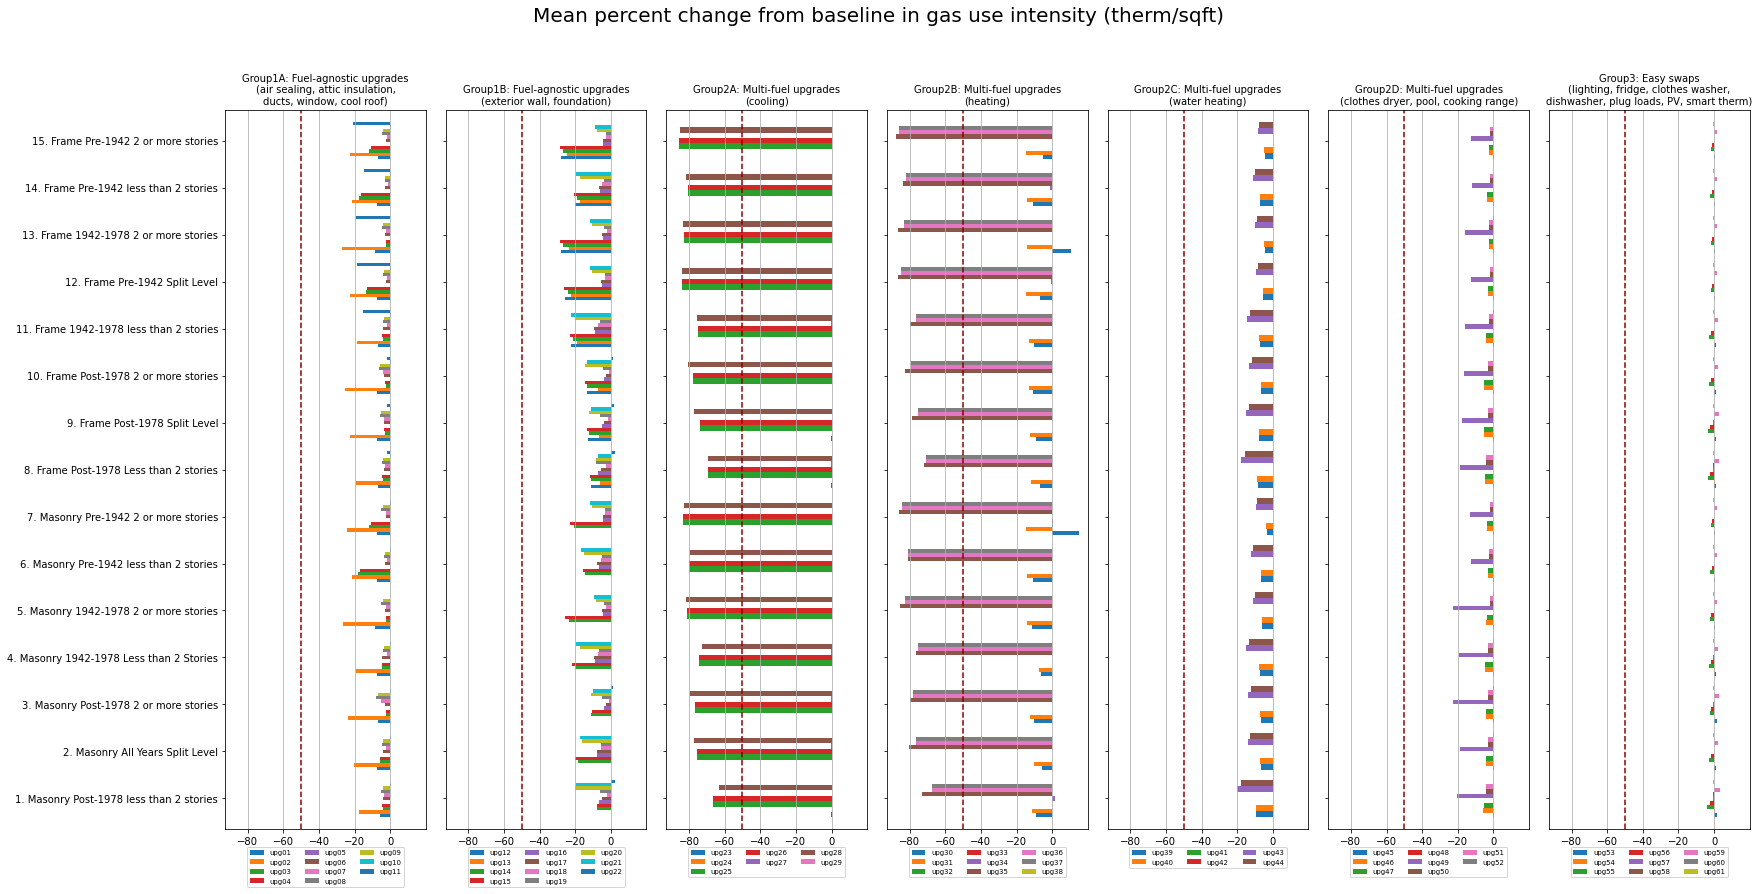

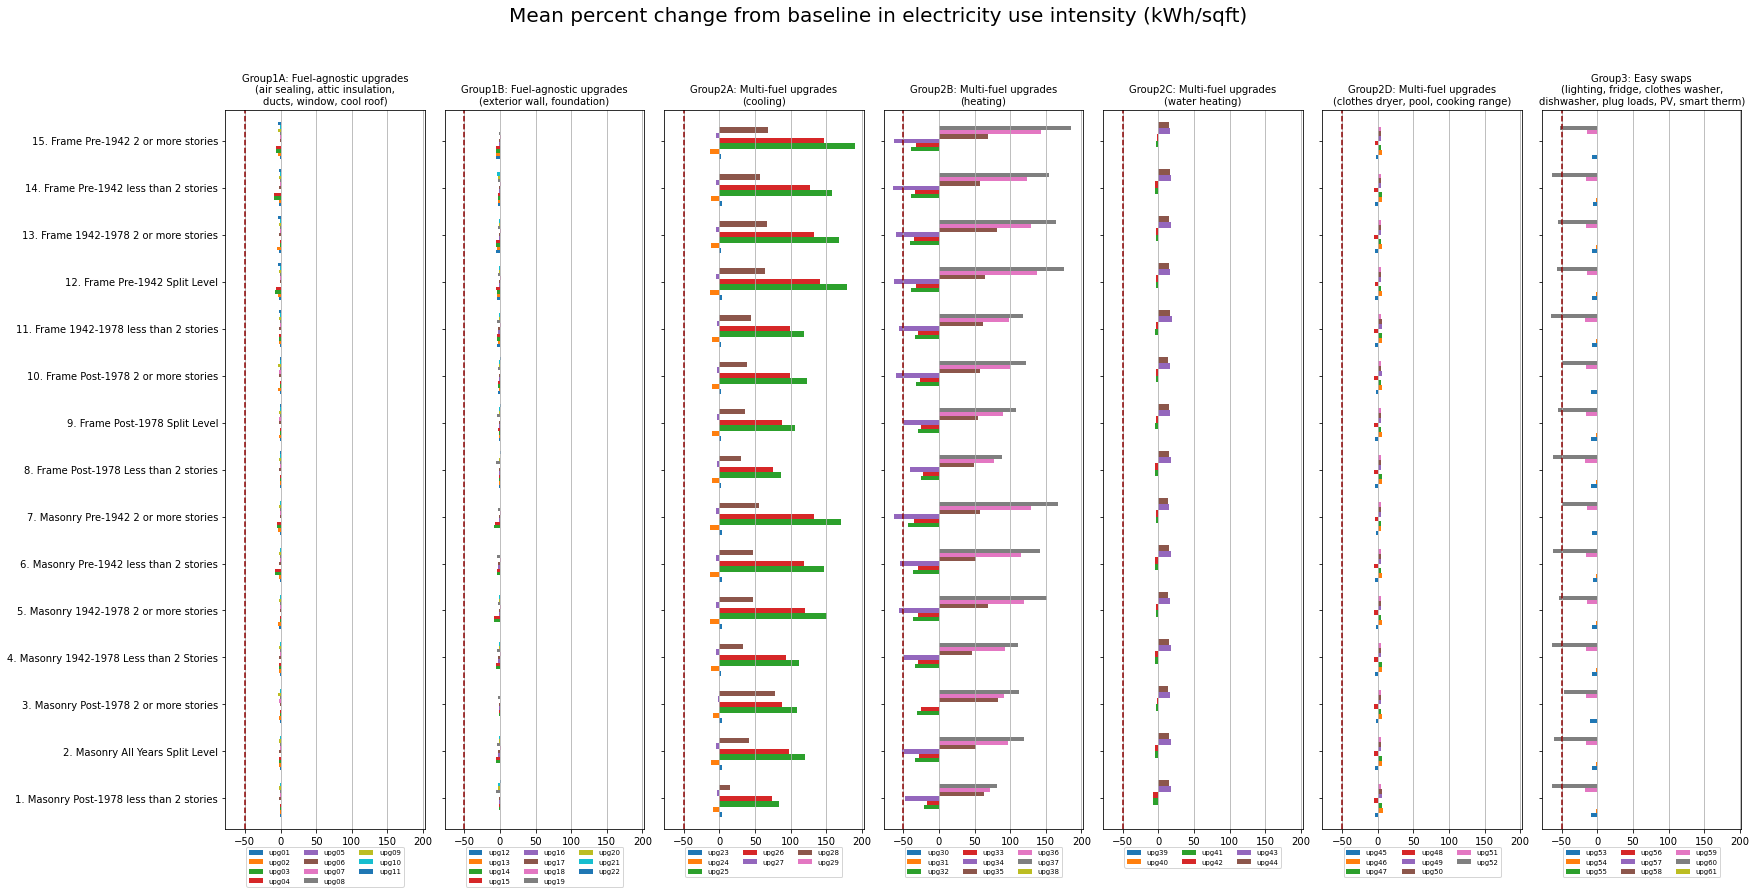

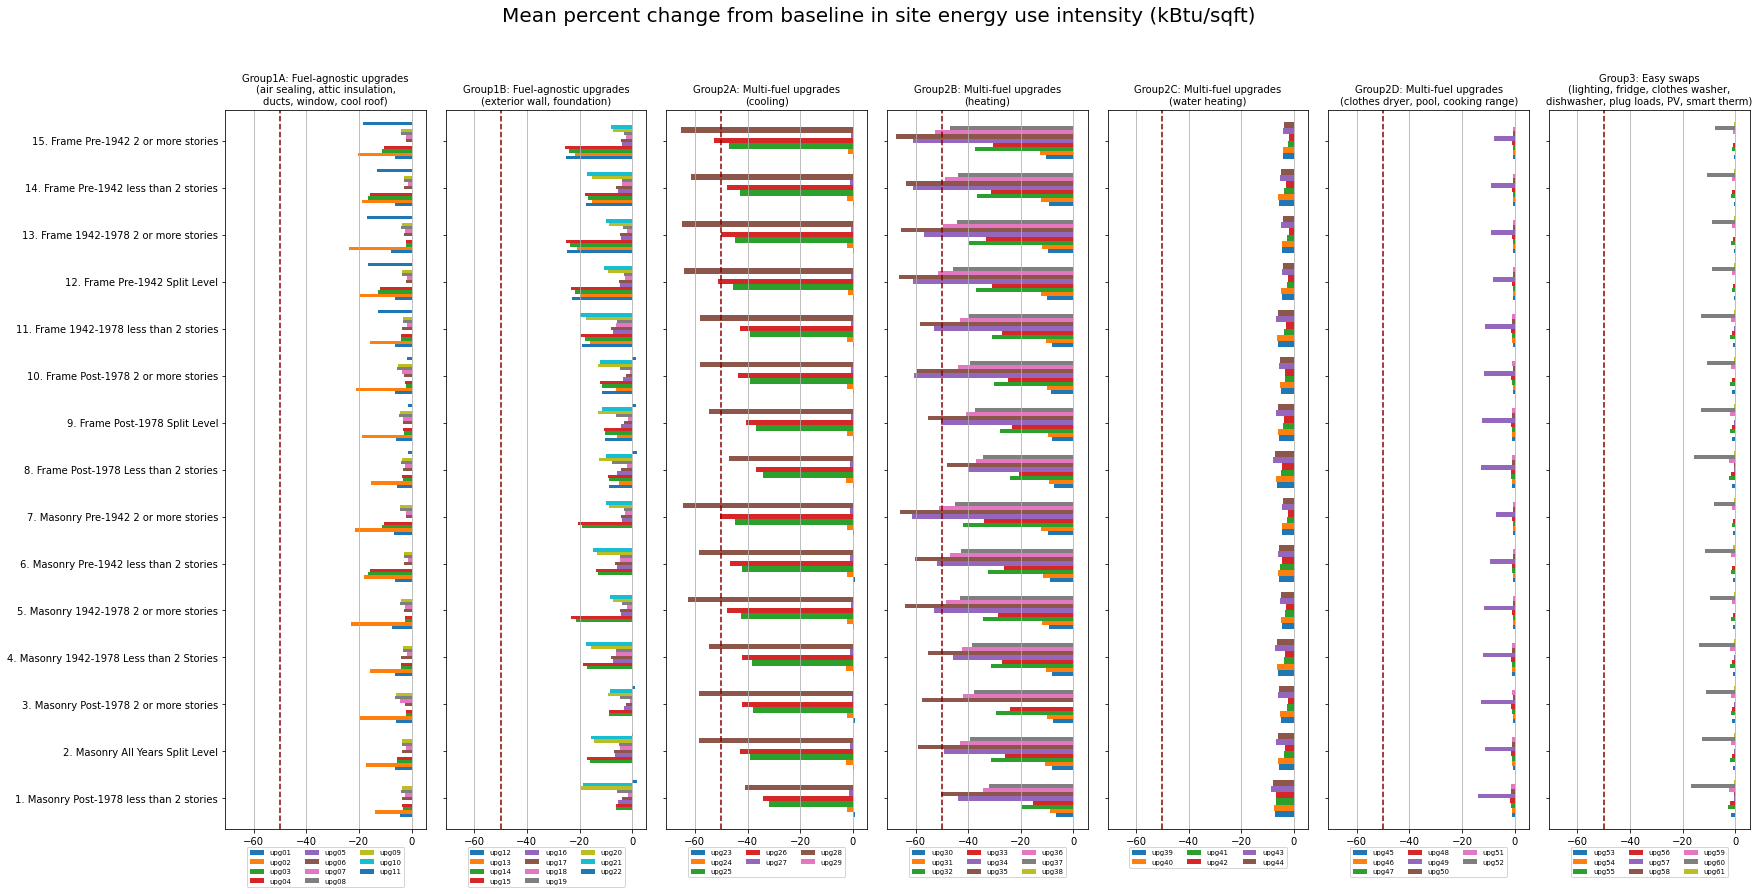

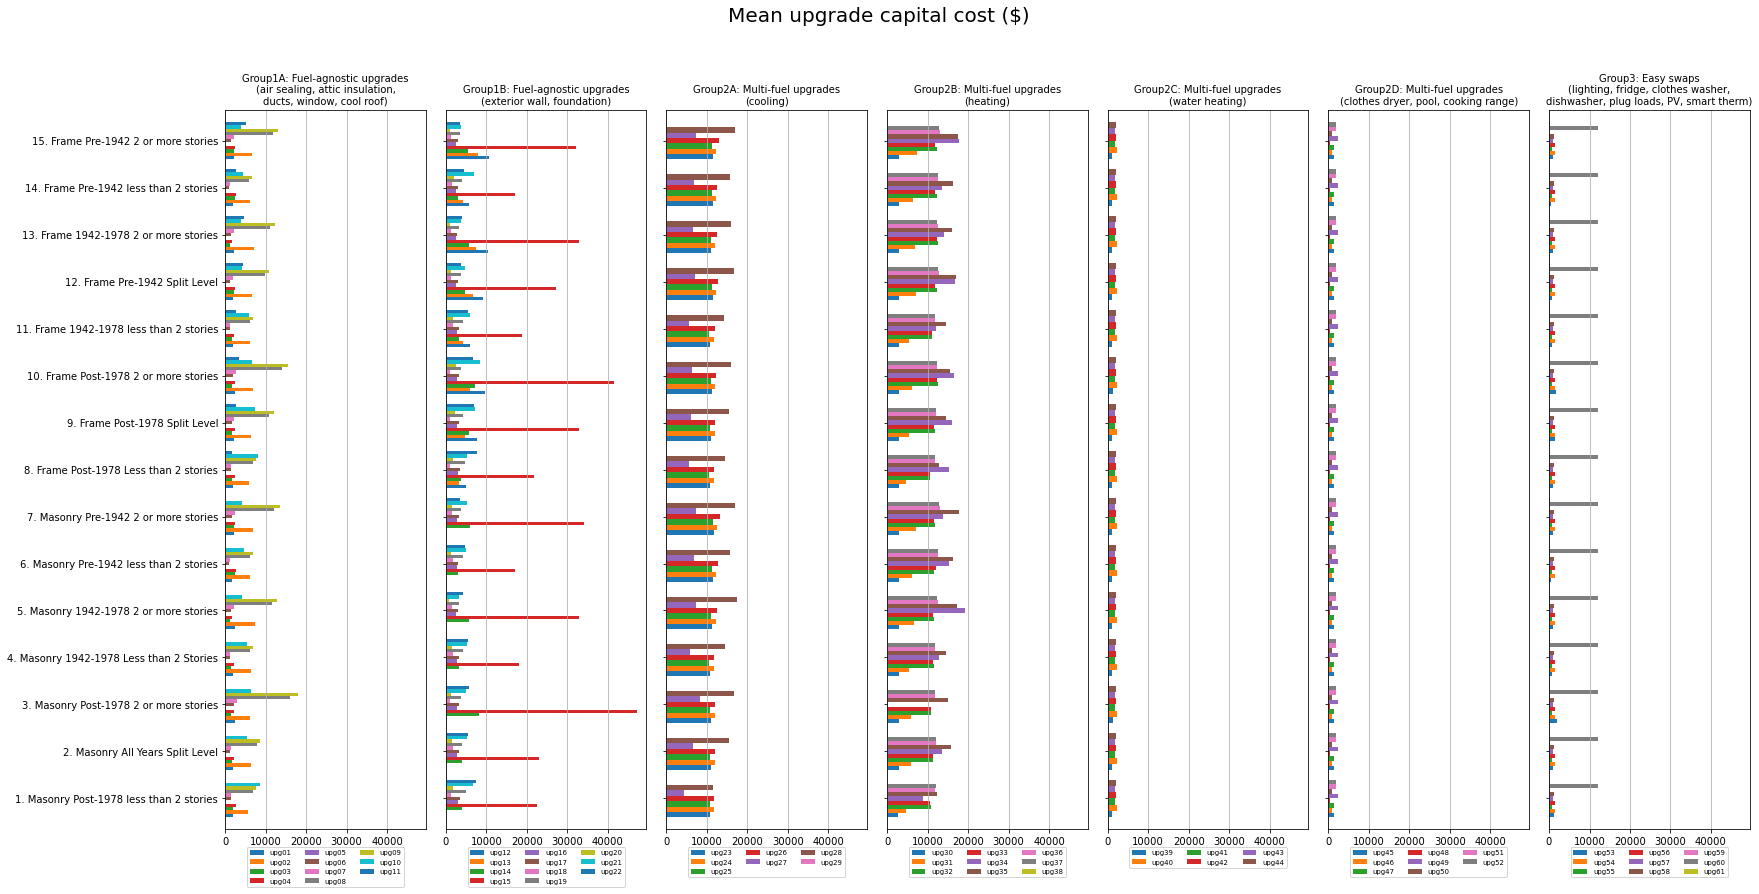

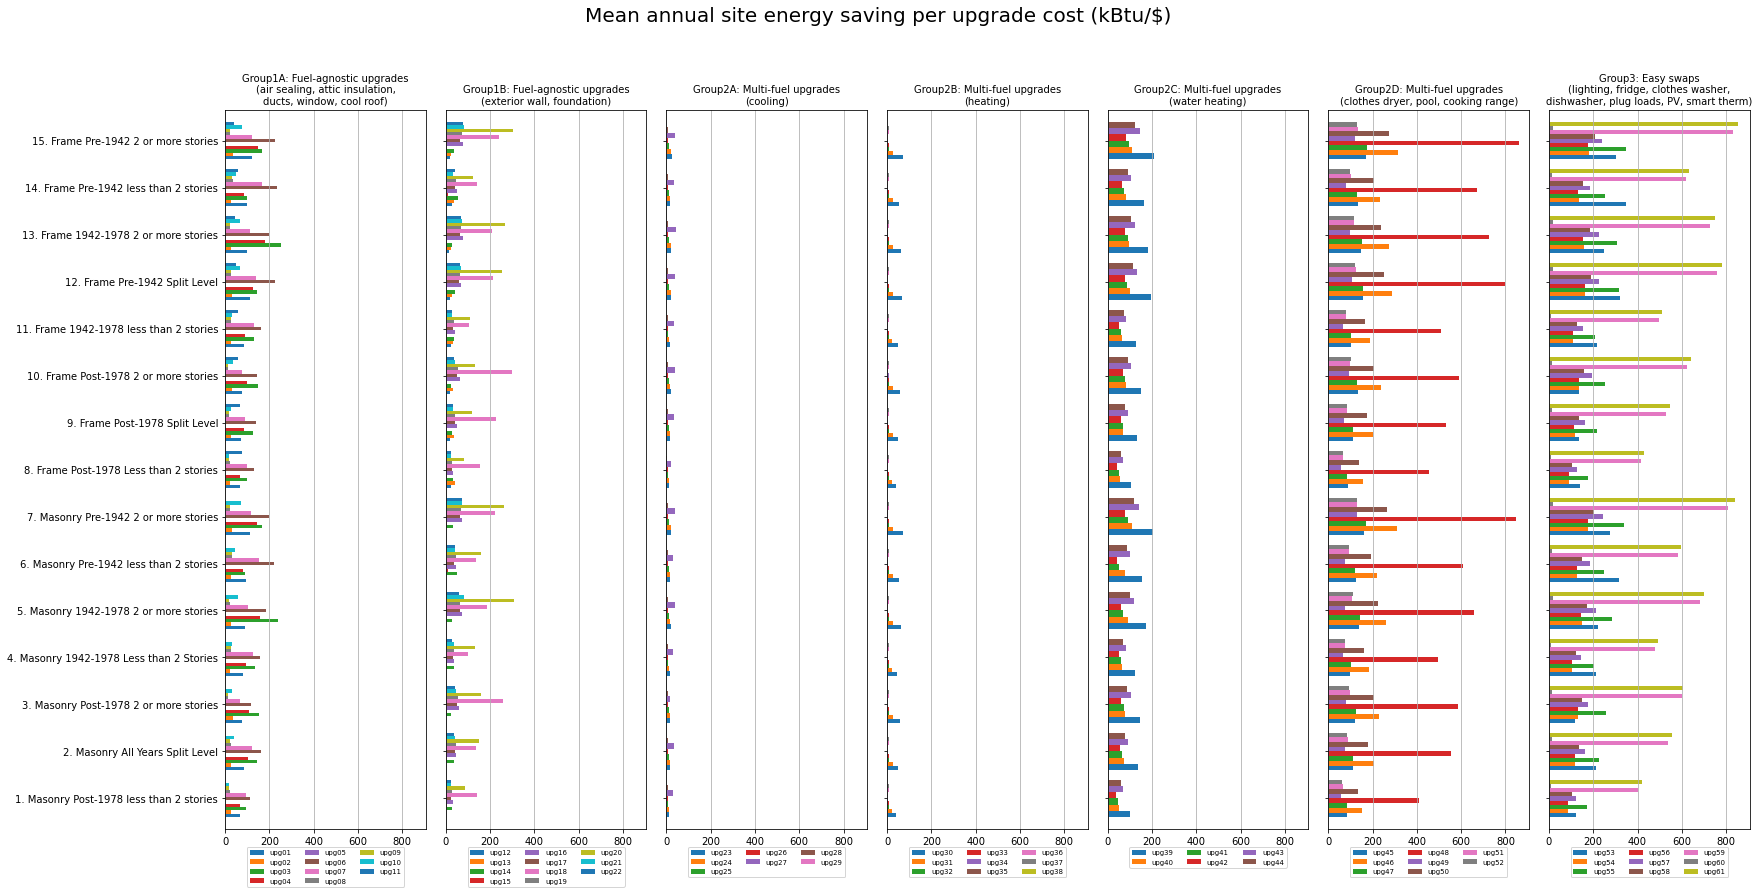

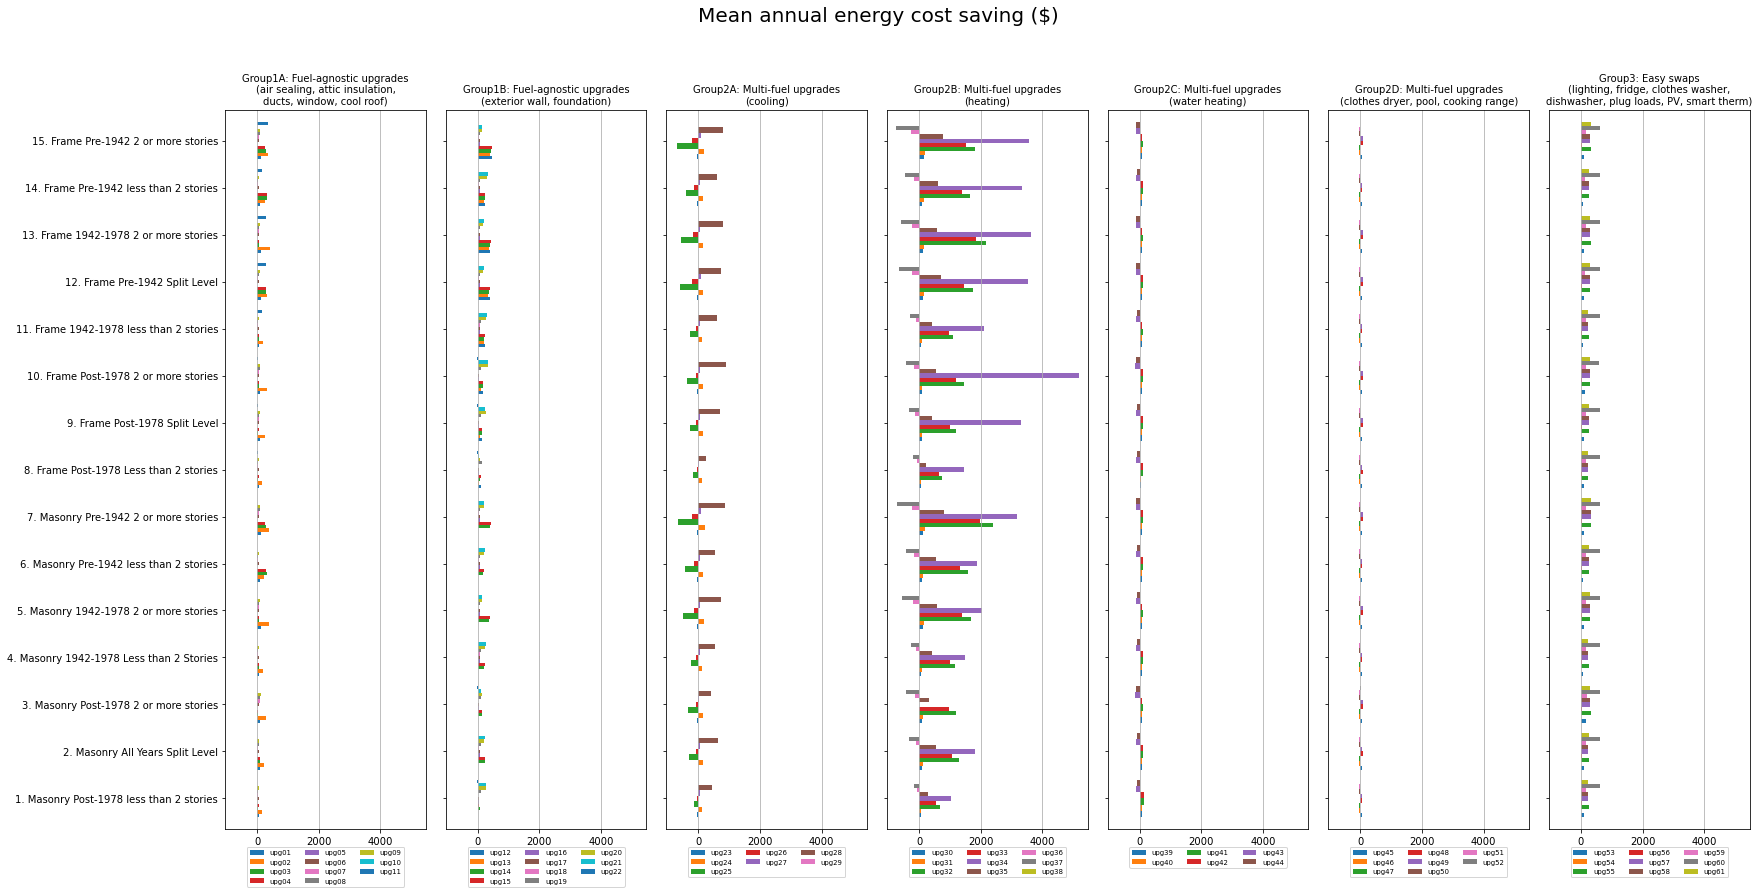

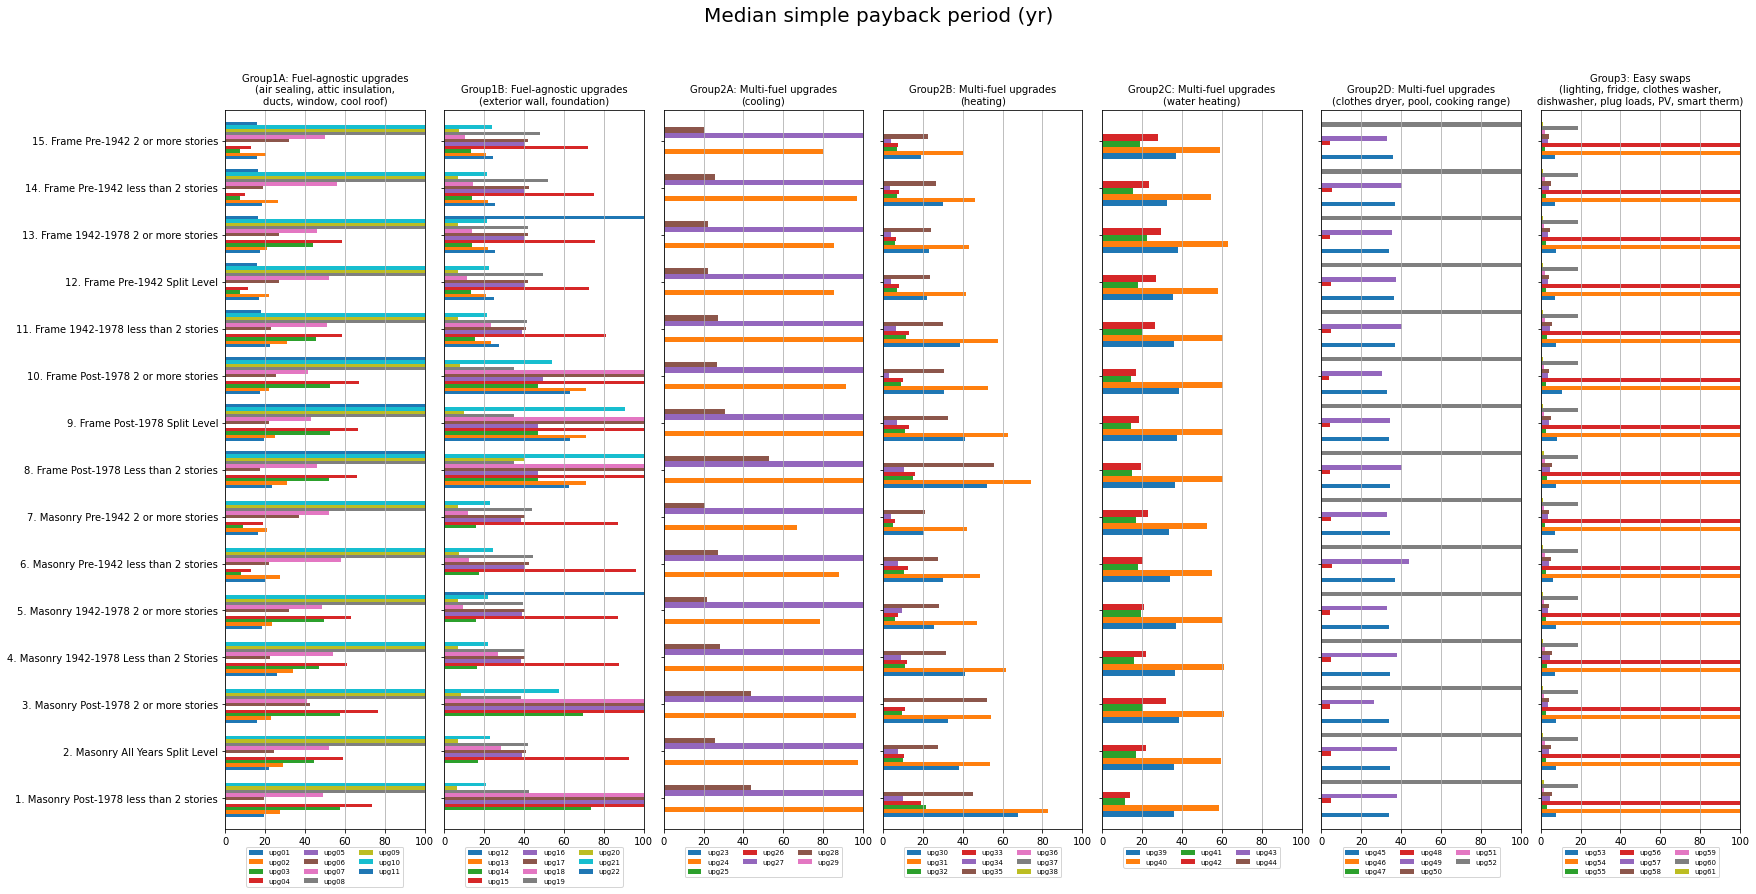

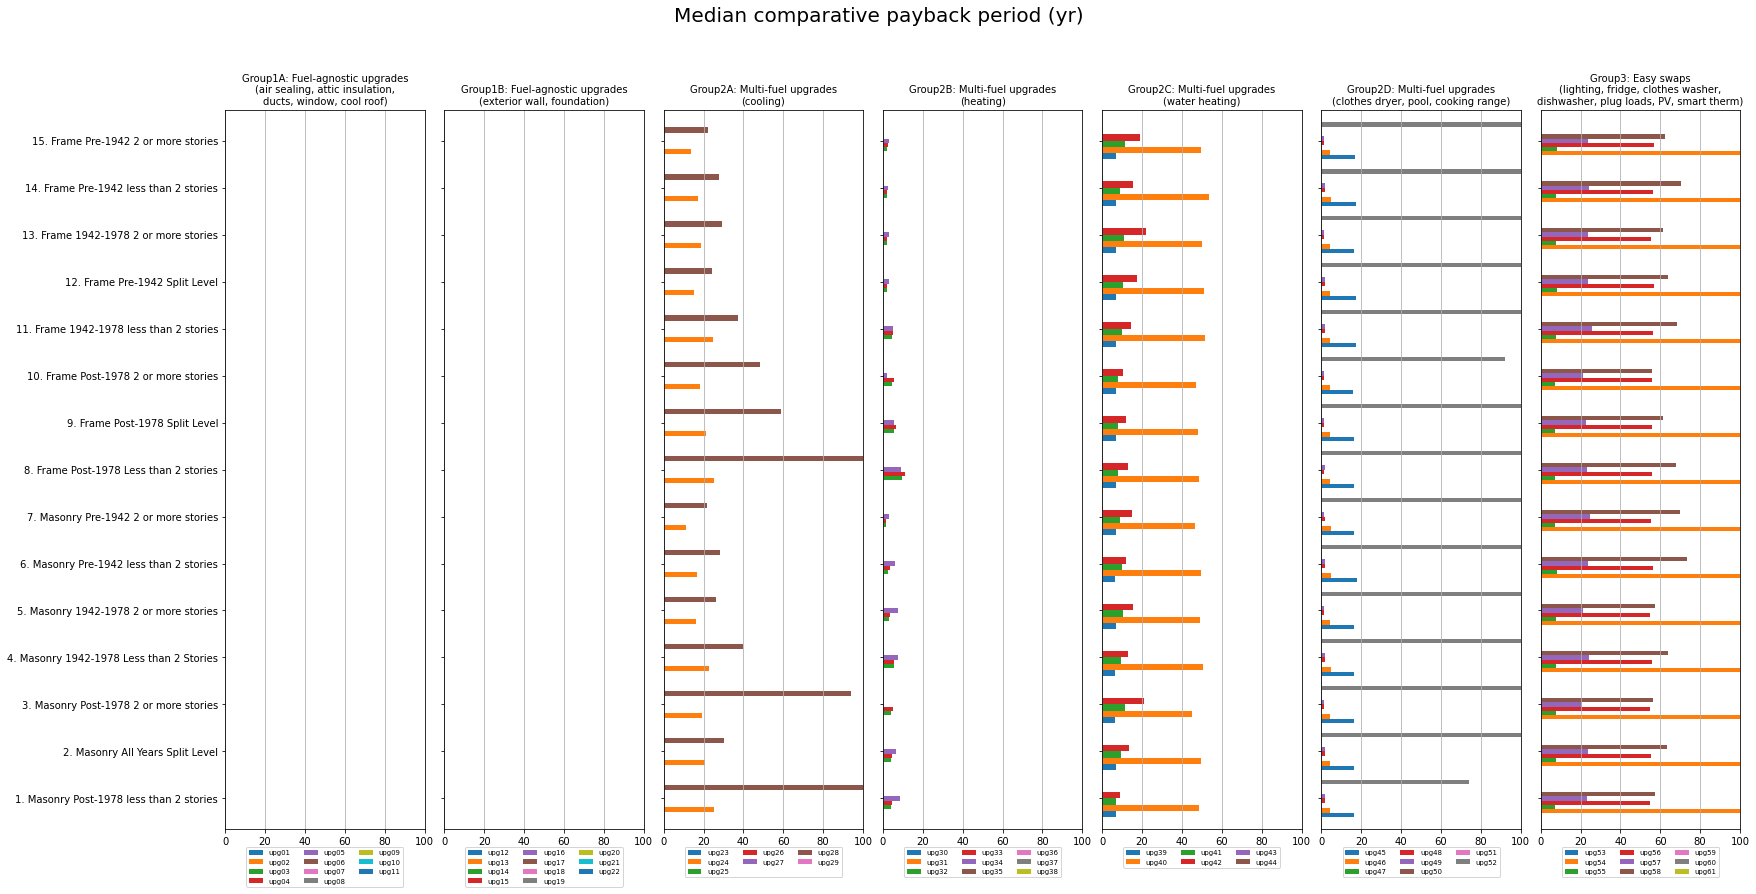

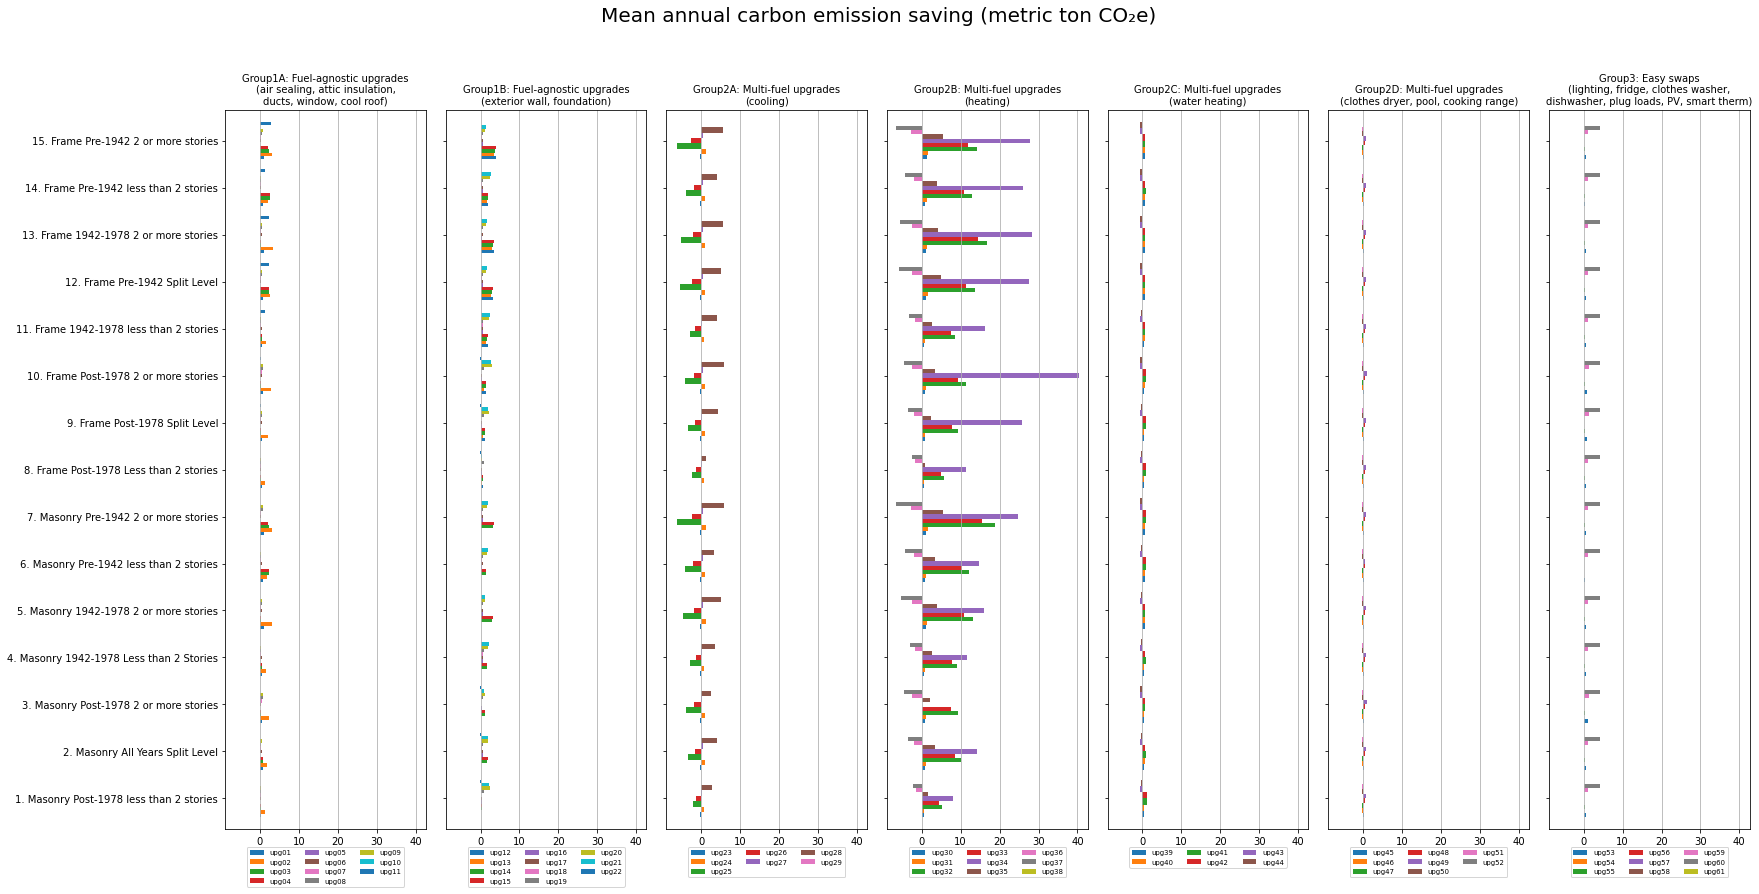

In [172]:
### plot mean values by sfd prototypes ###

zoom_in_plots = False # <-------

zoom_in_xlimits = {
    'mean_pct_delta_gas_eui': [None, None],
    'mean_pct_delta_elec_eui': [None, None],
    'mean_pct_delta_site_eui': [-25, None],
    'mean_upgrade_cost': [None, 10000],
    'mean_ann_kbtu_saved_per_dollar': [None, 500],
    'mean_ann_energy_cost_saving': [None, 2000],
    'median_simple_payback': [-70, 70],
    'median_comparative_payback': [-70, 70],
    'mean_ann_metric_ton_co2e_saving': [None, 20],
}

# create subfolder for plots:
plot_path1 = os.path.join(plot_path, 'mean_values_by_sfd_prototype')
if not os.path.exists(plot_path1):
    os.mkdir(plot_path1)
print(f'plot dir: {plot_path1}\n')

title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'

if NG_rate_multiplier == 1:
    para_labels = {
        'mean_pct_delta_gas_eui': 'Mean percent change from baseline in gas use intensity (therm/sqft)',
        'mean_pct_delta_elec_eui': 'Mean percent change from baseline in electricity use intensity (kWh/sqft)',
        'mean_pct_delta_site_eui': 'Mean percent change from baseline in site energy use intensity (kBtu/sqft)',
        'mean_upgrade_cost': 'Mean upgrade capital cost ($)',
        'mean_ann_kbtu_saved_per_dollar': 'Mean annual site energy saving per upgrade cost (kBtu/$)',
        'mean_ann_energy_cost_saving': f'Mean annual energy cost saving{title_ext} ($)',
        'median_simple_payback': f'Median simple payback period{title_ext} (yr)',
        'median_comparative_payback': f'Median comparative payback period{title_ext} (yr)',
        'mean_ann_metric_ton_co2e_saving': f'Mean annual carbon emission saving (metric ton CO₂e)',
    }
else:
    para_labels = {
        'mean_ann_energy_cost_saving': f'Mean annual energy cost saving{title_ext} ($)',
        'median_simple_payback': f'Median simple payback period{title_ext} (yr)',
        'median_comparative_payback': f'Median comparative payback period{title_ext} (yr)',
    }

    
for i, para_to_plot in enumerate(para_labels.keys(),1):
    
    zoom_ext = ''
    if zoom_in_plots:
        if len(list(x for x in zoom_in_xlimits[para_to_plot] if x is not None))>0:
            zoom_ext = '_zoomed'

    print(f'>> {i}. plotting {para_to_plot}{fn_ext}{zoom_ext}...')
    para_label = para_labels[para_to_plot]

    idx = groups2.loc[:,(('Baseline'),('HousingGroupNo'))].astype(str) +'. '+\
          groups2.loc[:,(('Baseline'),('HousingGroupName'))]
    UPs = groups2.set_index(idx)[para_to_plot]
    xmin = UPs.replace([np.inf, -np.inf], np.nan).min().min()*1.05
    xmax = UPs.replace([np.inf, -np.inf], np.nan).max().max()*1.05
    
    fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(ncols=7, nrows=1, 
                                                            sharex=True, sharey=True, figsize=(3.5*7, 12))

    ### Group 1: Intensive, fuel-agnostic upgrades (upg01-upg22)
    # Group 1A: (upg01-upg11) N=10
    ax = ax1
    Name = 'Group1A: Fuel-agnostic upgrades\n(air sealing, attic insulation,\nducts, window, cool roof)'
    UPi = UPs.iloc[:, :11] 
    UPi.plot(kind='barh', width=0.8, ax=ax)
    ax.xaxis.grid(True)
    if (para_to_plot[-3:]=='eui') & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='darkred')
    ax.set_title(Name, fontsize='medium')
    ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -.02), fontsize='x-small')
    ax.margins(y=0)

    # Group 1B: (upg12-upg22) N=11
    ax = ax2
    Name = 'Group1B: Fuel-agnostic upgrades\n(exterior wall, foundation)'
    UPi = UPs.iloc[:, 11:22]
    UPi.plot(kind='barh', width=0.8, ax=ax)
    ax.xaxis.grid(True)
    if (para_to_plot[-3:]=='eui') & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='darkred')
    ax.set_title(Name, fontsize='medium')
    ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -.02), fontsize='x-small')
    ax.margins(y=0)

    
    ### Group 2: Multi-fuel upgrades (upg23-upg52)
    # Group 2A: (upg23-upg29) N=7
    ax = ax3
    Name = 'Group2A: Multi-fuel upgrades\n(cooling)'
    UPi = UPs.iloc[:, 22:29]
    UPi.plot(kind='barh', width=0.8, ax=ax)
    ax.xaxis.grid(True)
    if (para_to_plot[-3:]=='eui') & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='darkred')
    ax.set_title(Name, fontsize='medium')
    ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -.02), fontsize='x-small')
    ax.margins(y=0)

    # Group 2B: (upg30-upg38) N=9
    ax = ax4
    Name = 'Group2B: Multi-fuel upgrades\n(heating)'
    UPi = UPs.iloc[:, 29:38]
    UPi.plot(kind='barh', width=0.8, ax=ax)
    ax.xaxis.grid(True)
    if (para_to_plot[-3:]=='eui') & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='darkred')
    ax.set_title(Name, fontsize='medium')
    ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -.02), fontsize='x-small')
    ax.margins(y=0)

    # Group 2C: (upg39-upg44) N=6
    ax = ax5
    Name = 'Group2C: Multi-fuel upgrades\n(water heating)'
    UPi = UPs.iloc[:, 38:44]
    UPi.plot(kind='barh', width=0.8, ax=ax)
    ax.xaxis.grid(True)
    if (para_to_plot[-3:]=='eui') & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='darkred')
    ax.set_title(Name, fontsize='medium')
    ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -.02), fontsize='x-small')
    ax.margins(y=0)

    # Group 2D: (upg45-upg52) N=8
    ax = ax6
    Name = 'Group2D: Multi-fuel upgrades\n(clothes dryer, pool, cooking range)'
    UPi = UPs.iloc[:, 44:52]
    UPi.plot(kind='barh', width=0.8, ax=ax)
    ax.xaxis.grid(True)
    if (para_to_plot[-3:]=='eui') & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='darkred')
    ax.set_title(Name, fontsize='medium')
    ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -.02), fontsize='x-small')
    ax.margins(y=0)


    ### Group 3: Easy swaps (upg53-upg62) N=12
    ax = ax7
    Name = 'Group3: Easy swaps\n(lighting, fridge, clothes washer,\ndishwasher, plug loads, PV, smart therm)'
    UPi = UPs.iloc[:, 52:]
    UPi.plot(kind='barh', width=0.8, ax=ax)
    ax.xaxis.grid(True)
    if (para_to_plot[-3:]=='eui') & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='darkred')
    ax.set_title(Name, fontsize='medium')
    ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -.02), fontsize='x-small')
    ax.margins(y=0)
    
    if zoom_in_plots:
        [xmin, xmax] = zoom_in_xlimits[para_to_plot]
        if xmin is not None:
            ax.set_xlim(left = xmin)
        if xmax is not None:
            ax.set_xlim(right=xmax)
            
    if para_to_plot in ['median_simple_payback', 'median_comparative_payback']:
        ax.set_xlim(0,100)
    
    fig.suptitle(para_label, fontsize=20, y=1.03)
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)
    
    filename = f'{iter_path}-comparison_{para_to_plot}{zoom_ext}{fn_ext}.pdf'
    fig.savefig(os.path.join(plot_path1, filename),
                bbox_inches='tight')


#### 2.3.2. plot mean values for Chicago avg per SFD

In [173]:
Wtchicago = groups2.loc[:,[('Baseline', 'HousingGroupName'),('Baseline', 'Chicago Prevalence')]
                       ]['Baseline'].set_index('HousingGroupName')

## add 'Chicago avg' and 'Chicago total'
groups_avg = groups2.set_index(('Baseline', 'HousingGroupName')).drop('Baseline', level=0, axis=1)
groups_avg.index.name = groups_avg.index.name[1]
groups_avg = groups_avg.stack(level=0).stack().unstack(level=0)
groups_avg['Chicago avg'] = np.where(np.isnan(groups_avg),0,groups_avg).dot(
    np.where(np.isnan(Wtchicago),0,Wtchicago)) # np.dot() ignoring nan

## add upgrade names
upgrade_name_map = summary_upgrades.loc[~summary_upgrades['upgrade_no'].isnull(), ['upgrade_no','upgrade_name']]
upgrade_name_map.loc[:,'upgrade'] = upgrade_name_map['upgrade_no'].astype(int)
# upgrade_name_map.loc[:,'upgrade'] = 'upg' + \
#     upgrade_name_map['upgrade_no'].astype(int).astype(str).str.rjust(2,'0')
upgrade_name_map = upgrade_name_map.set_index('upgrade')['upgrade_name']

groups_avg = groups_avg.reset_index().rename({'level_0':'metrics','level_1':'upgrade_no'}, axis=1)
groups_avg['upgrade_no'] = groups_avg['upgrade_no'].str[3:5].astype(int)
groups_avg['upgrade_name'] = groups_avg['upgrade_no'].map(upgrade_name_map)
groups_avg = groups_avg.set_index(['metrics','upgrade_no','upgrade_name']).sort_index().reset_index()

### save a copy
groups_avg.to_csv(os.path.join(result_path,
                               'processed results',
                               f'upgrades_prototype_chicago_avg_results{fn_ext}.csv'),
                  index=True)
groups_avg


HousingGroupName                      metrics  upgrade_no  \
0                 mean_ann_energy_cost_saving           1   
1                 mean_ann_energy_cost_saving           2   
2                 mean_ann_energy_cost_saving           3   
3                 mean_ann_energy_cost_saving           4   
4                 mean_ann_energy_cost_saving           6   
..                                        ...         ...   
489                     median_simple_payback          57   
490                     median_simple_payback          58   
491                     median_simple_payback          59   
492                     median_simple_payback          60   
493                     median_simple_payback          61   

HousingGroupName                                       upgrade_name  \
0                 Air Leakage 25% Reduction, with Mech Vent unde...   
1                             Air Leakage to 1ACH50, with Mech Vent   
2                                            Attic Insulation, R-49   
3                                            Attic Insulation, R-60   
4                   Duct Sealing and Insulation to R-8, 10% Leakage   
..                                                              ...   
489                                           EnergyStar Dishwasher   
490                                 EnergyStar Dishwasher, Most Eff   
491                                        Plug Loads 50% Reduction   
492                                             Rooftop Solar, 4 kW   
493                                                Smart Thermostat   

HousingGroupName  Frame 1942-1978 2 or more stories  \
0                                            134.24   
1                                            412.90   
2                                             43.57   
3                                             45.29   
4                                             58.98   
..                                              ...   
489                                            3.52   
490                                            4.46   
491                                            1.88   
492                                           18.73   
493                                            1.06   

HousingGroupName  Frame 1942-1978 less than 2 stories  \
0                                               75.56   
1                                              189.47   
2                                               58.14   
3                                               60.93   
4                                               55.16   
..                                                ...   
489                                              4.52   
490                                              5.48   
491                                              2.04   
492                                             18.73   
493                                              1.33   

HousingGroupName  Frame Post-1978 2 or more stories  \
0                                             95.97   
1                                            328.24   
2                                             44.29   
3                                             49.66   
4                                             63.55   
..                                              ...   
489                                            3.53   
490                                            4.28   
491                                            1.63   
492                                           18.73   
493                                            1.09   

HousingGroupName  Frame Post-1978 Less than 2 stories  \
0                                               55.38   
1                                              155.68   
2                                               41.07   
3                                               46.85   
4                                               48.67   
..                                                ...   
489     

plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_02a/processed results/plots/mean_values_sfd_chicago_avg

Plotting Chicago avg: mean_ann_energy_cost_saving...
    - Group1
    - Group2
    - Group3
Plotting Chicago avg: mean_ann_kbtu_saved_per_dollar...
    - Group1
    - Group2
    - Group3
Plotting Chicago avg: mean_ann_metric_ton_co2e_saving...
    - Group1
    - Group2
    - Group3
Plotting Chicago avg: mean_pct_delta_elec_eui...
    - Group1
    - Group2
    - Group3
Plotting Chicago avg: mean_pct_delta_gas_eui...
    - Group1
    - Group2
    - Group3
Plotting Chicago avg: mean_pct_delta_site_eui...
    - Group1
    - Group2
    - Group3
Plotting Chicago avg: mean_upgrade_cost...
    - Group1
    - Group2
    - Group3
Plotting Chicago avg: median_comparative_payback...
    - Group1


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


    - Group2
    - Group3
Plotting Chicago avg: median_simple_payback...
    - Group1


/opt/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:361: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]


    - Group2
    - Group3


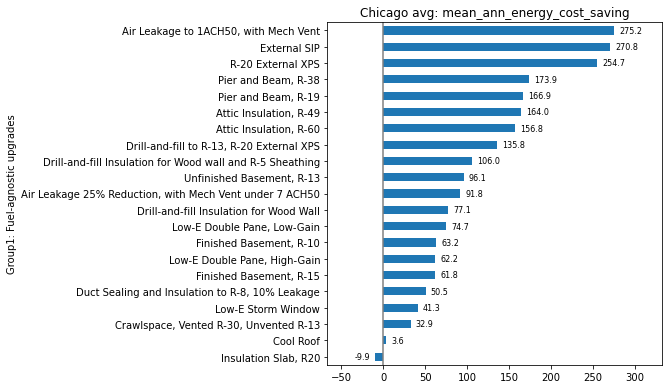

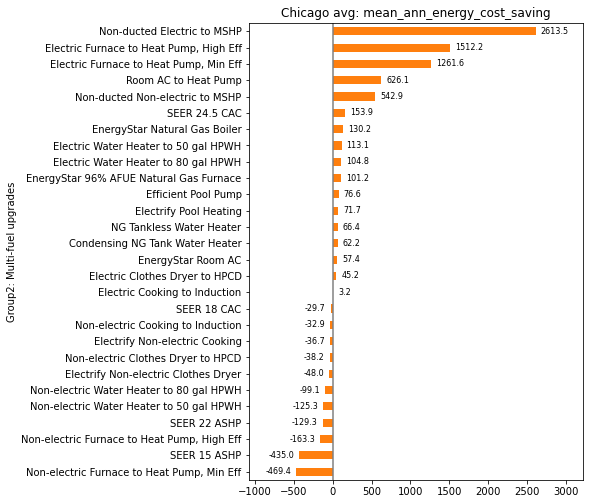

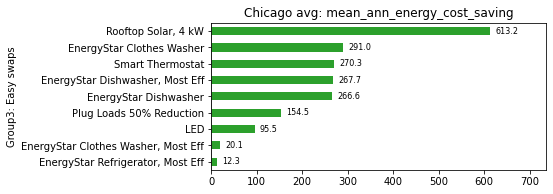

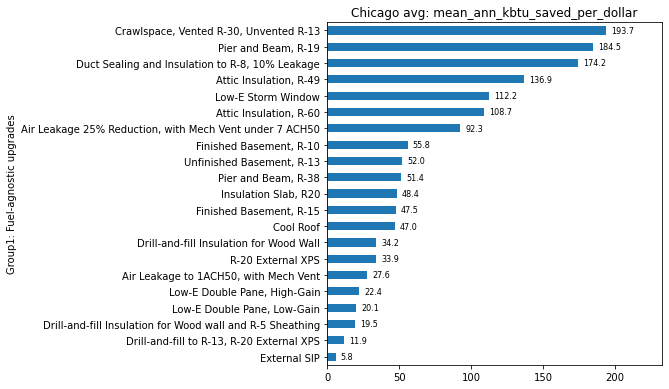

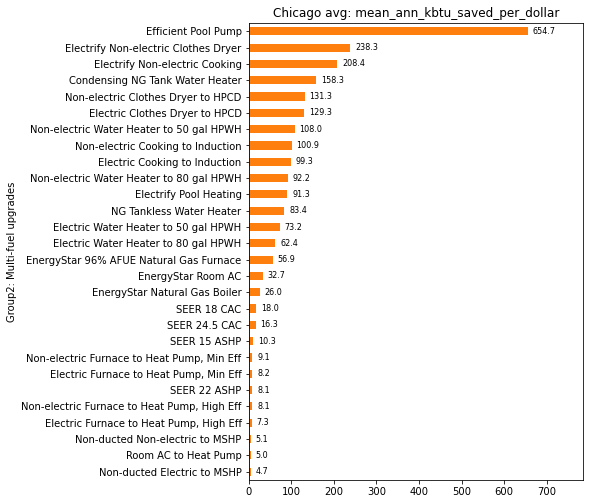

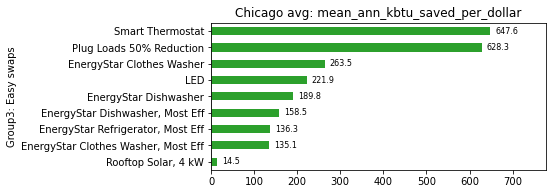

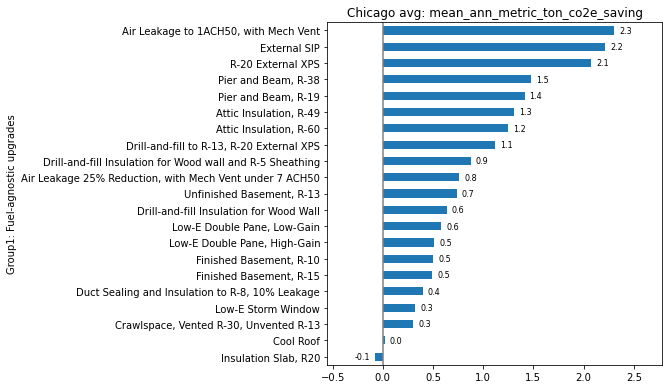

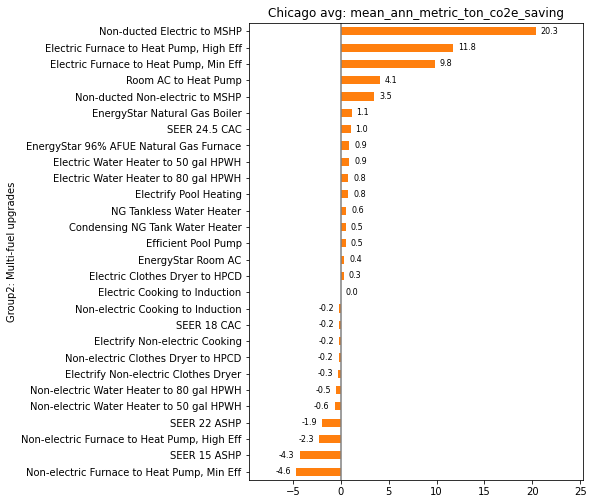

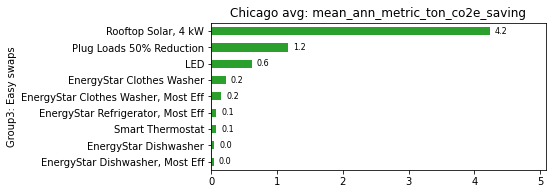

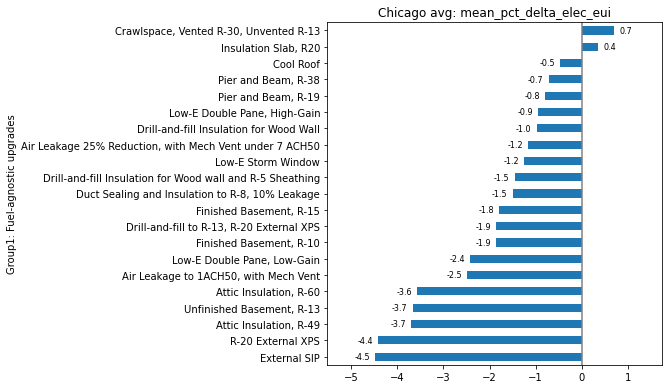

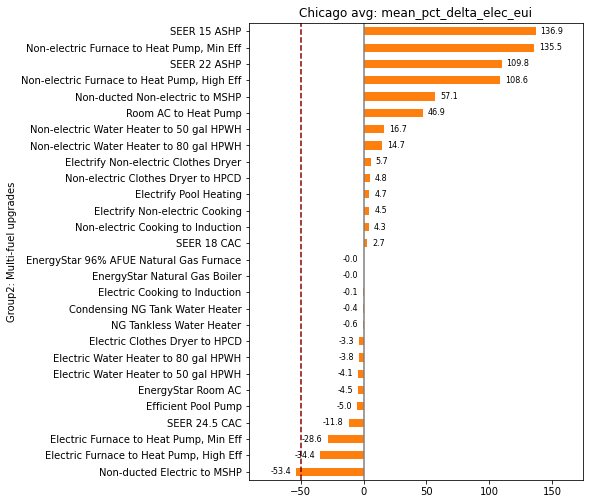

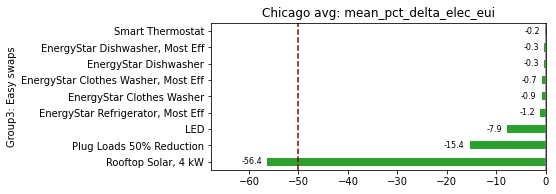

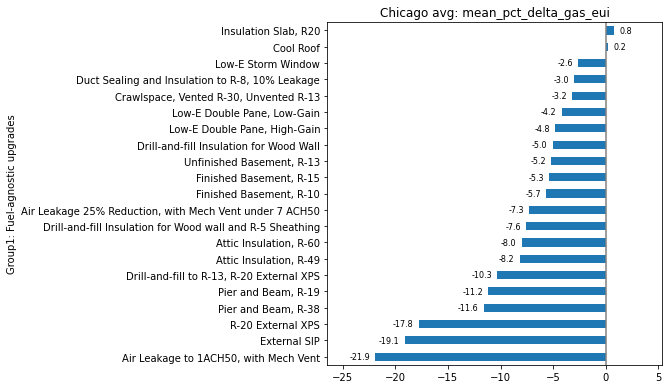

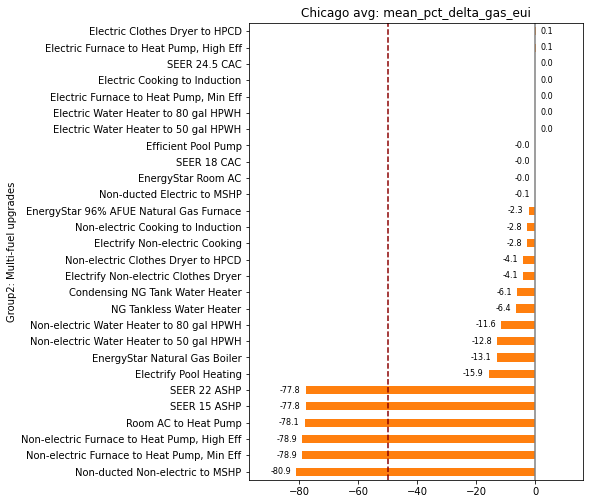

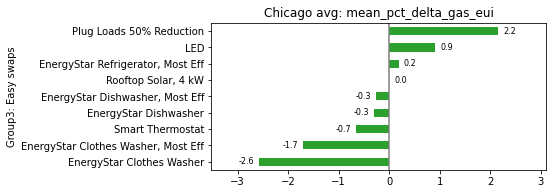

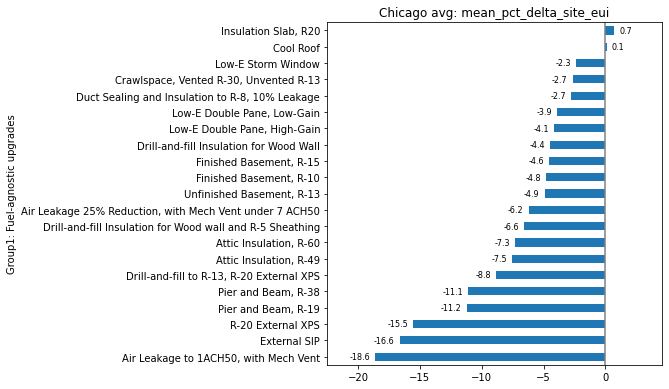

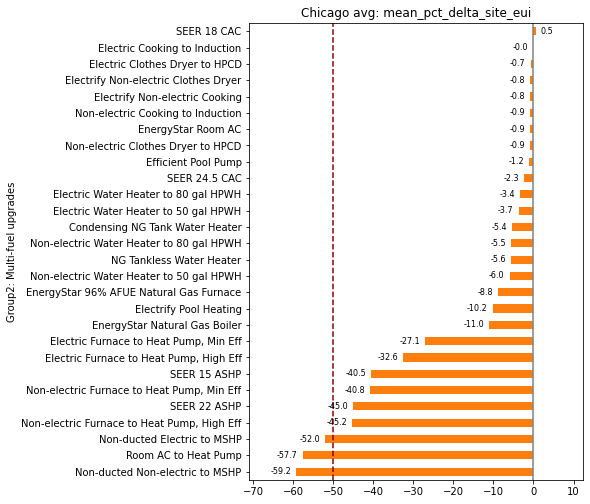

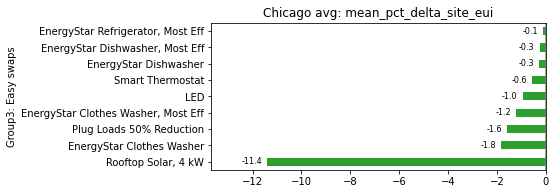

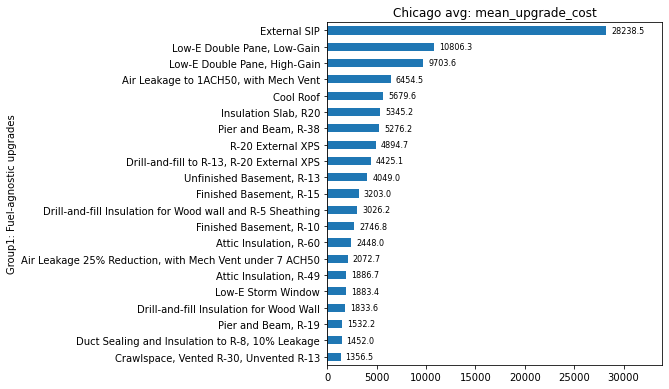

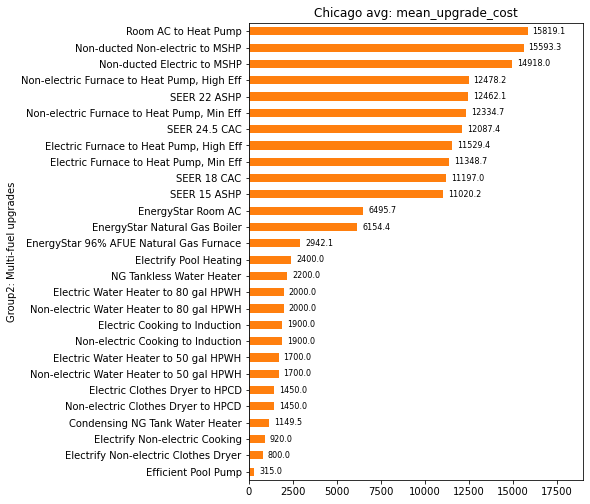

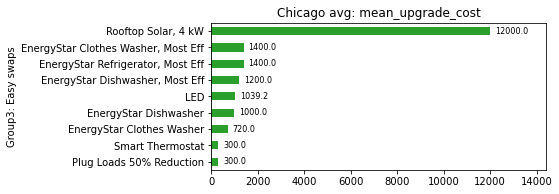

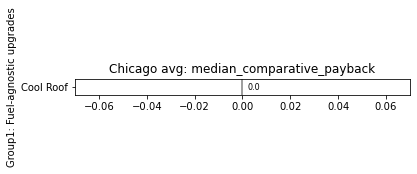

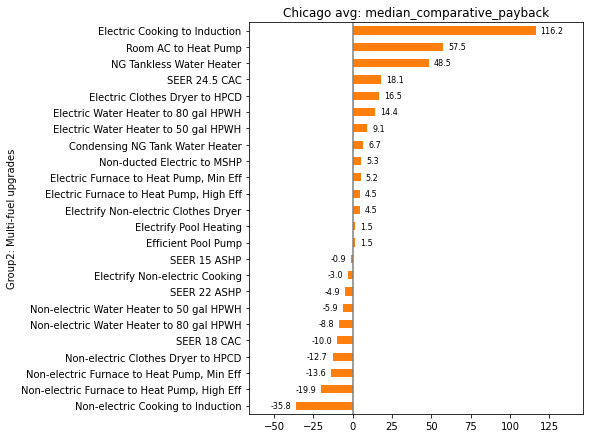

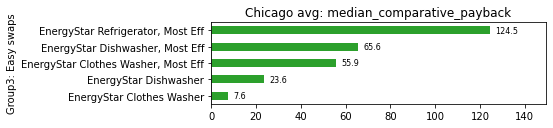

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:361: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]


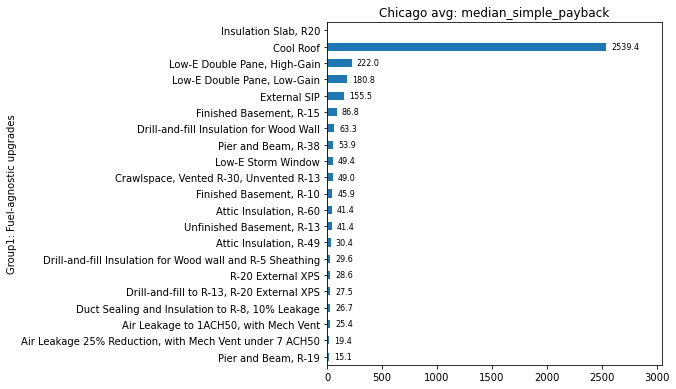

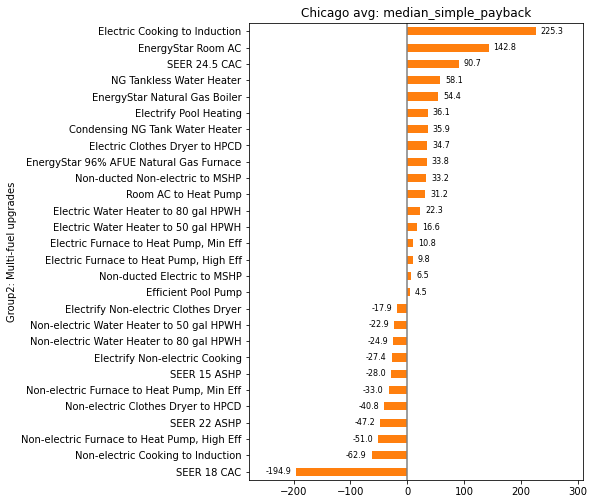

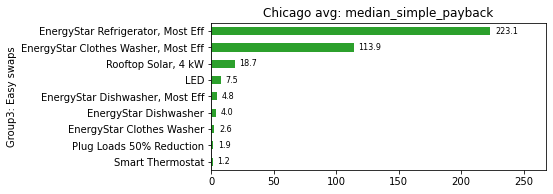

In [174]:
### plot Chicago-weighted avg from sfd prototypes ###

para_to_plot = 'Chicago avg' # <------

upgrade_sets = {
    'Group1: Fuel-agnostic upgrades': range(1, 23),
    'Group2: Multi-fuel upgrades': range(23, 53),
    'Group3: Easy swaps': range(53, 62),
}
upgrade_set_colors = {
    'Group1: Fuel-agnostic upgrades': 'tab:blue',
    'Group2: Multi-fuel upgrades': 'tab:orange',
    'Group3: Easy swaps': 'tab:green',
}

# create subfolder for plots:
plot_path2 = os.path.join(plot_path, 'mean_values_sfd_chicago_avg')
if not os.path.exists(plot_path2):
    os.mkdir(plot_path2)
print(f'plot dir: {plot_path2}\n')

if NG_rate_multiplier == 1: 
    metrics_to_plot = groups_avg['metrics'].unique()
else:
    metrics_to_plot = ['mean_ann_energy_cost_saving', 'median_simple_payback', 'median_comparative_payback']
    
for metric in metrics_to_plot:
    title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'
    title = f'{para_to_plot}: {metric}{title_ext}'
    print(f'Plotting {title}...')
    
    for n, up in enumerate(upgrade_sets.keys(),1):
        print(f'    - Group{n}')
        
        groupi = groups_avg[(groups_avg['metrics']==metric) & 
                              (groups_avg['upgrade_no'].isin(upgrade_sets[up]))][[
            'upgrade_name',para_to_plot]].set_index('upgrade_name')
        if metric == 'median_comparative_payback':
            groupi = groupi.replace(0,np.nan).sort_values(by = para_to_plot) # make 0 nan
        else:
            groupi = groupi.sort_values(by = para_to_plot)
            
        groupi.index.name = up
        
        ht = len(groupi)
        fig, ax = plt.subplots(figsize=(6, 0.3*ht))
        groupi.plot.barh(color=upgrade_set_colors[up], legend=False, title=title, ax=ax)
        
        # For each bar: Place a label ############################
        rects = ax.patches
        for rect in rects:
            # Get X and Y placement of label from rect.
            x_value = rect.get_width()
            y_value = rect.get_y() + rect.get_height() / 2

            # Number of points between bar and label. Change to your liking.
            space = 5
            # Vertical alignment for positive values
            ha = 'left'

            # If value of bar is negative: Place label left of bar
            if x_value < 0:
                # Invert space to place label to the left
                space *= -1
                # Horizontally align label at right
                ha = 'right'

            # Use X value as label and format number with one decimal place
            label = "{:.1f}".format(x_value)

            # Create annotation
            plt.annotate(
                label,                      # Use `label` as label
                (x_value, y_value),         # Place label at end of the bar
                xytext=(space, 0),          # Horizontally shift label by `space`
                textcoords="offset points", # Interpret `xytext` as offset in points
                va='center',                # Vertically center label
                ha=ha,                      # Horizontally align label differently for
                fontsize=8)                 # positive and negative values. 
            
        ax.margins(x=0.2)    
        ax.axvline(x=0, linestyle='-', color='gray')
        if (metric[-3:]=='eui') & (ax.get_xlim()[0] < -50):
            ax.axvline(x=-50, linestyle='--', color='darkred')
        
        filename = f'upgrades_{iteration}-{para_to_plot}_{metric}_group{n}{fn_ext}.pdf'
        fig.savefig(os.path.join(plot_path2, filename),
                    bbox_inches='tight')
        

#### 2.3.3. plot mean values for Chicago total stock 
Run cell below to load df for plots

In [111]:
load_df_for_plot_below_from_file = False # <-----
    
if load_df_for_plot_below_from_file:
    NG_rate_multiplier = 1 # 1 or 3 <----- This controls what to plot in both '2.3.1.' and '2.3.2.' plots
 
    if NG_rate_multiplier > 1:
        fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
    else:
        fn_ext = ''

    groups_total = pd.read_csv(os.path.join(result_path,'processed results',f'upgrades_prototype_chicago_total_{fn_ext}.csv'),
                         header=[0])
    
    print(f'"groups_total{fn_ext}" df loaded from file.')
    display(groups_total)


"groups_total" df loaded from file.


metrics  upgrade_no  \
0    mean_ann_elec_cost_saving           1   
1    mean_ann_elec_cost_saving           2   
2    mean_ann_elec_cost_saving           3   
3    mean_ann_elec_cost_saving           4   
4    mean_ann_elec_cost_saving           6   
..                         ...         ...   
394          mean_upgrade_cost          54   
395          mean_upgrade_cost          55   
396          mean_upgrade_cost          56   
397          mean_upgrade_cost          57   
398          mean_upgrade_cost          58   

                                          upgrade_name  \
0    Air Leakage 25% Reduction, with Mech Vent unde...   
1                Air Leakage to 1ACH50, with Mech Vent   
2                               Attic Insulation, R-49   
3                               Attic Insulation, R-60   
4      Duct Sealing and Insulation to R-8, 10% Leakage   
..                                                 ...   
394                EnergyStar Clothes Washer, Most Eff   
395                              EnergyStar Dishwasher   
396                    EnergyStar Dishwasher, Most Eff   
397                           Plug Loads 25% Reduction   
398                                Rooftop Solar, 4 kW   

     Frame 1942-1978 2 or more stories  Frame 1942-1978 less than 2 stories  \
0                                27.42                                14.70   
1                                79.73                                29.80   
2                                16.15                                22.66   
3                                16.92                                23.78   
4                                20.48                                20.45   
..                                 ...                                  ...   
394                            2800.00                              2800.00   
395                            2000.00                              2000.00   
396                            2400.00                              2400.00   
397                             600.00                               600.00   
398                           24000.00                             24000.00   

     Frame Post-1978 2 or more stories  Frame Post-1978 Less than 2 stories  \
0                                15.17                                 7.74   
1                                65.52                                21.36   
2                                18.99                                16.02   
3                                21.27                                18.46   
4                                28.07                                23.55   
..                                 ...                                  ...   
394                            2800.00                              2800.00   
395                            2000.00                              2000.00   
396                            2400.00                              2400.00   
397                             600.00                               600.00   
398                           24000.00                             24000.00   

     Frame Post-1978 Split Level  Frame Pre-1942 2 or more stories  \
0                          11.95                             23.20   
1                          45.98                             62.49   
2                          17.66                            104.29   
3                          20.03                             97.77   
4                          26.02                             16.75   
..                           ...                               ...   
394                      2800.00                           2800.00   
395                      2000.00                           2000.00   
396                      2400.00                           2400.00   
397                       600.00                            600.00   
398                     24000.00                          24000.00   

     Frame Pre-1942 Split Level  F

plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_02a/processed results/plots/sum_values_sfd_chicago_total

Plotting Chicago total ann_elec_cost_saving...
    - Group1
    - Group2
    - Group3
Plotting Chicago total ann_gas_cost_saving...
    - Group1
    - Group2
    - Group3
Plotting Chicago total ann_kwh_elec_saving...
    - Group1
    - Group2
    - Group3
Plotting Chicago total ann_mbtu_site_energy_saving...
    - Group1
    - Group2
    - Group3
Plotting Chicago total ann_metric_ton_co2e_saving...
    - Group1
    - Group2
    - Group3
Plotting Chicago total ann_therm_gas_saving...
    - Group1
    - Group2
    - Group3
Plotting Chicago total upgrade_cost...
    - Group1
    - Group2
    - Group3


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


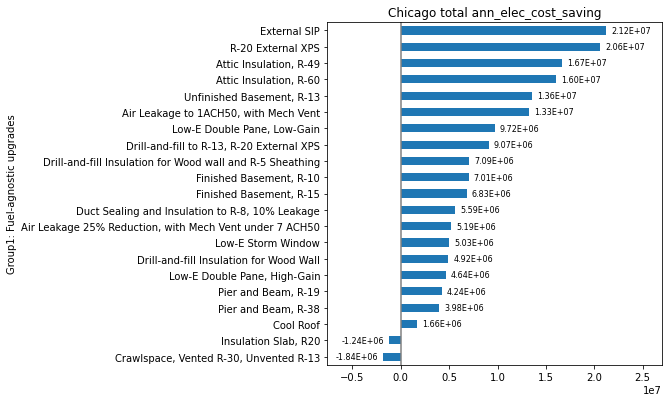

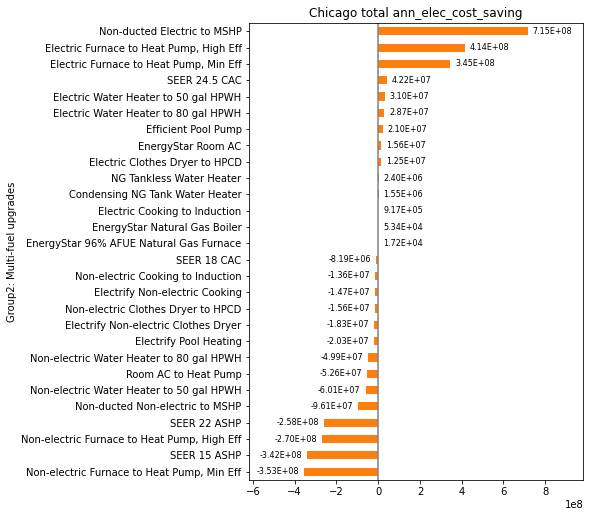

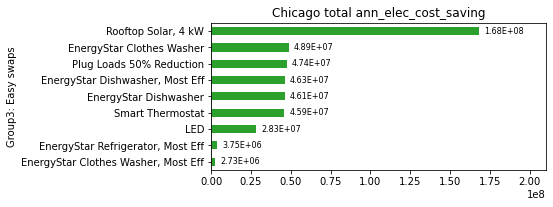

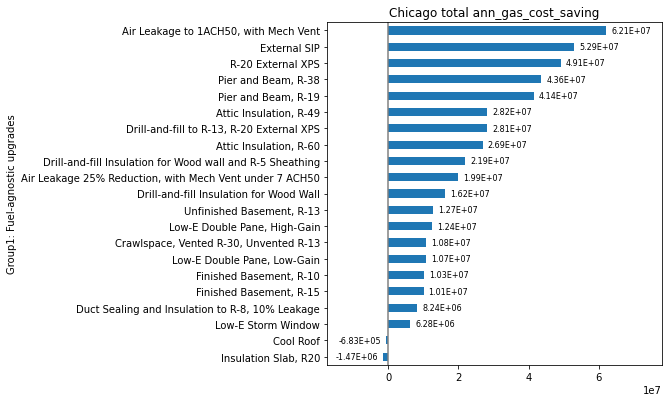

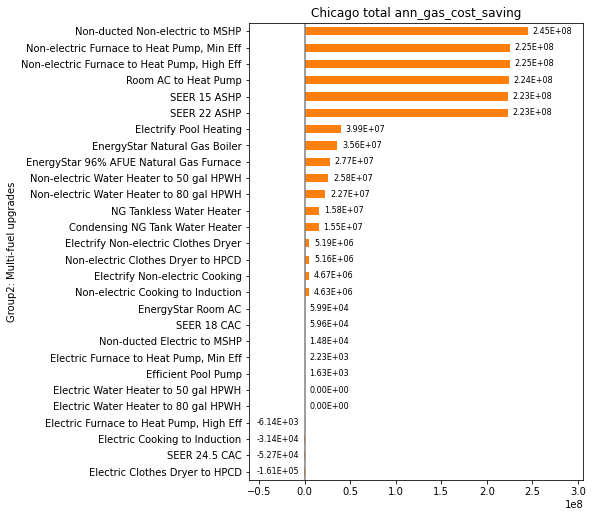

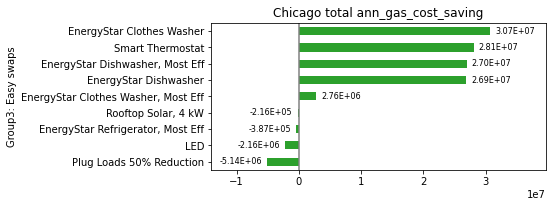

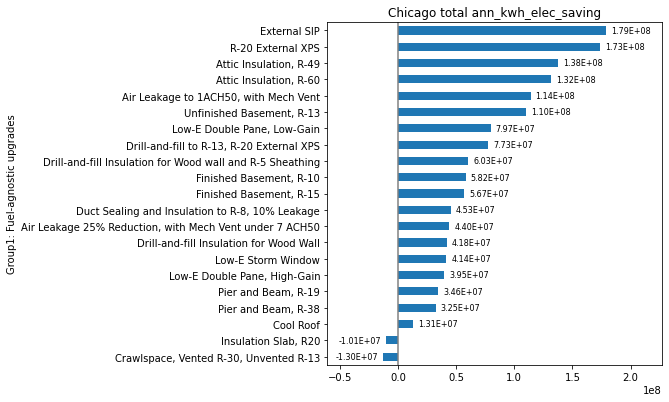

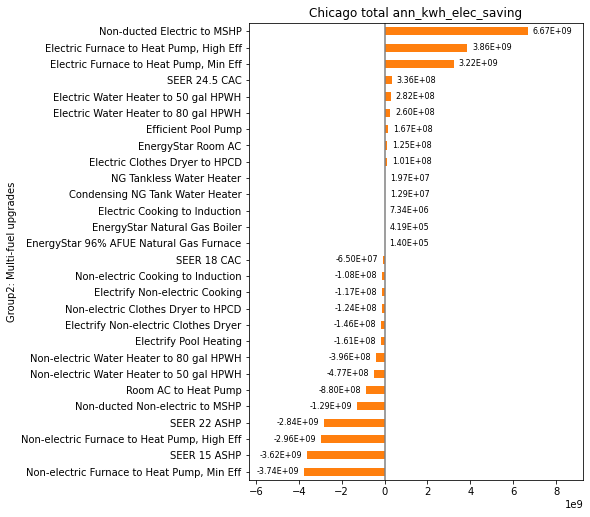

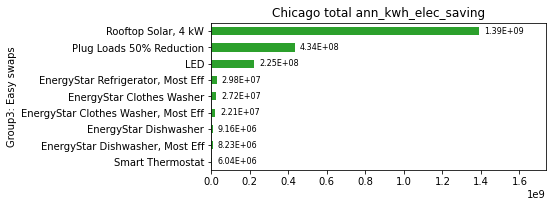

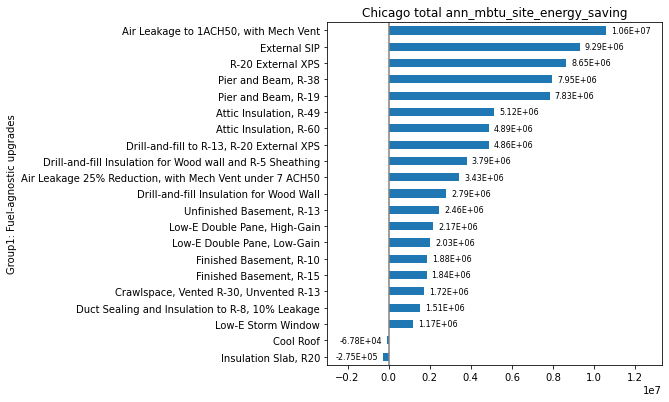

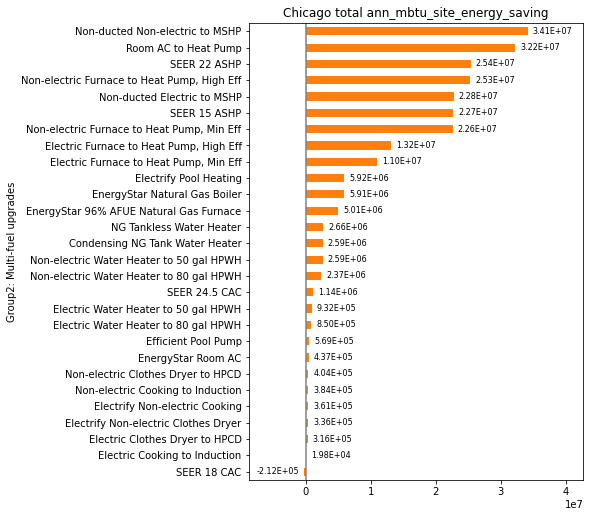

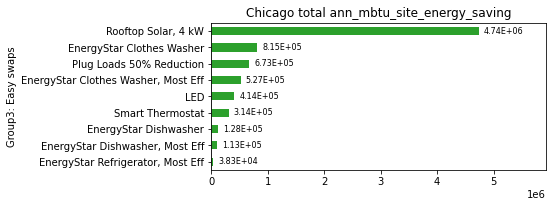

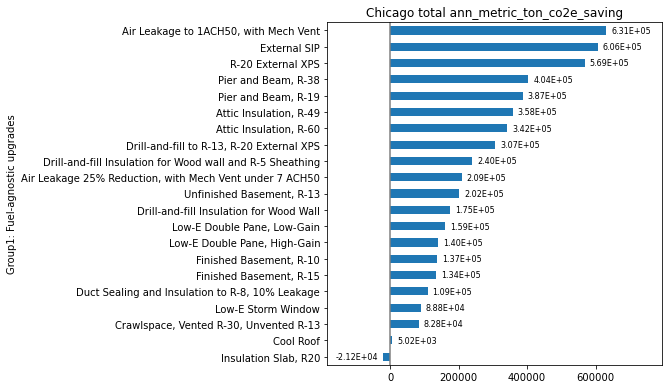

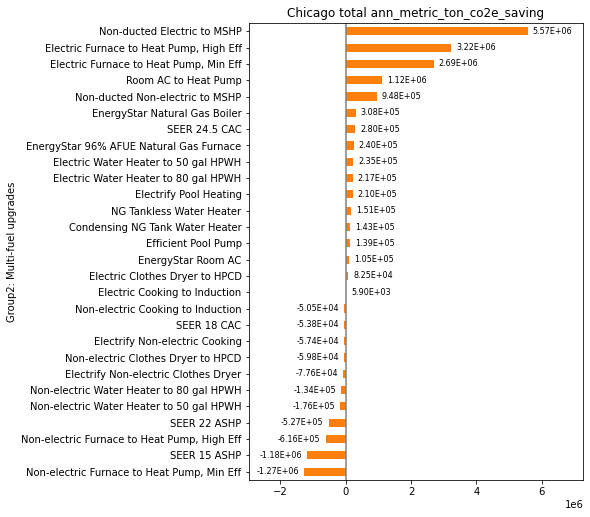

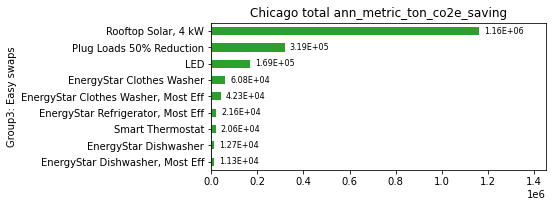

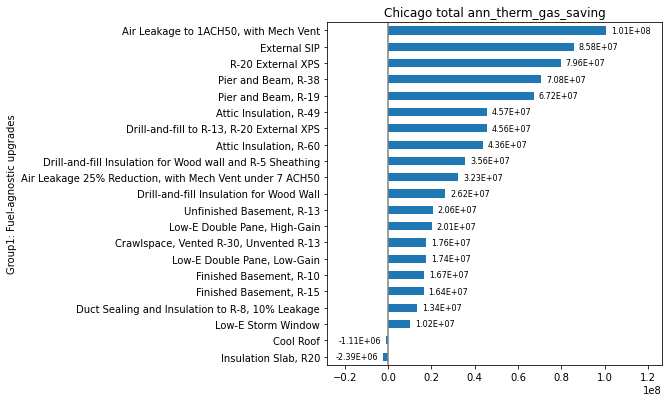

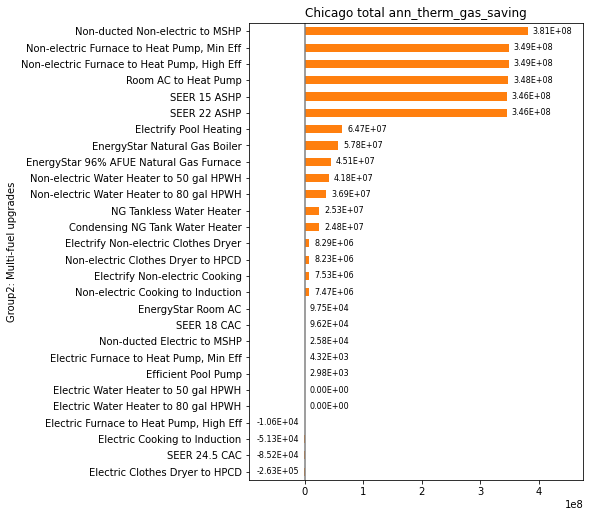

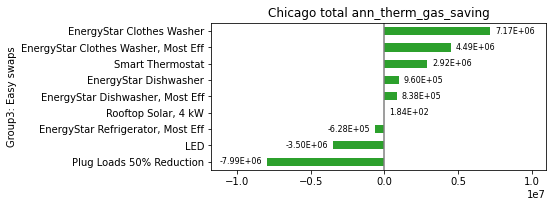

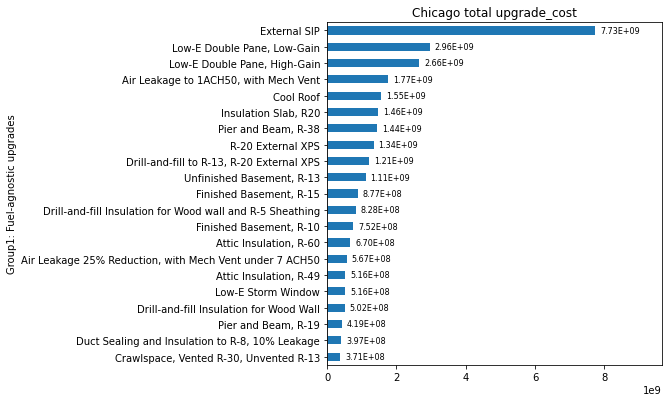

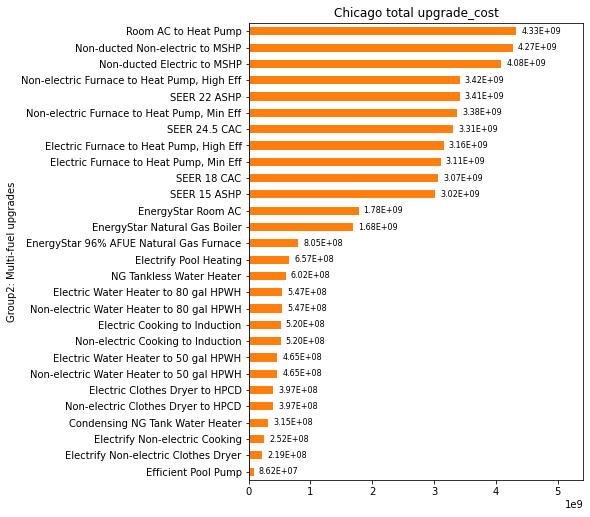

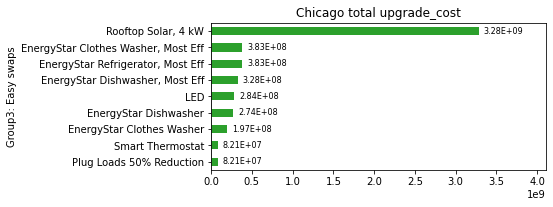

In [175]:
### plot Chicago total from sfd prototypes ###

para_to_plot = 'Chicago total' # <------

upgrade_sets = {
    'Group1: Fuel-agnostic upgrades': range(1, 23),
    'Group2: Multi-fuel upgrades': range(23, 53),
    'Group3: Easy swaps': range(53, 62),
}
upgrade_set_colors = {
    'Group1: Fuel-agnostic upgrades': 'tab:blue',
    'Group2: Multi-fuel upgrades': 'tab:orange',
    'Group3: Easy swaps': 'tab:green',
}

# create subfolder for plots:
plot_path3 = os.path.join(plot_path, 'sum_values_sfd_chicago_total')
if not os.path.exists(plot_path3):
    os.mkdir(plot_path3)
print(f'plot dir: {plot_path3}\n')

if NG_rate_multiplier == 1: 
    metrics_to_plot = groups_total['metrics'].unique()
else:
    metrics_to_plot = ['mean_ann_gas_cost_saving']
    
for metric in metrics_to_plot:
    title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'
    title = f'{para_to_plot} {metric[5:]}{title_ext}'
    print(f'Plotting {title}...')
    
    for n, up in enumerate(upgrade_sets.keys(),1):
        print(f'    - Group{n}')
        
        groupi = groups_total[(groups_total['metrics']==metric) & 
                              (groups_total['upgrade_no'].isin(upgrade_sets[up]))][[
            'upgrade_name',para_to_plot]].set_index('upgrade_name').sort_values(by=para_to_plot)
        groupi.index.name = up
        
        ht = len(groupi)
        fig, ax = plt.subplots(figsize=(6, 0.3*ht))
        groupi.plot.barh(color=upgrade_set_colors[up], legend=False, title=title, ax=ax)
        
        # For each bar: Place a label ############################
        rects = ax.patches
        for rect in rects:
            # Get X and Y placement of label from rect.
            x_value = rect.get_width()
            y_value = rect.get_y() + rect.get_height() / 2

            # Number of points between bar and label. Change to your liking.
            space = 5
            # Vertical alignment for positive values
            ha = 'left'

            # If value of bar is negative: Place label left of bar
            if x_value < 0:
                # Invert space to place label to the left
                space *= -1
                # Horizontally align label at right
                ha = 'right'

            # Use X value as label and format number with one decimal place
            label = "{:.2E}".format(x_value)

            # Create annotation
            plt.annotate(
                label,                      # Use `label` as label
                (x_value, y_value),         # Place label at end of the bar
                xytext=(space, 0),          # Horizontally shift label by `space`
                textcoords="offset points", # Interpret `xytext` as offset in points
                va='center',                # Vertically center label
                ha=ha,                      # Horizontally align label differently for
                fontsize=8)                 # positive and negative values.                      
                                            
        ax.margins(x=0.25)
        ax.axvline(x=0, linestyle='-', color='gray')
        
        filename = f'upgrades_{iteration}-{para_to_plot}_{metric[5:]}_group{n}{fn_ext}.pdf'
        fig.savefig(os.path.join(plot_path3, filename),
                    bbox_inches='tight')

#### 2.3.4. plot metrics distribution
Run cell below to load df for plots

In [124]:
load_df_for_plot_below_from_file = False # <-----
    
if load_df_for_plot_below_from_file:
    NG_rate_multiplier = 1 # 1 or 3 <----- This controls what to plot in both '2.3.1.' and '2.3.2.' plots
 
    if NG_rate_multiplier > 1:
        fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
    else:
        fn_ext = ''
    
    all_proto_upgrades = pd.read_csv(
        os.path.join(result_path, 'processed results', 'all_upgrades_by_prototype_combined.csv'))
    
    print(f'"all_proto_upgrades{fn_ext}" df loaded from file.')
    N_upgrades = all_proto_upgrades['upgrade_no'].nunique()
    print(f'   total number of upgrades: {N_upgrades}')
    
    display(all_proto_upgrades)
    

"all_proto_upgrades" df loaded from file.
   total number of upgrades: 57


building_id  job_id           started_at         completed_at  \
0                69     240  2020-12-15 23:47:30  2020-12-15 23:49:27   
1                74      90  2020-12-15 21:50:45  2020-12-15 21:52:39   
2               104      66  2020-12-15 22:39:34  2020-12-15 22:41:29   
3               130     116  2020-12-15 22:18:41  2020-12-15 22:20:33   
4               150      91  2020-12-15 23:21:59  2020-12-15 23:23:55   
...             ...     ...                  ...                  ...   
903050        16750     244  2020-12-16 00:43:41  2020-12-16 00:45:42   
903051        16758      13  2020-12-15 22:53:39  2020-12-15 22:55:42   
903052        16759     228  2020-12-15 22:12:46  2020-12-15 22:14:44   
903053        16769      91  2020-12-16 00:23:16  2020-12-16 00:25:22   
903054        16773      49  2020-12-15 22:03:01  2020-12-15 22:04:56   

       completed_status  apply_upgrade.applicable  \
0               Success                      True   
1               Success                      True   
2               Success                      True   
3               Success                      True   
4               Success                      True   
...                 ...                       ...   
903050          Success                      True   
903051          Success                      True   
903052          Success                      True   
903053          Success                      True   
903054          Success                      True   

                               apply_upgrade.upgrade_name  \
0       Air Leakage 25% Reduction, with Mech Vent unde...   
1       Air Leakage 25% Reduction, with Mech Vent unde...   
2       Air Leakage 25% Reduction, with Mech Vent unde...   
3       Air Leakage 25% Reduction, with Mech Vent unde...   
4       Air Leakage 25% Reduction, with Mech Vent unde...   
...                                                   ...   
903050                                Rooftop Solar, 4 kW   
903051                                Rooftop Solar, 4 kW   
903052                                Rooftop Solar, 4 kW   
903053                                Rooftop Solar, 4 kW   
903054                                Rooftop Solar, 4 kW   

        simulation_output_report.applicable  \
0                                      True   
1                                      True   
2                                      True   
3                                      True   
4                                      True   
...                                     ...   
903050                                 True   
903051                                 True   
903052                                 True   
903053                                 True   
903054                                 True   

        simulation_output_report.door_area_ft_2  \
0                                          20.0   
1                                          20.0   
2                                          20.0   
3                                          20.0   
4                                          20.0   
...                                         ...   
903050                                     20.0   
903051                                     20.0   
903052                                     20.0   
903053                                     20.0   
903054                                     20.0   

        simulation_output_report.duct_surface_area_ft_2  ...  \
0                                               1221.37  ...   
1                                                234.21  ...   
2                                               1221.37  ...   
3                                                805.12  ...   
4                                                805.12  ...   
...                                                 ...  ...   
903050                                           390.40  ...   
903051                                           852.16  ...   
903052 

plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_02a/processed results/plots/distribution_by_sfd_prototype

>> 1. plotting pct_delta_gas_eui...
>> 2. plotting pct_delta_elec_eui...
>> 3. plotting pct_delta_site_eui...
>> 4. plotting upgrade_cost...
>> 5. plotting ann_kbtu_saved_per_dollar...
>> 6. plotting ann_energy_cost_saving...
>> 7. plotting simple_payback...
>> 8. plotting ann_metric_ton_co2e_saving...


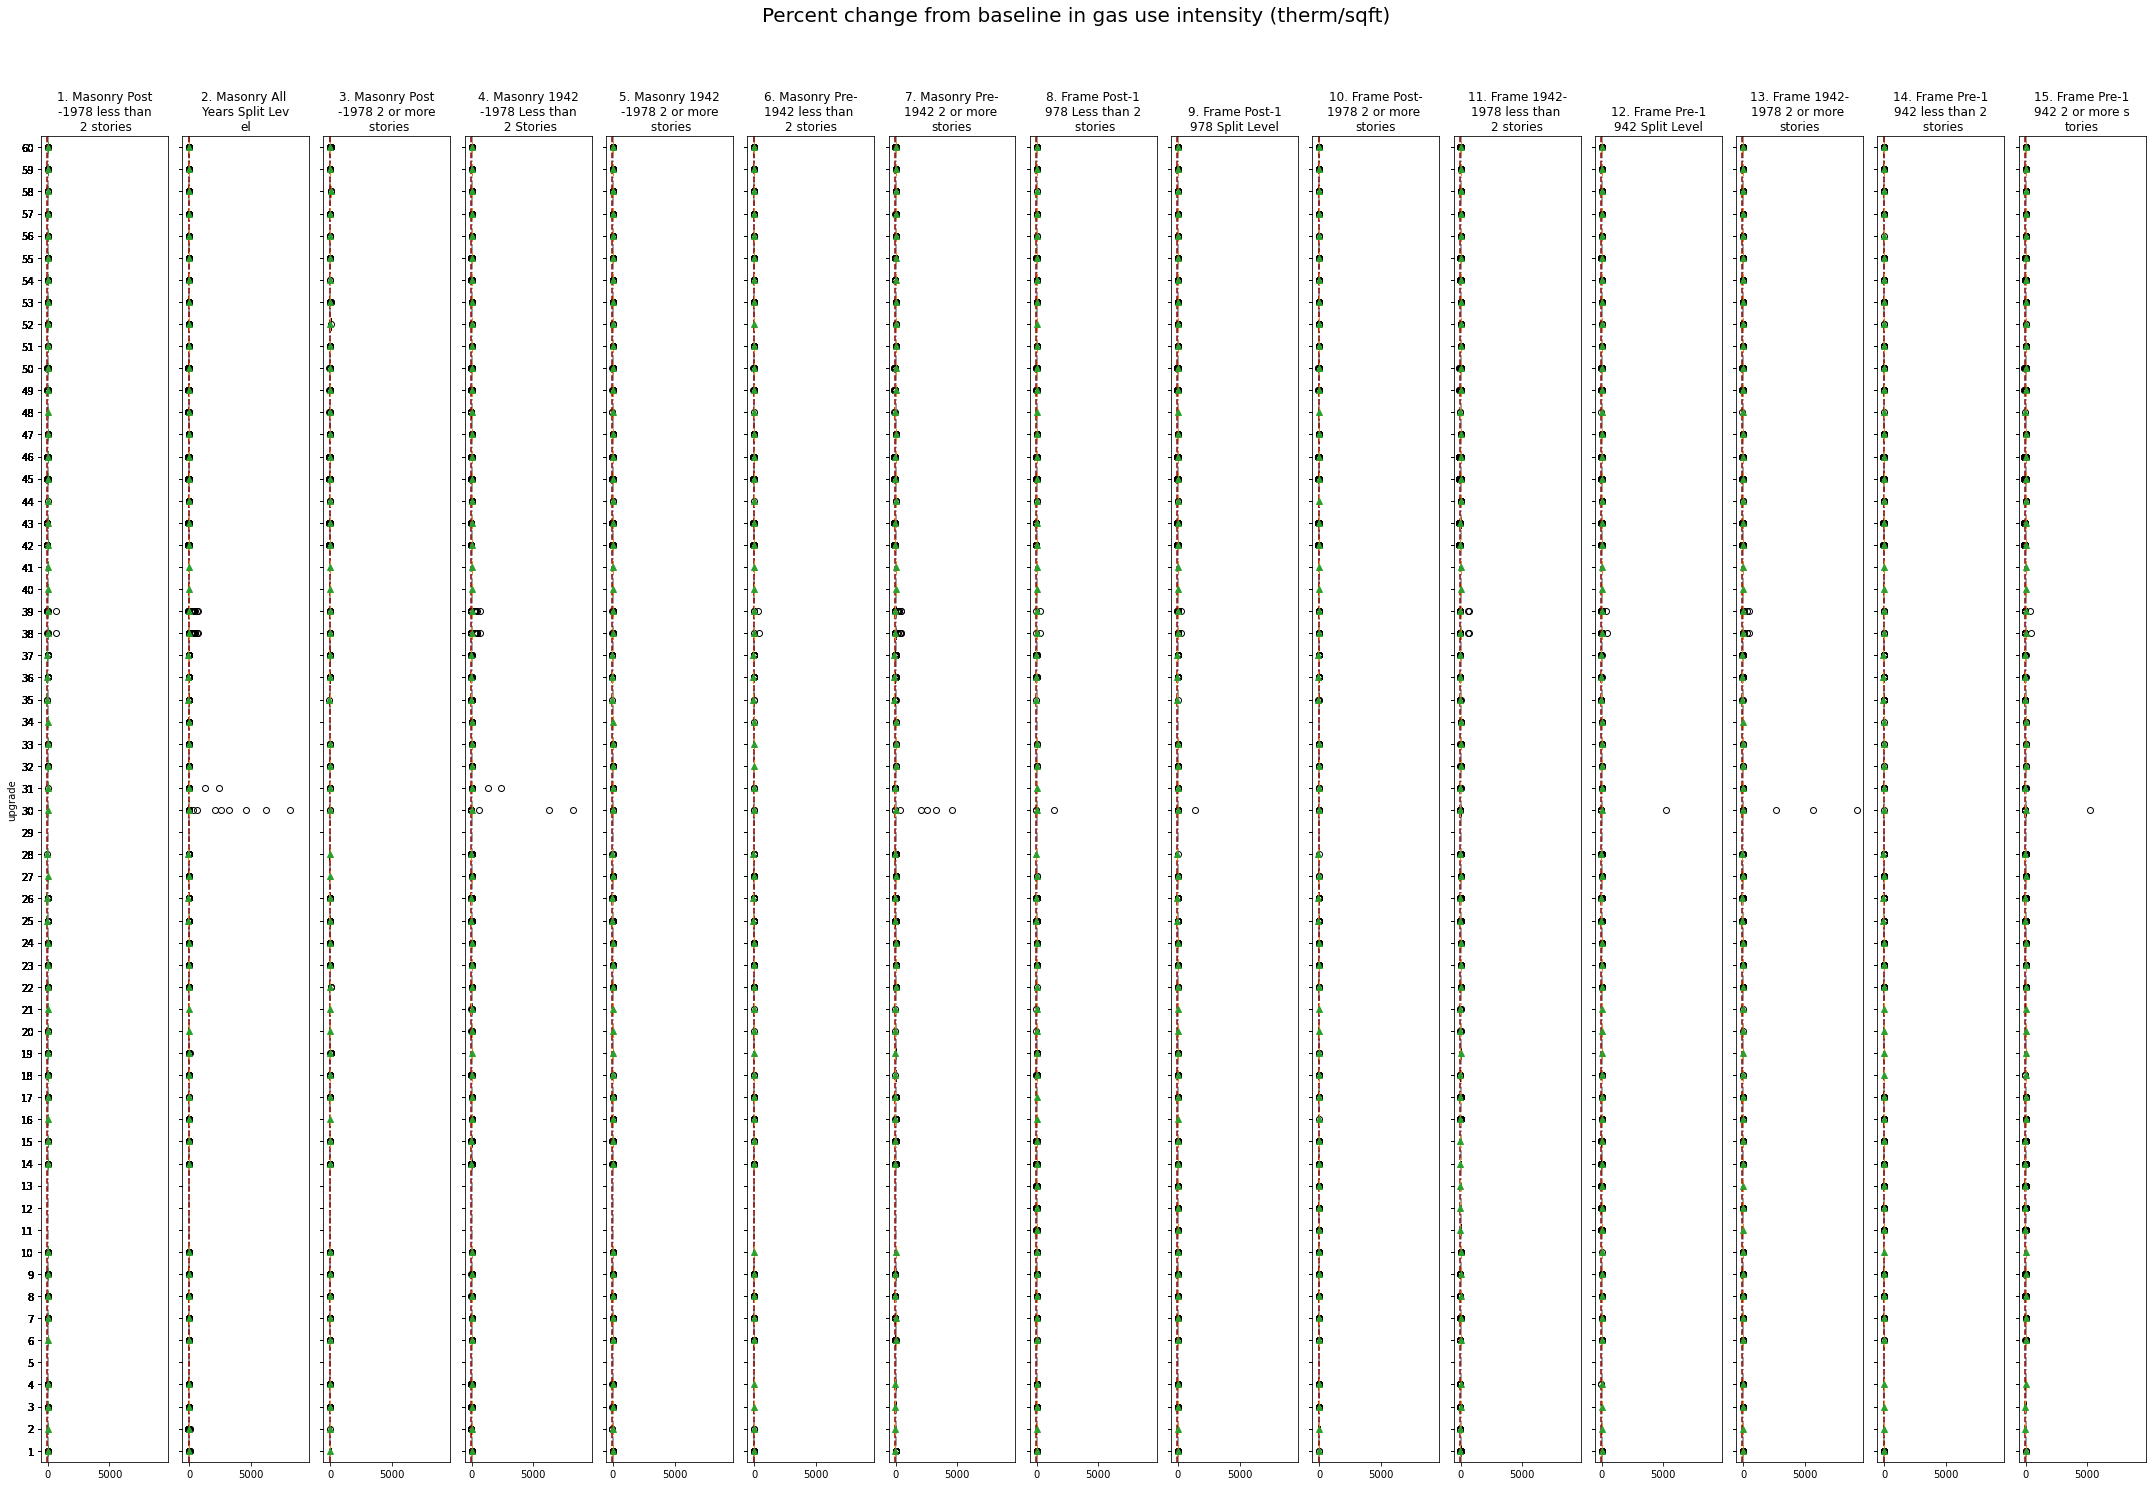

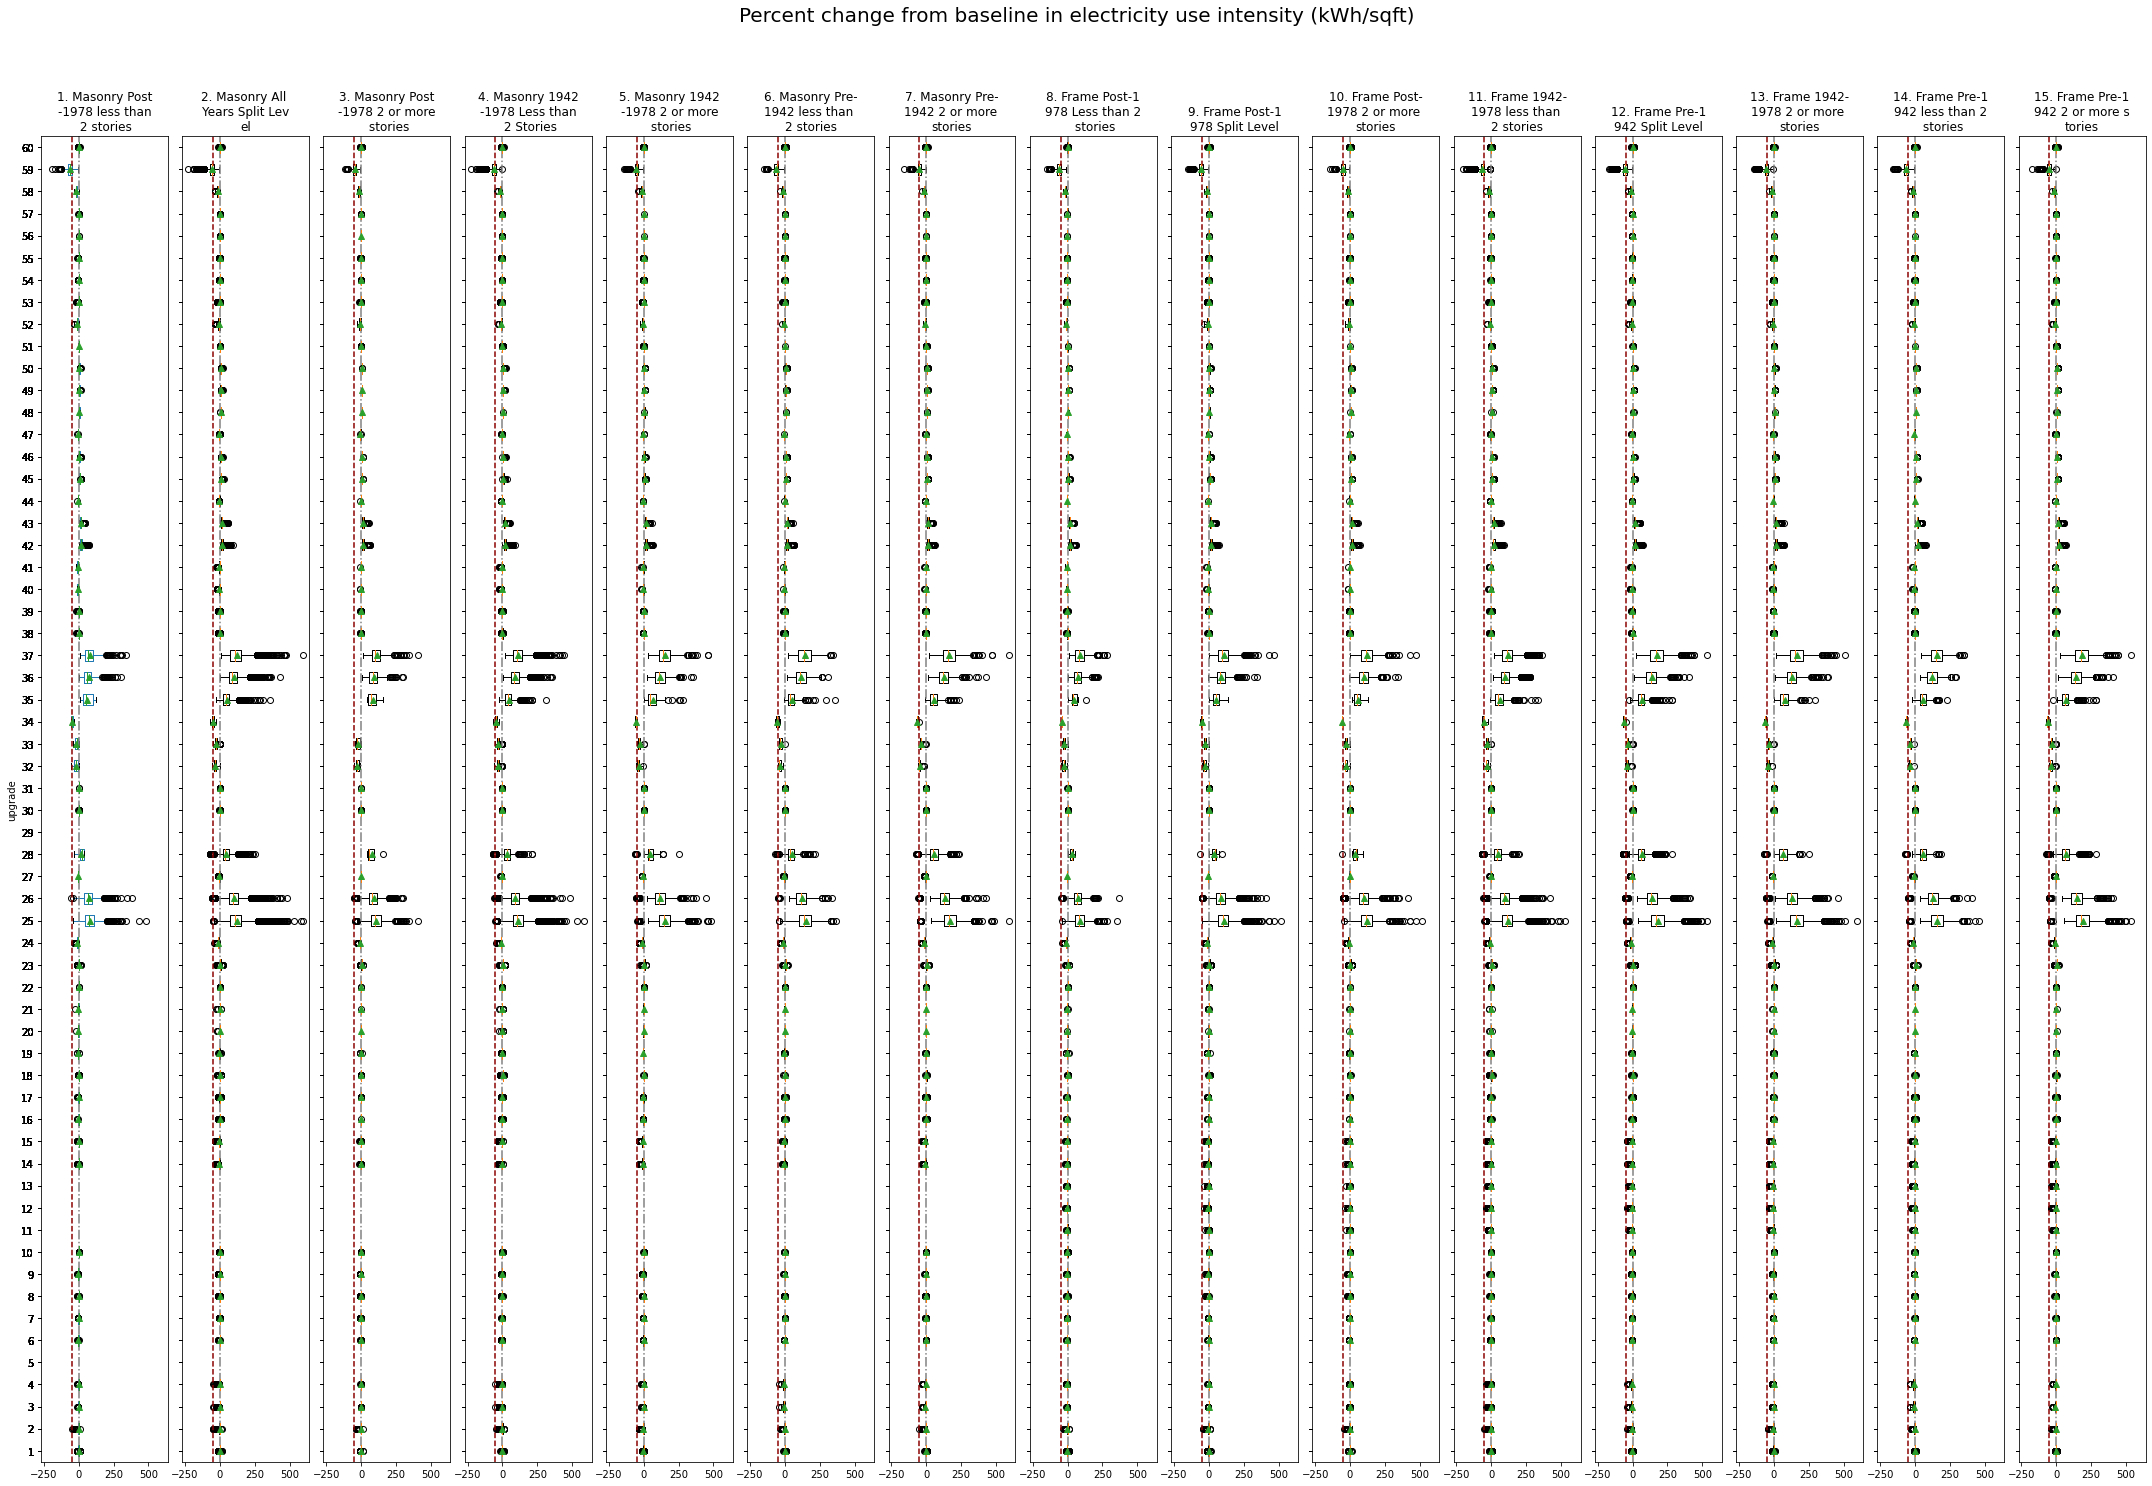

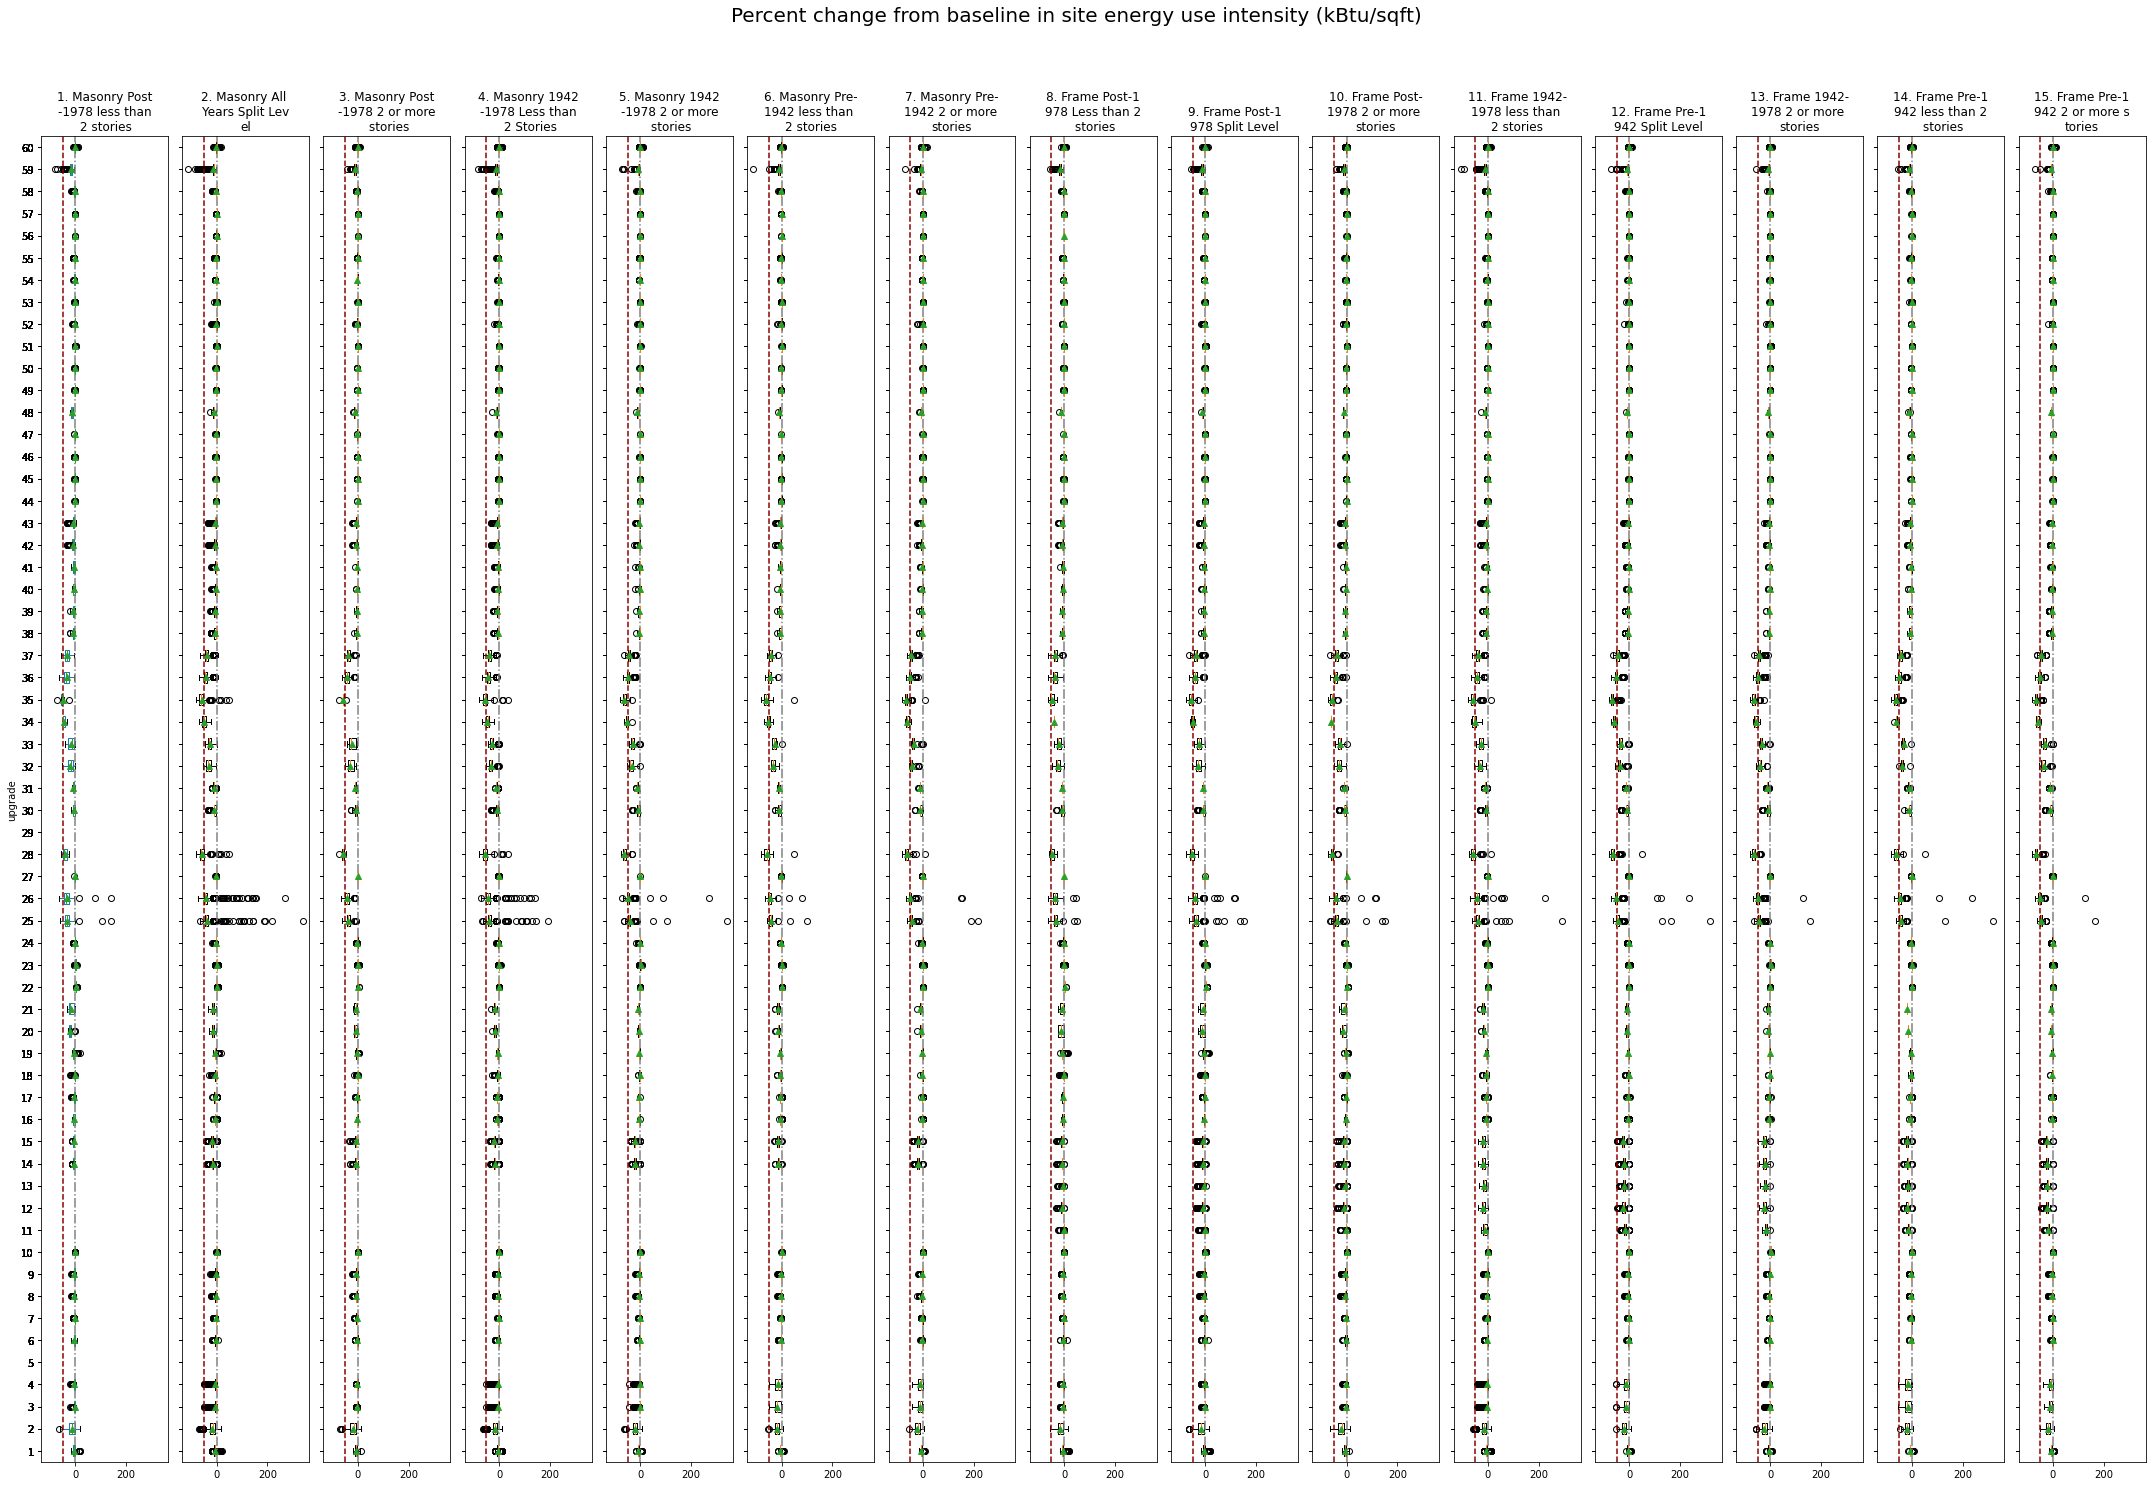

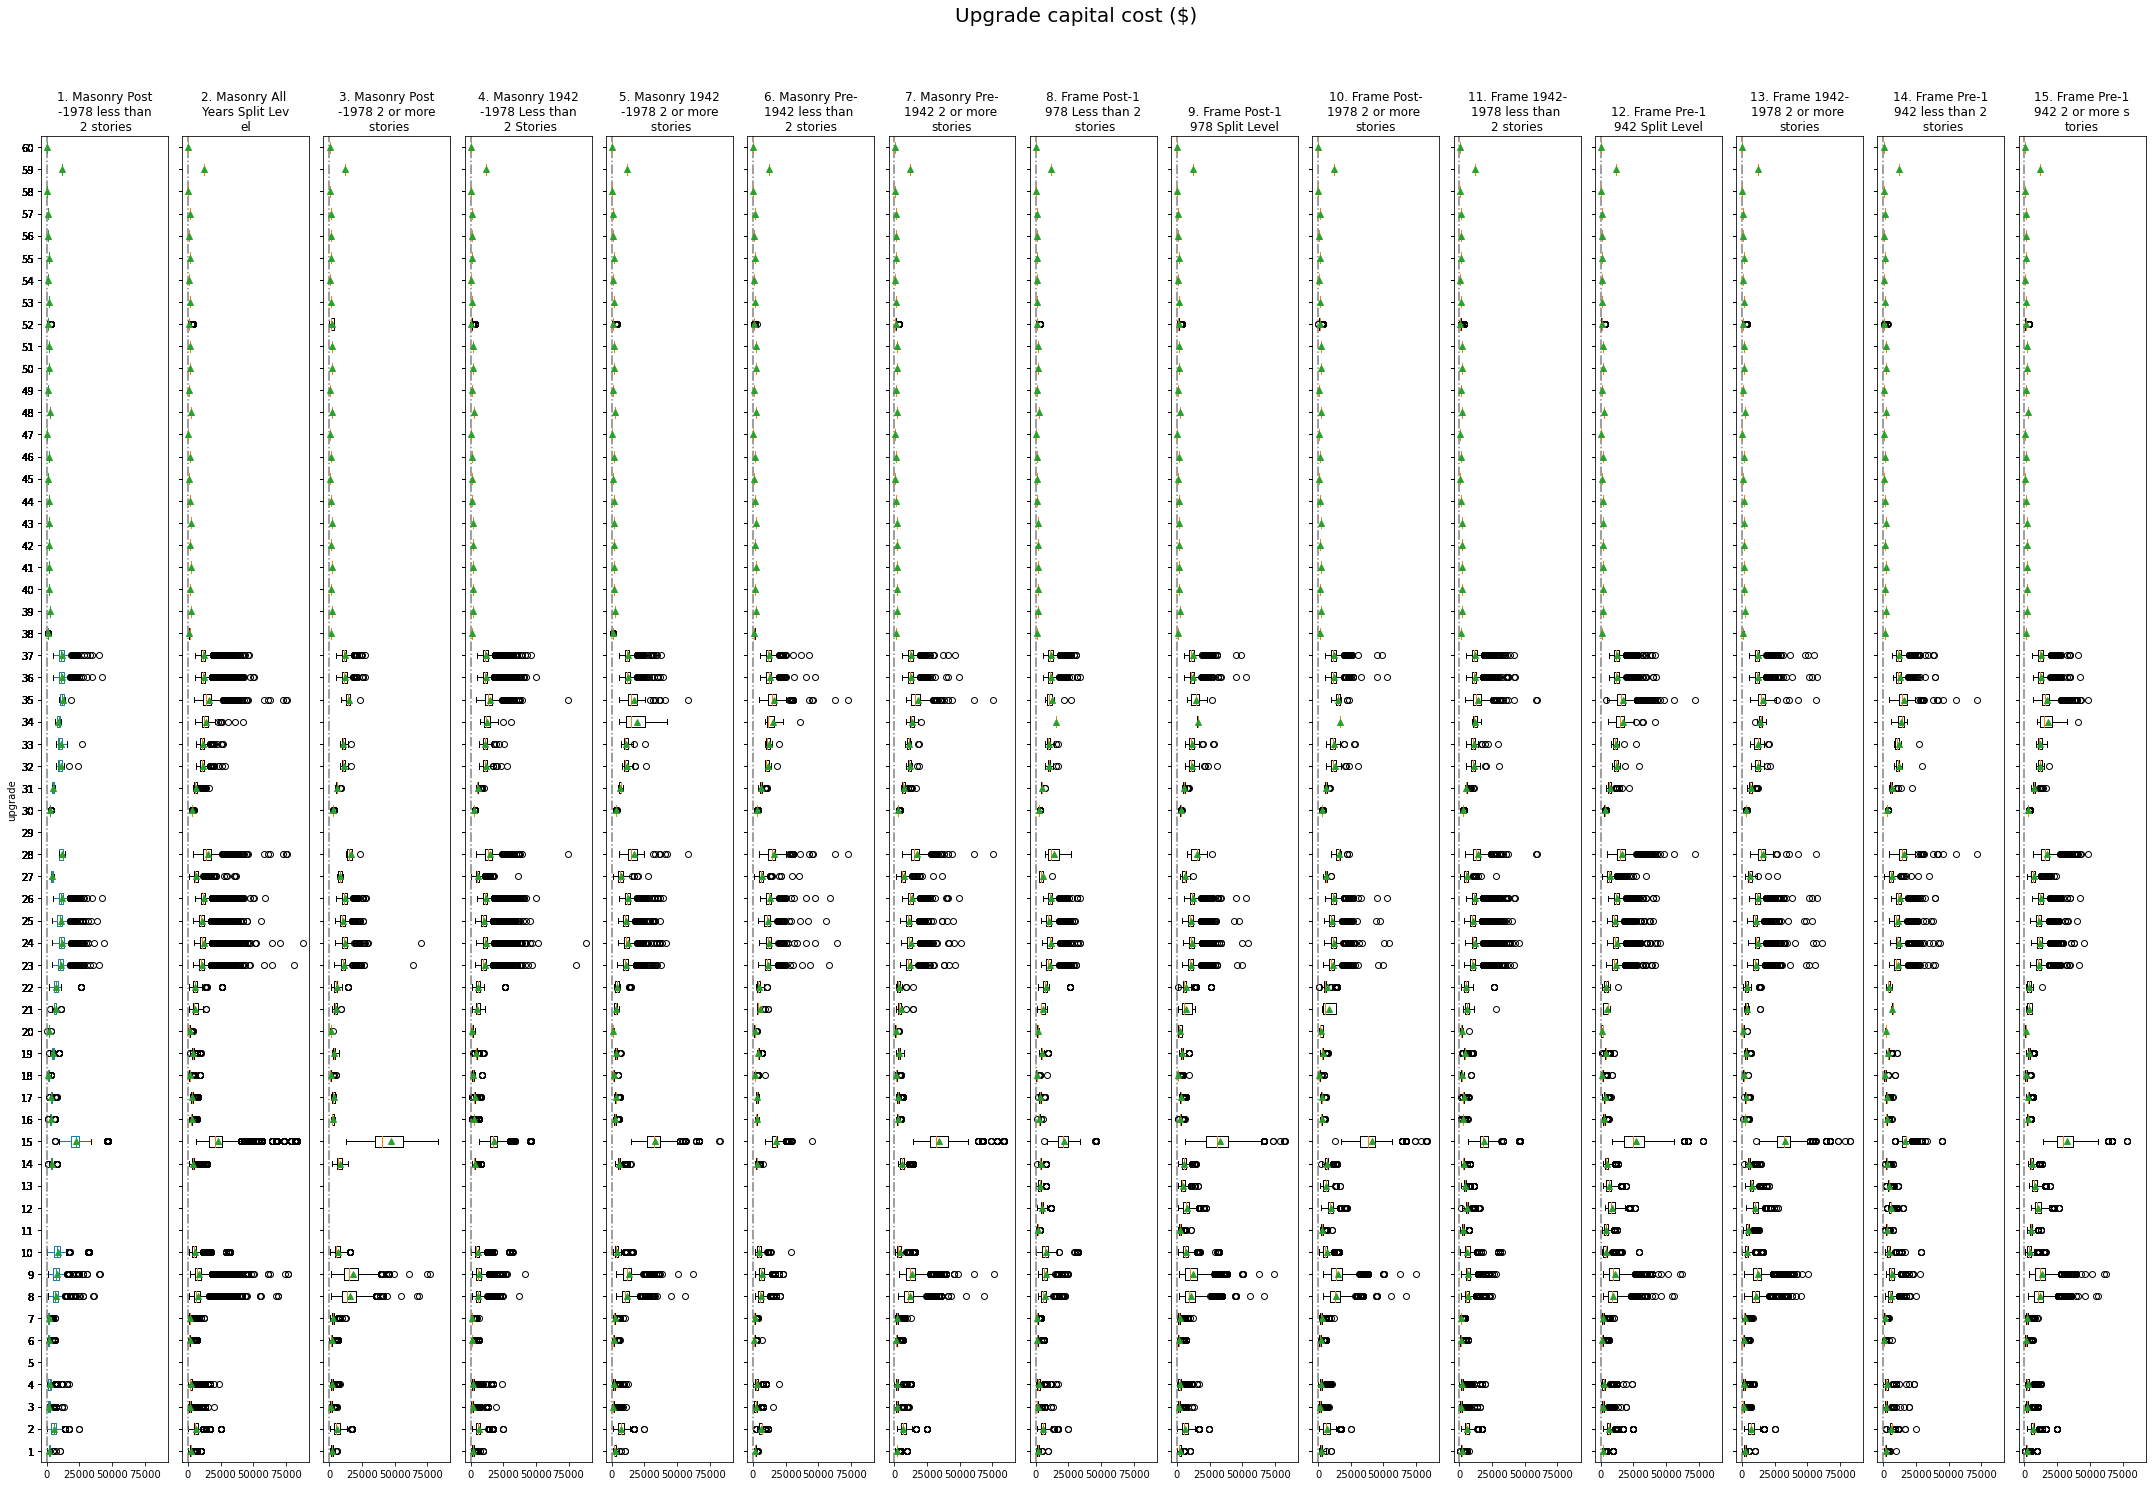

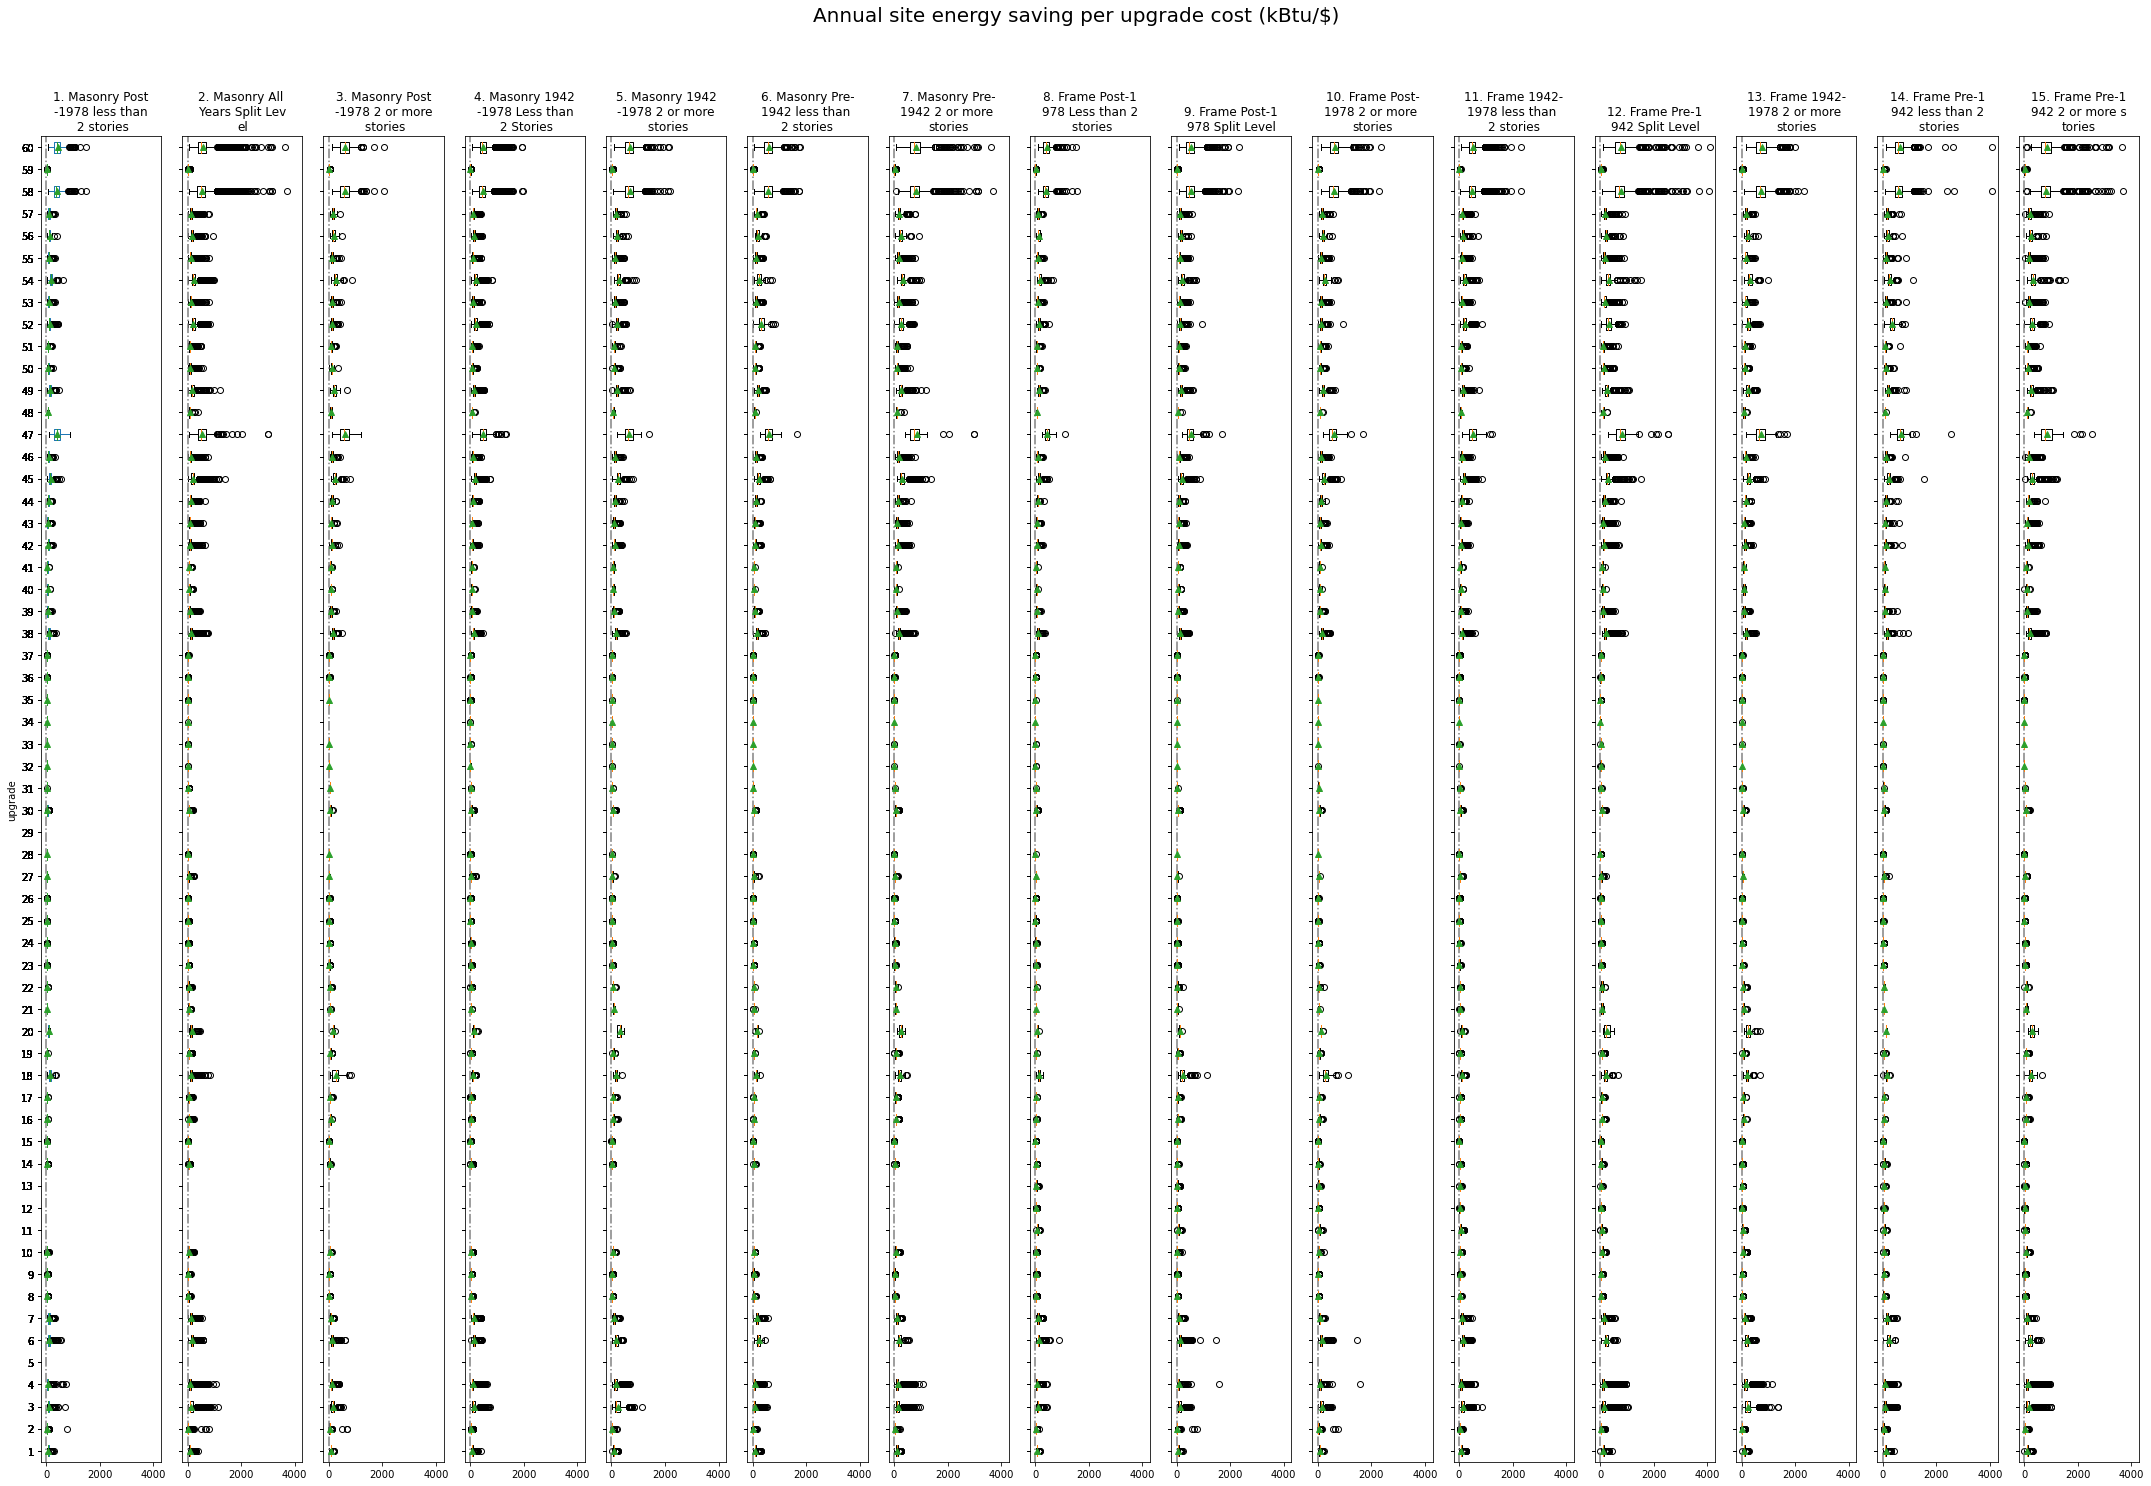

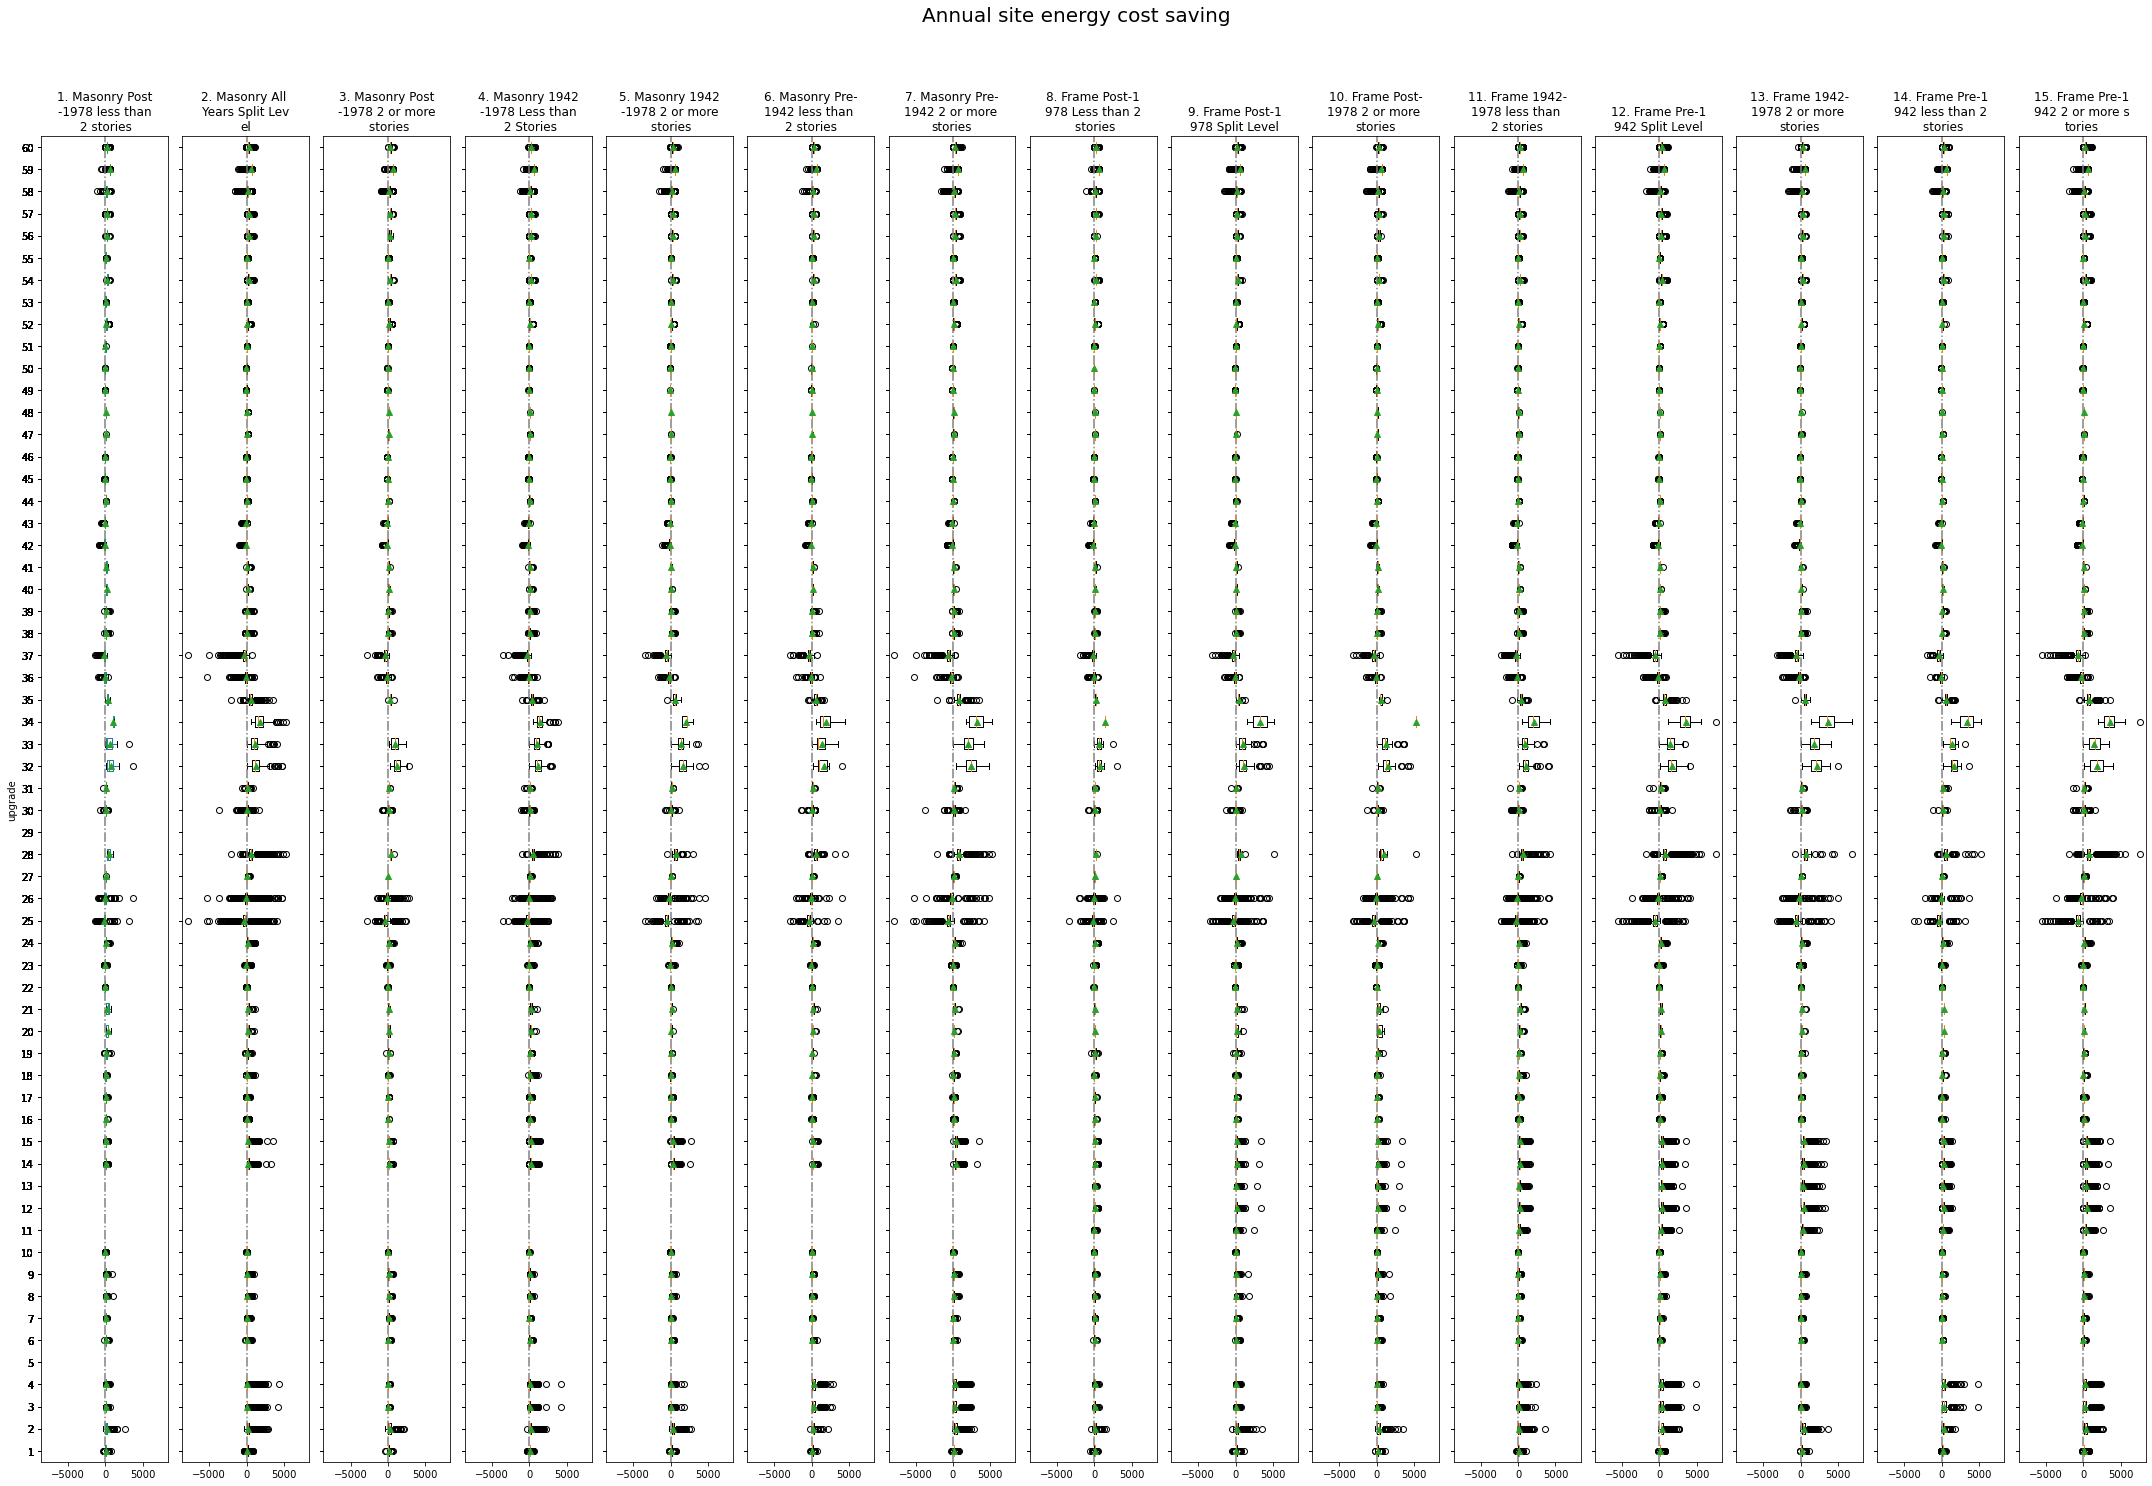

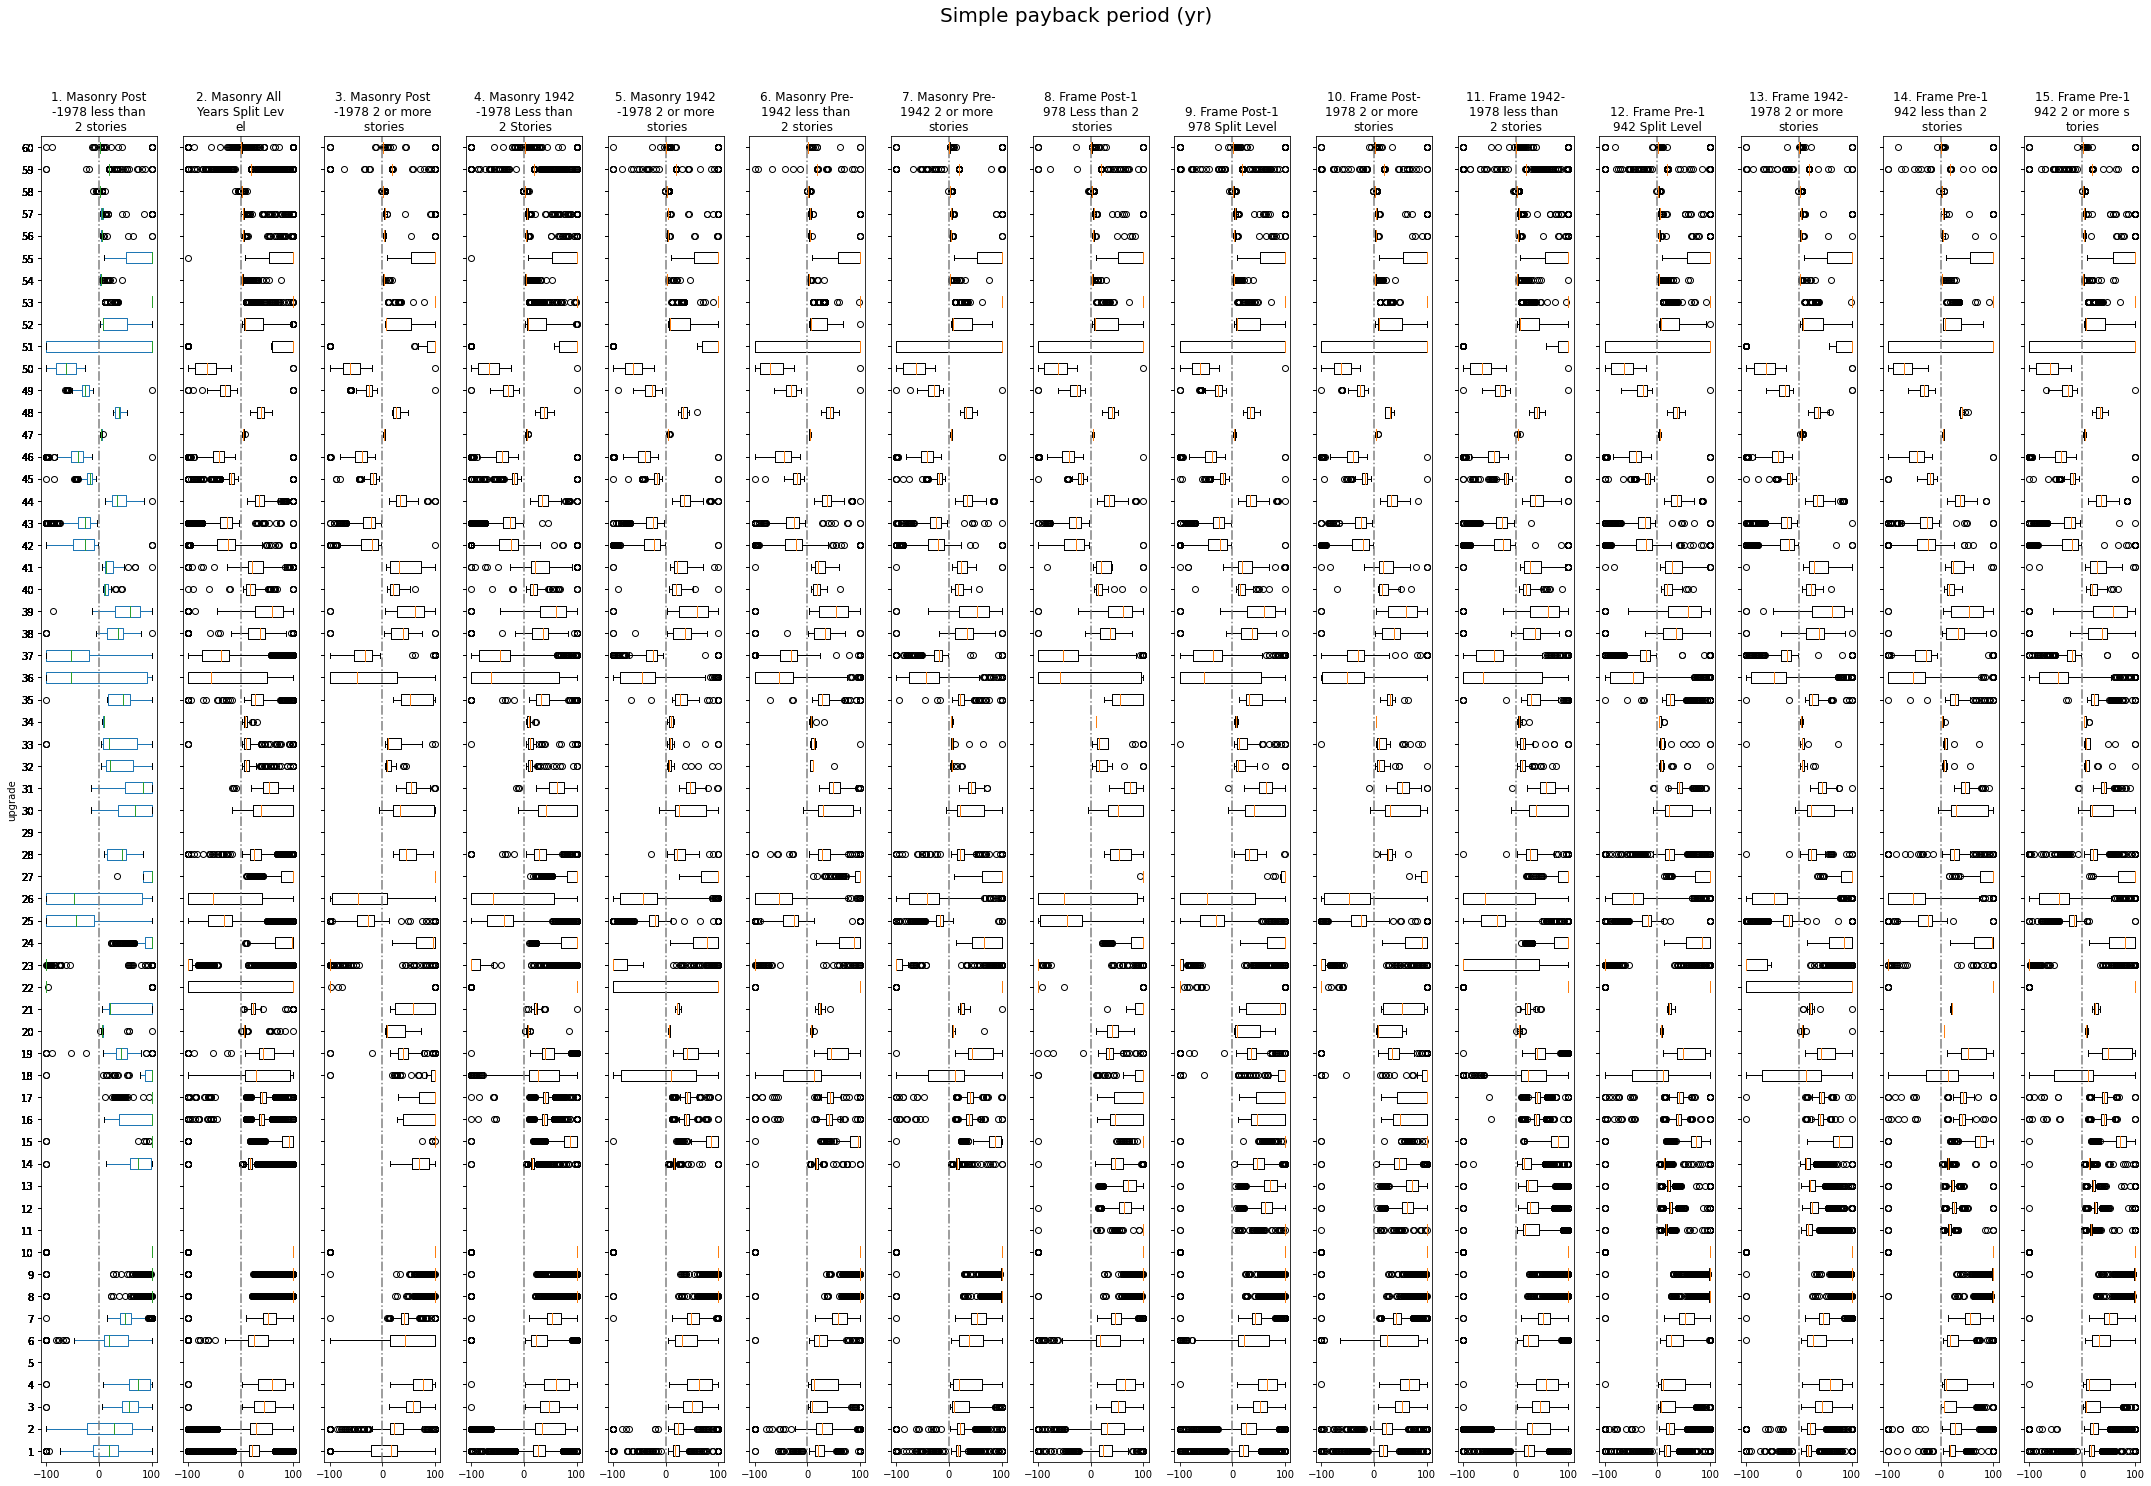

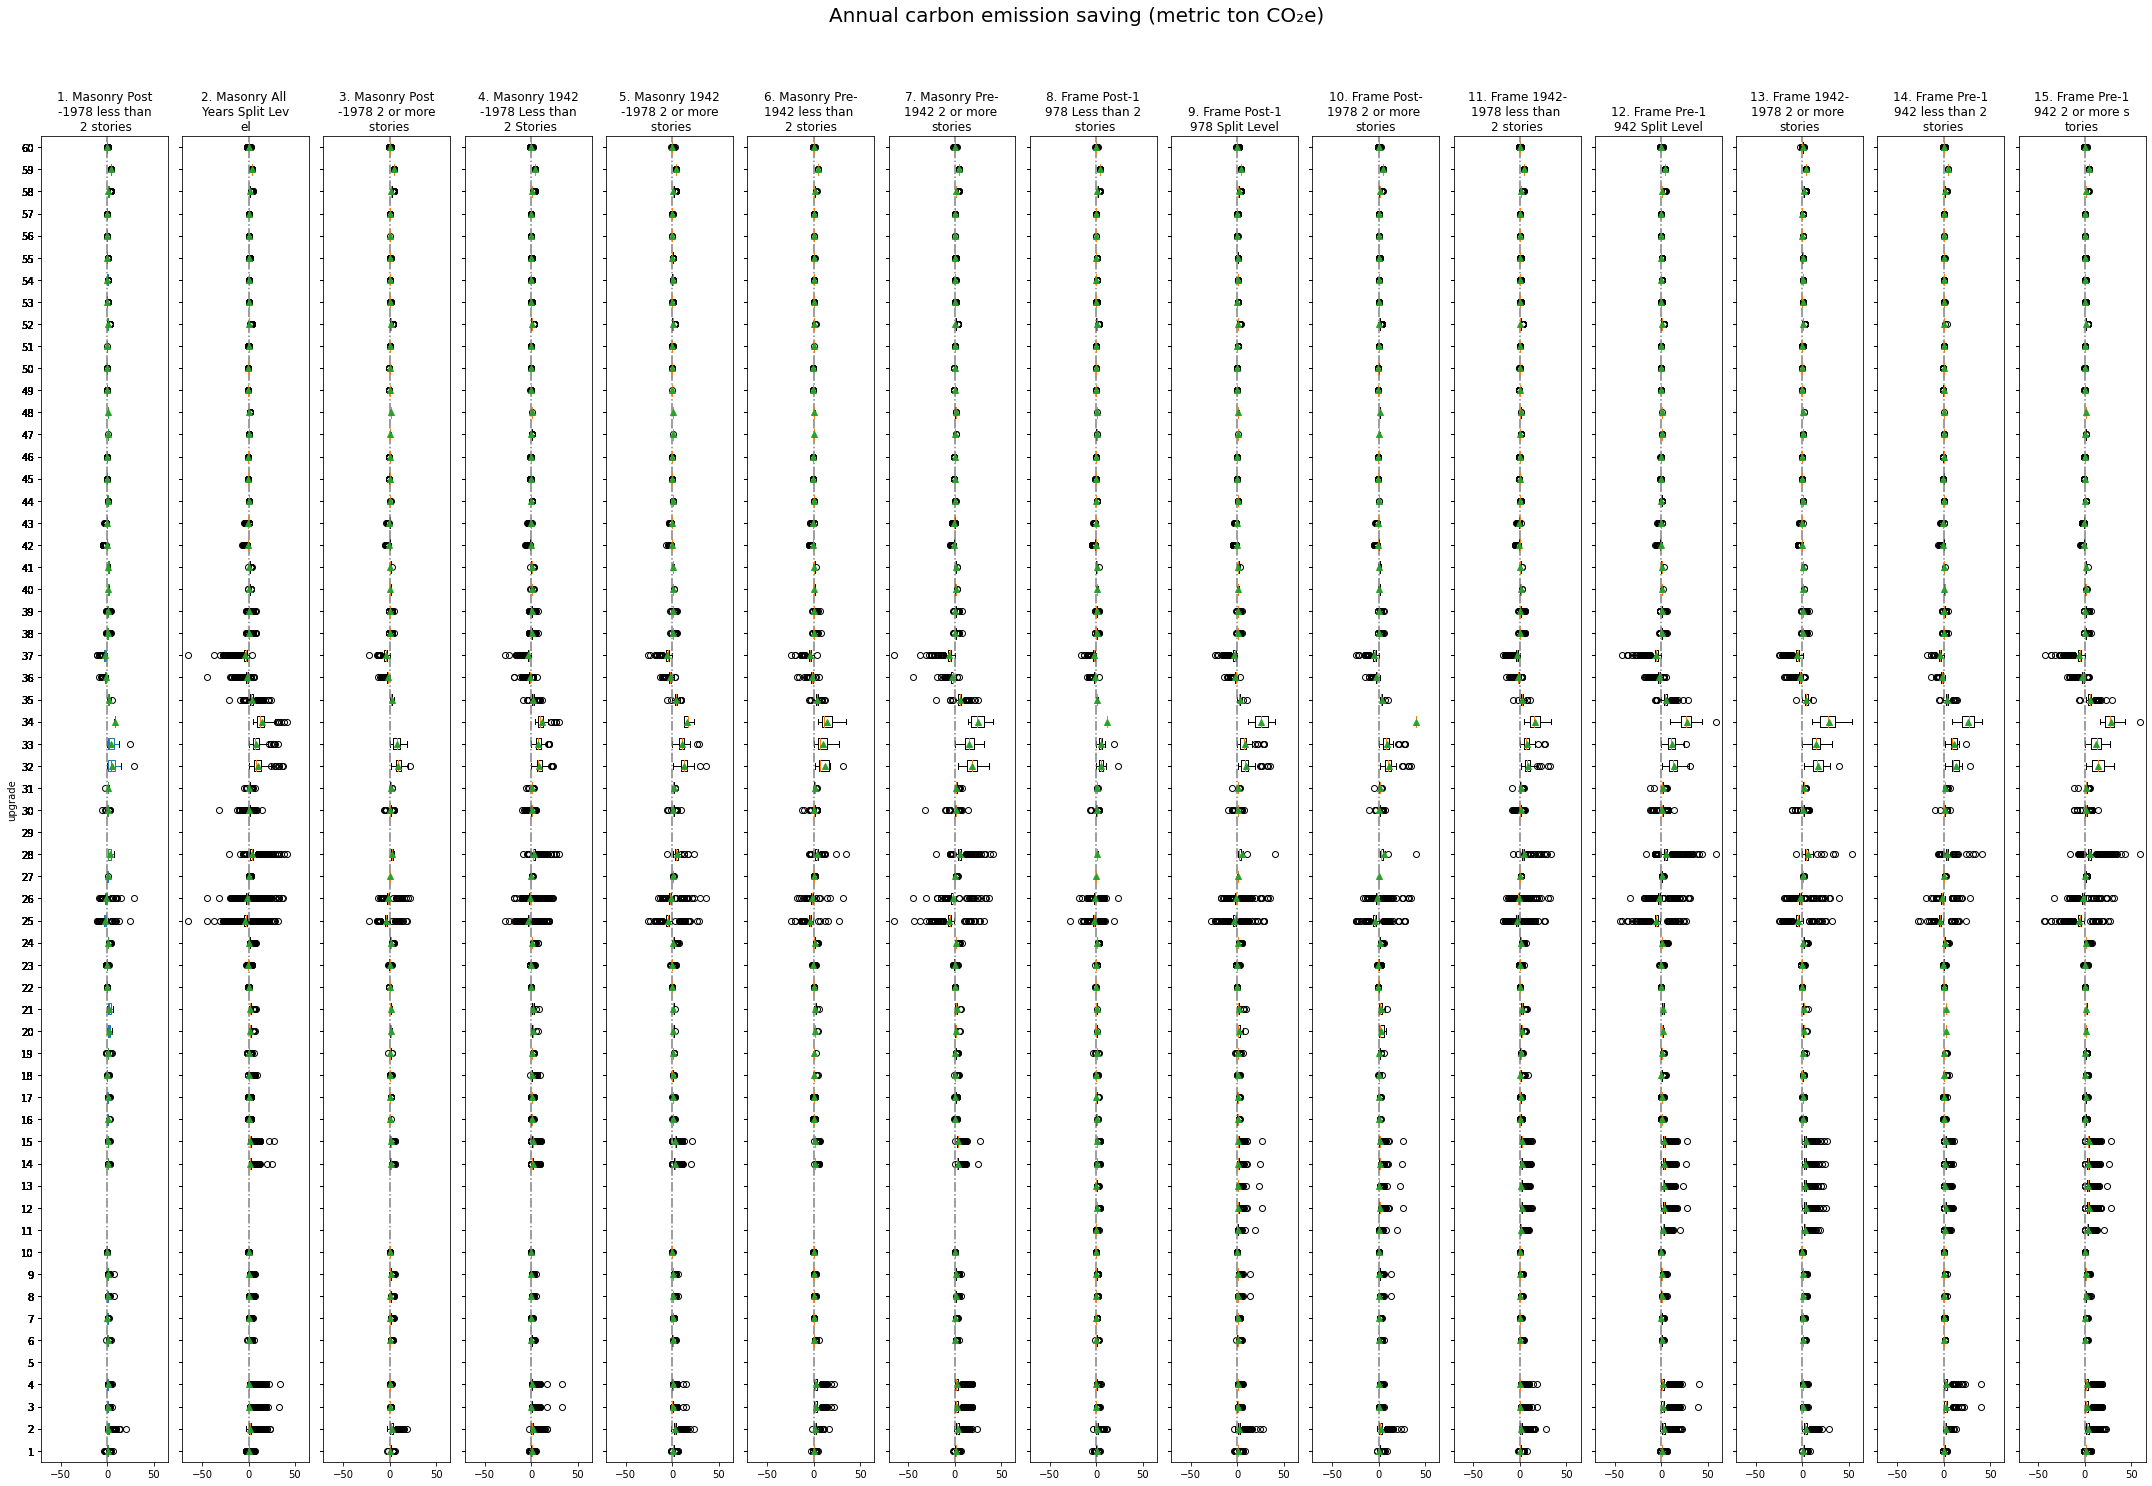

In [176]:
### plot metrics distribution ###

# create subfolder for plots:
plot_path4 = os.path.join(plot_path, 'distribution_by_sfd_prototype')
if not os.path.exists(plot_path4):
    os.mkdir(plot_path4)
print(f'plot dir: {plot_path4}\n')

title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'

## modifying payback periods, cap either ends at [100,-100] 
all_proto_upgrades.loc[(all_proto_upgrades[all_proto_upgrades['simple_payback']>100]).index,
                       'simple_payback'] = 100
all_proto_upgrades.loc[(all_proto_upgrades[all_proto_upgrades['simple_payback']<-100]).index,
                       'simple_payback'] = -100

if NG_rate_multiplier == 1:
    para_labels = {
        'pct_delta_gas_eui': 'Percent change from baseline in gas use intensity (therm/sqft)',
        'pct_delta_elec_eui': 'Percent change from baseline in electricity use intensity (kWh/sqft)',
        'pct_delta_site_eui': 'Percent change from baseline in site energy use intensity (kBtu/sqft)',
        'upgrade_cost': 'Upgrade capital cost ($)',
        'ann_kbtu_saved_per_dollar': 'Annual site energy saving per upgrade cost (kBtu/$)',
        'ann_energy_cost_saving': f'Annual site energy cost saving{title_ext}',
        'simple_payback': f'Simple payback period (yr){title_ext}',
        'ann_metric_ton_co2e_saving': f'Annual carbon emission saving (metric ton CO₂e)',
    }
else:
    para_labels = {
        'ann_energy_cost_saving': f'Annual site energy cost saving{title_ext}',
        'simple_payback': f'Simple payback period (yr){title_ext}',
    }

cols_to_match = list(f'upg{str(i).zfill(2)}' for i in range(1,N_upgrades+1))

for i, para_to_plot in enumerate(para_labels.keys(),1):
    
    print(f'>> {i}. plotting {para_to_plot}{fn_ext}...')
    xmin = all_proto_upgrades[para_to_plot].min(); xmax = all_proto_upgrades[para_to_plot].max()
    
    fig, axes = plt.subplots(ncols=15, nrows=1, sharex=True, sharey=True, figsize=(30, 20))
    for h in range(1,16):
        ax = axes[h-1]
        p = all_proto_upgrades.query('HousingGroupNo==@h')[['HousingGroupNo','HousingGroupName',
                                                            'upgrade_no', para_to_plot]]
        lab = f'{p["HousingGroupNo"].iloc[0]}. {p["HousingGroupName"].iloc[0]}'
        lab = '\n'.join([lab[i:i+15] for i in range(0, len(lab), 15)]) # break up long string
        p.loc[:,'upgrade_no'] = 'upg'+p['upgrade_no'].astype(str).str.zfill(2)
        p = p.sort_values(by='upgrade_no')
        p = p.set_index([p.index, 'upgrade_no'])[
            para_to_plot].unstack(level=-1).dropna(
            axis=0, how='all')

        ### show all upgrades
        for col in set(cols_to_match)-set(p.columns):
            p[col] = np.nan
        p = p.sort_index(axis=1)
        
        if para_to_plot == 'simple_payback':
            showmeans = False
        else:
            showmeans = True
            
        try:
            p.boxplot(ax=ax, vert=False, grid=False, showmeans=showmeans)
        except:
            pass

        ax.set_title(lab)
        if h==1:
            ax.set_ylabel('upgrade')
        ax.axvline(x=0, linestyle='-.', color='gray')
        if (para_to_plot[-3:]=='eui') & (xmin < -50):
            ax.axvline(x=-50, linestyle='--', color='darkred') 
        
    para_label = para_labels[para_to_plot]
    fig.suptitle(para_label, fontsize=20, y=1.03)
    plt.tight_layout()
    
    filename = os.path.join(plot_path4, f'{iter_path}-distribution_{para_to_plot}{fn_ext}.pdf')
    fig.savefig(filename, bbox_inches='tight')


#### 2.3.5. plot mean values for Multi-Family
Run cell below to load df for plots

In [129]:
load_df_for_plot_below_from_file = False # <-----
    
if load_df_for_plot_below_from_file:
    
    NG_rate_multiplier = 1 # 1 or 3 <----- This controls what to plot in '2.3.5.'
    process_2_4_flats_only_for_mf = True # <----- False for all MF

    if process_2_4_flats_only_for_mf:
        mf_prefix = 'mf_2_4_flats_'
    else:
        mf_prefix = 'mf_all_'
 
    if NG_rate_multiplier > 1:
        fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
    else:
        fn_ext = ''
    
    filename = os.path.join(result_path,'processed results', f'{mf_prefix}upgrades_summary{fn_ext}.csv')
    if not os.path.exists(filename):
        print(f'"summary_upgrades_mf{fn_ext}" df does not exist, check if Multi-Family buildings have been modeled.')
    else:
        summary_upgrades_mf = pd.read_csv(filename)
    
        print(f'"summary_upgrades_mf{fn_ext}" df loaded from file.')
        N_upgrades = summary_upgrades_mf['upgrade_no'].nunique()
        print(f'   total number of upgrades: {N_upgrades}')

        display(summary_upgrades_mf)
    


"summary_upgrades_mf" df loaded from file.
   total number of upgrades: 62


upgrade_no                                       upgrade_name  n_applied  \
0          1.0  Air Leakage 25% Reduction, with Mech Vent unde...    20759.0   
1          2.0              Air Leakage to 1ACH50, with Mech Vent    20759.0   
2          3.0                             Attic Insulation, R-49    20759.0   
3          4.0                             Attic Insulation, R-60    20759.0   
4          5.0                                Finished Roof, R-49    20759.0   
..         ...                                                ...        ...   
74        59.0                    EnergyStar Dishwasher, Most Eff    20759.0   
75        60.0                           Plug Loads 25% Reduction    20759.0   
76        61.0                                Rooftop Solar, 4 kW    20759.0   
77         NaN                               Reference Thermostat    20759.0   
78        62.0                                   Smart Thermostat    20759.0   

    n_success  n_fail  pct_success  mean_pct_delta_gas_eui  \
0     20753.0     0.0        100.0                 803.640   
1     20759.0     0.0        100.0                 544.155   
2         0.0     0.0          0.0                     NaN   
3         0.0     0.0          0.0                     NaN   
4     19431.0     0.0         93.6                 905.304   
..        ...     ...          ...                     ...   
74     5919.0     0.0         28.5                 964.910   
75    20759.0     0.0        100.0                 952.103   
76    20759.0     0.0        100.0                 924.224   
77        0.0     0.0          0.0                     NaN   
78    19896.0     0.0         95.8                 901.226   

    mean_pct_delta_elec_eui  mean_pct_delta_site_eui  mean_upgrade_cost  \
0                  1511.405                  659.199           44679.48   
1                  1365.732                  501.840          147210.01   
2                       NaN                      NaN                NaN   
3                       NaN                      NaN                NaN   
4                  1572.936                  721.275                NaN   
..                      ...                      ...                ...   
74                 1625.277                  732.175           45989.66   
75                 1419.220                  713.242           11679.12   
76                 1553.860                  727.163          467164.70   
77                      NaN                      NaN                NaN   
78                 1587.582                  731.750           11615.04   

    mean_ann_kbtu_saved_per_dollar  mean_ann_energy_cost_saving  \
0                        35.878070                      1563.34   
1                         8.873597                      4522.16   
2                              NaN                          NaN   
3                              NaN                          NaN   
4                              NaN                       342.67   
..                             ...                          ...   
74                       37.985923                    -17847.97   
75                      148.055117                       849.68   
76                        3.659710                      -717.17   
77                             NaN                          NaN   
78                      152.604144                          NaN   

    median_simple_payback  median_comparative_payback  \
0               34.094723                         NaN   
1               44.305438                         NaN   
2                     NaN                         NaN   
3                     NaN                         NaN   
4                     NaN                         NaN   
..                    ...                         ...   
74              18.818456                    -2.43397   
75               5.843722                         NaN   
76             172.583935                         NaN   
77                    

plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_02a/processed results/plots/mean_values_mf_2_4_flats_cook_cnty_avg

Plotting Multi-Family per Unit: mean_pct_delta_gas_eui...
    - Group1
                                                    mean_pct_delta_gas_eui
Group1: Fuel-agnostic upgrades                                            
Air Leakage to 1ACH50, with Mech Vent                              -14.192
External SIP                                                         0.192
Drill-and-fill to R-13, R-20 External XPS                            0.351
R-20 External XPS                                                    2.453
Drill-and-fill Insulation for Wood wall and R-5...                   5.531
Drill-and-fill Insulation for Wood Wall                             12.565
Air Leakage 25% Reduction, with Mech Vent under...                  16.421
Insulation Slab, R20                                                16.964
Low-E Double Pane, High-G

    - Group2
                                             mean_pct_delta_site_eui
Group2: Multi-fuel upgrades                                         
Non-ducted Electric to MSHP                                  -70.457
Electric Furnace to Heat Pump, High Eff                      -67.036
Electric Furnace to Heat Pump, Min Eff                       -64.835
Shared Heating to MSHP                                       -63.621
Non-ducted Non-electric to MSHP                              -63.000
Shared Cooling to MSHP                                       -62.834
Room AC to Heat Pump                                         -59.589
SEER 22 ASHP                                                 -57.909
Non-electric Furnace to Heat Pump, High Eff                  -55.884
SEER 15 ASHP                                                 -55.141
Electric Water Heater to 50 gal HPWH                         -53.717
Electric Water Heater to 80 gal HPWH                         -53.316
Non-electric Furnace 

    - Group3
                                     mean_ann_kbtu_saved_per_dollar
Group3: Easy swaps                                                 
Rooftop Solar, 4 kW                                        9.278666
EnergyStar Refrigerator, Most Eff                         83.581692
EnergyStar Clothes Washer, Most Eff                       85.117308
EnergyStar Dishwasher, Most Eff                           97.089166
EnergyStar Dishwasher                                    116.976730
EnergyStar Clothes Washer                                165.377298
LED                                                      281.867948
Plug Loads 50% Reduction                                 385.072689
Smart Thermostat                                         394.613203
Plotting Multi-Family per Unit: mean_ann_energy_cost_saving...
    - Group1
                                                    mean_ann_energy_cost_saving
Group1: Fuel-agnostic upgrades                                                 
Ins

    - Group3
                                     median_simple_payback
Group3: Easy swaps                                        
Smart Thermostat                                  1.976880
Plug Loads 50% Reduction                          2.851980
EnergyStar Clothes Washer                         4.252693
LED                                               6.240627
EnergyStar Dishwasher                             6.825759
EnergyStar Dishwasher, Most Eff                   8.186467
Rooftop Solar, 4 kW                              64.718965
EnergyStar Clothes Washer, Most Eff             110.881164
EnergyStar Refrigerator, Most Eff               211.622538
Plotting Multi-Family per Unit: median_comparative_payback...
    - Group1
                                                    median_comparative_payback
Group1: Fuel-agnostic upgrades                                                
Air Leakage 25% Reduction, with Mech Vent under...                         NaN
Air Leakage to 1ACH50, wit

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


    - Group2
                                             median_comparative_payback
Group2: Multi-fuel upgrades                                            
Non-electric Cooking to Induction                            -41.629476
Non-electric Furnace to Heat Pump, High Eff                  -26.147557
Non-electric Furnace to Heat Pump, Min Eff                   -17.785165
SEER 18 CAC                                                  -17.093708
Non-electric Clothes Dryer to HPCD                           -14.481421
Non-electric Water Heater to 80 gal HPWH                     -11.835416
Non-electric Water Heater to 50 gal HPWH                      -9.859037
SEER 22 ASHP                                                  -8.070669
Electrify Non-electric Cooking                                -3.621526
SEER 15 ASHP                                                  -1.400570
Electrify Non-electric Clothes Dryer                           5.136171
Room AC to Heat Pump                               

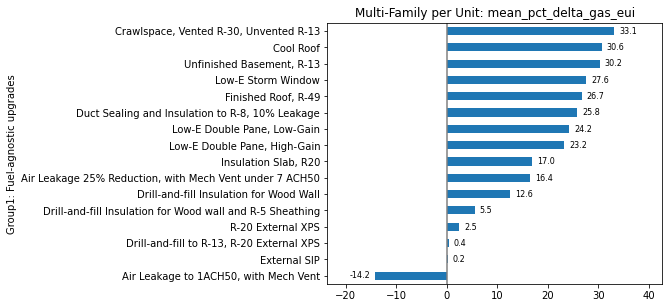

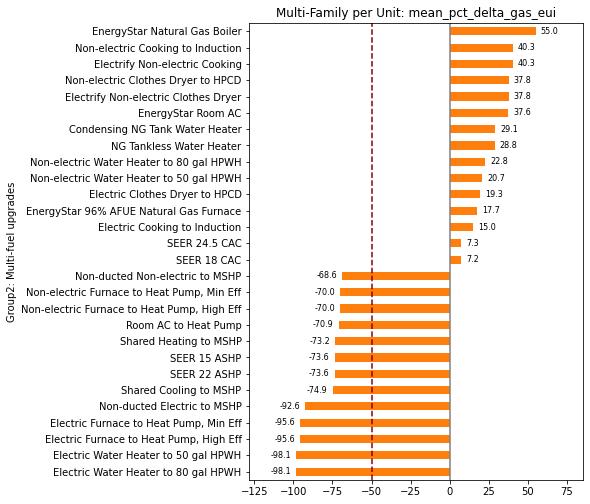

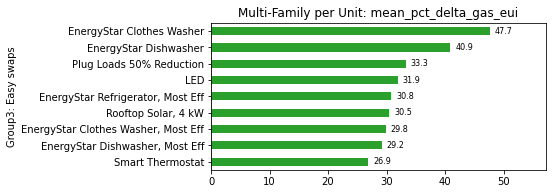

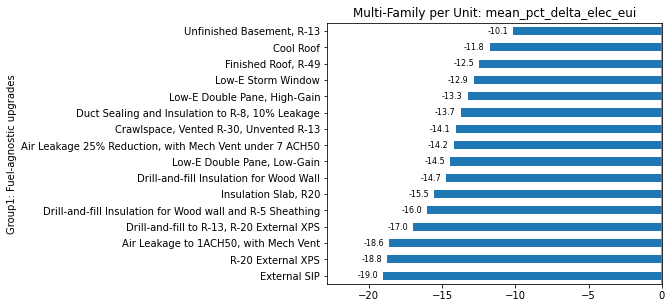

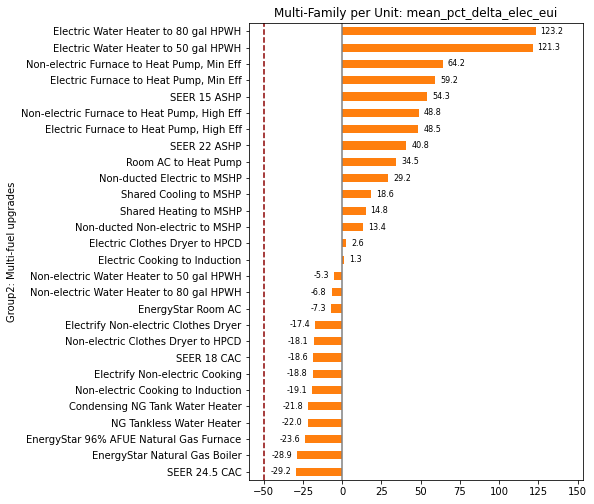

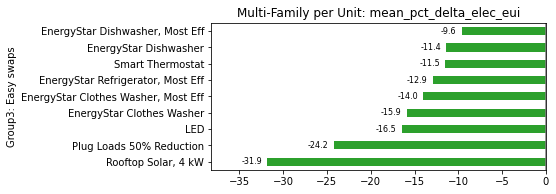

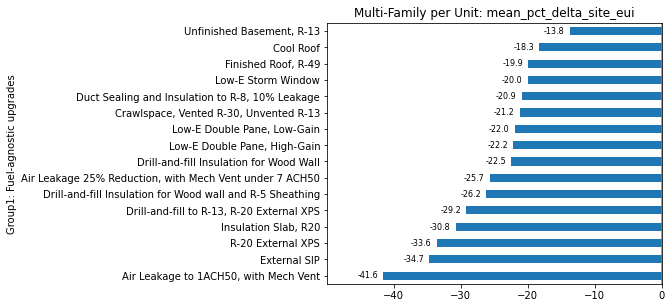

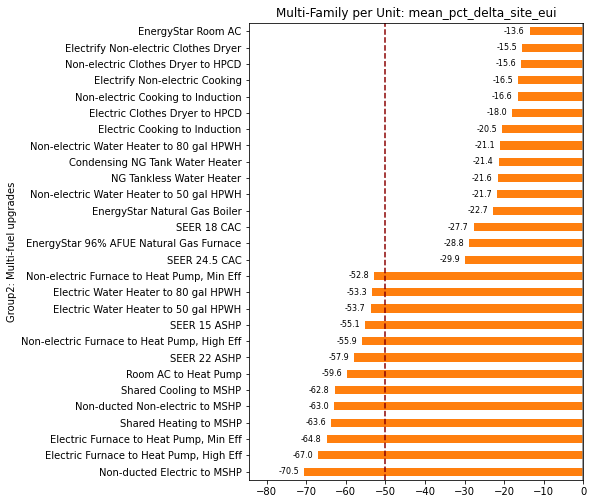

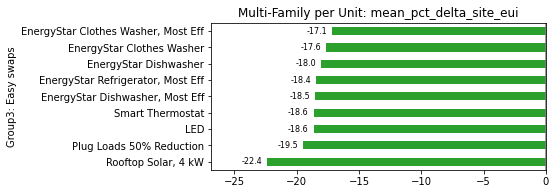

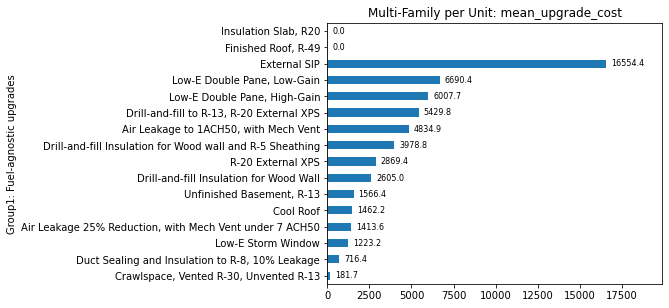

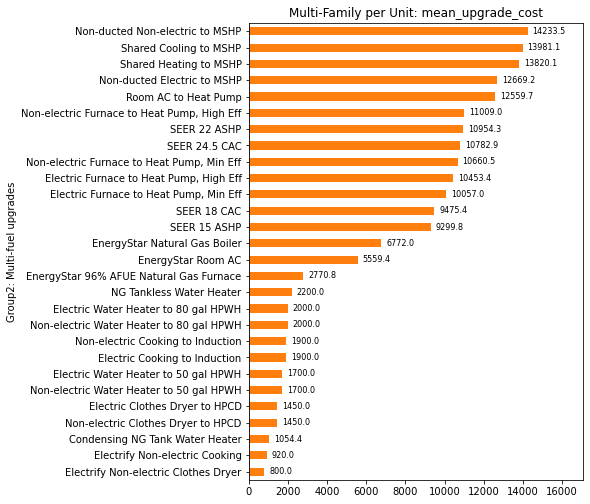

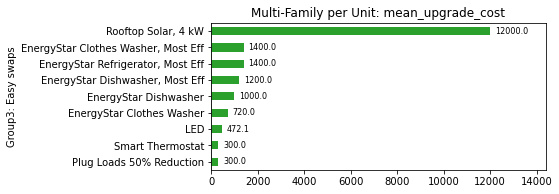

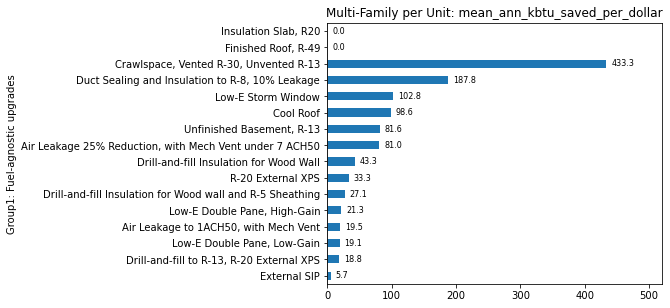

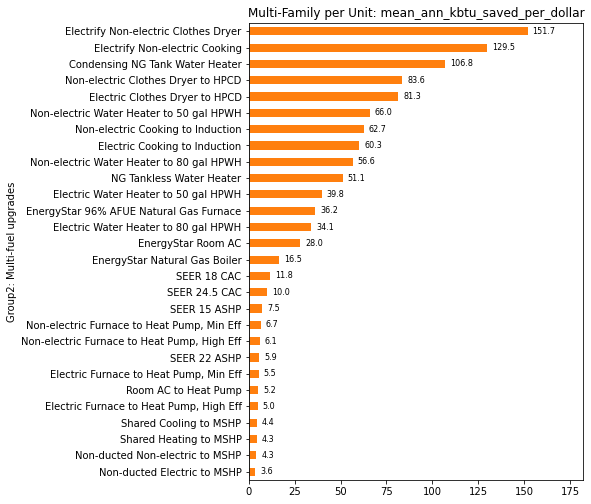

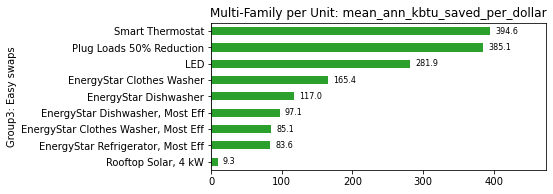

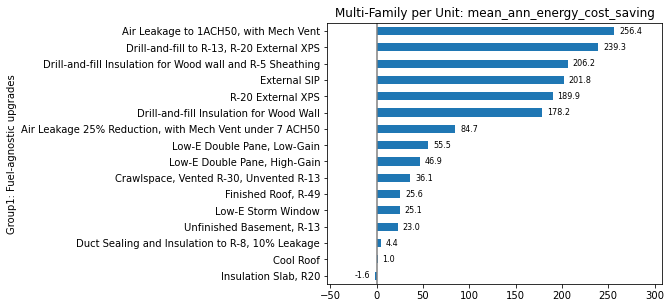

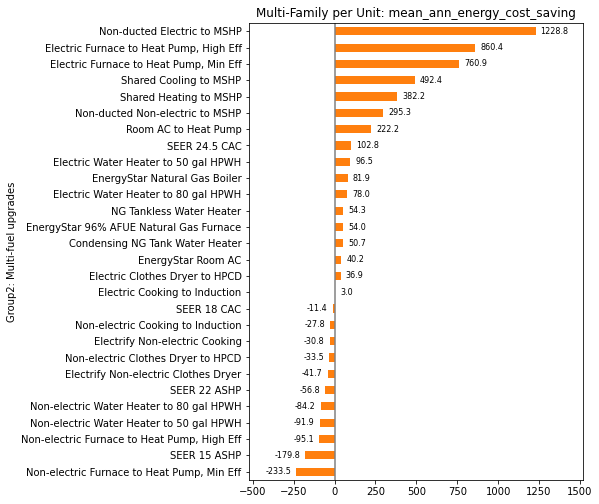

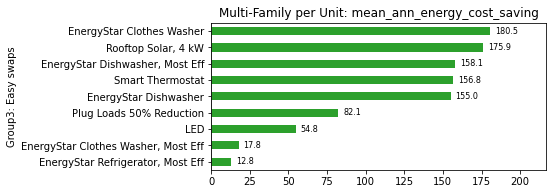

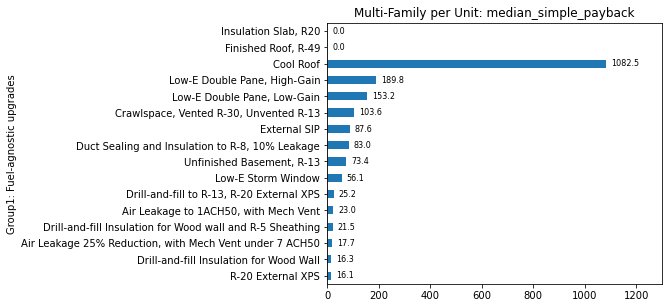

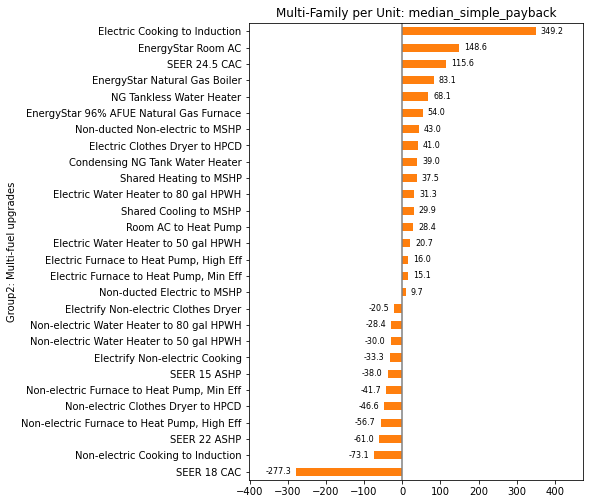

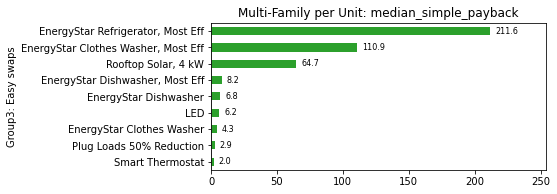

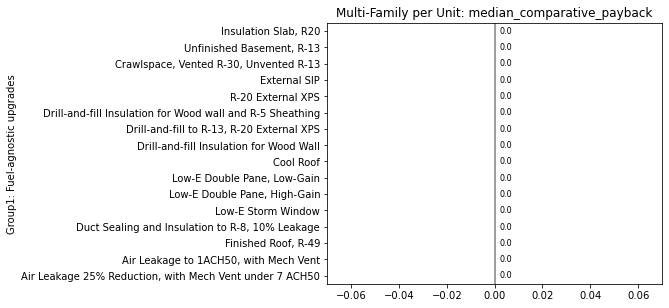

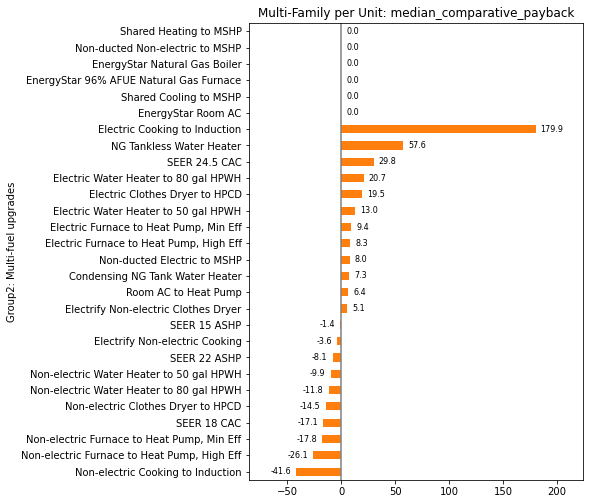

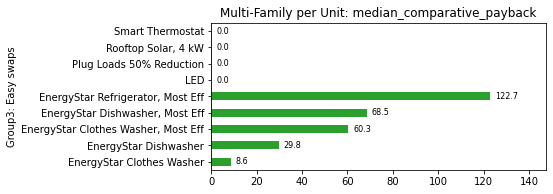

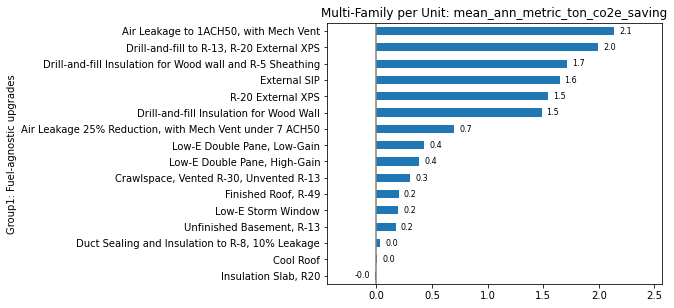

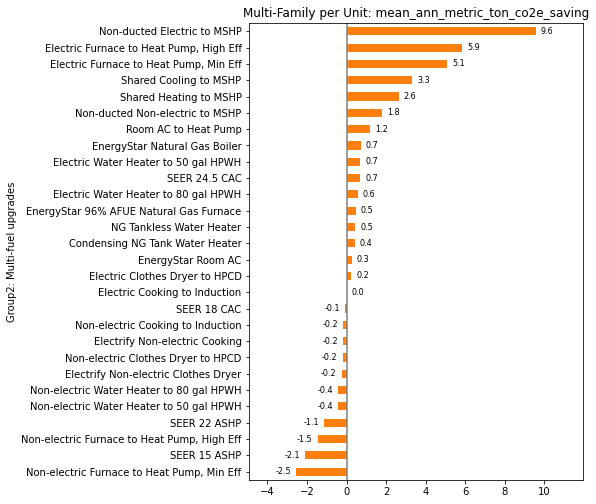

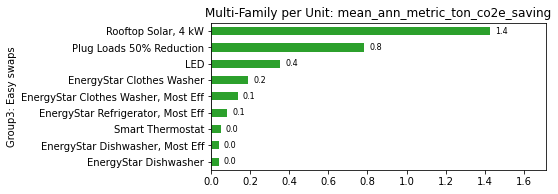

In [182]:
### plot MF (or MF 2-4 flats) Cook County Avg ###

summary_upgrades_mf = summary_upgrades_mf[summary_upgrades_mf['n_success']>0].reset_index(
    drop=True)

upgrade_sets = {
    'Group1: Fuel-agnostic upgrades': range(1, 23),
    'Group2: Multi-fuel upgrades': range(23, 53),
    'Group3: Easy swaps': range(53, 62),
}
upgrade_set_colors = {
    'Group1: Fuel-agnostic upgrades': 'tab:blue',
    'Group2: Multi-fuel upgrades': 'tab:orange',
    'Group3: Easy swaps': 'tab:green',
}

# create subfolder for plots:
if process_2_4_flats_only_for_mf:
    mf_folder_ext = '_mf_2_4_flats_cook_cnty_avg'
else:
    mf_folder_ext = '_mf_cook_cnty_avg'
        
plot_path5 = os.path.join(plot_path, f'mean_values{mf_folder_ext}')
if not os.path.exists(plot_path5):
    os.mkdir(plot_path5)
print(f'plot dir: {plot_path5}\n')

if NG_rate_multiplier == 1: 
    metrics_to_plot = list(x for x in summary_upgrades_mf.columns if 
                           x.startswith('mean') or x.startswith('median'))
else:
    metrics_to_plot = ['mean_ann_energy_cost_saving', 'median_simple_payback', 'median_comparative_payback']
    
for metric in metrics_to_plot:
    title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'
    title = f'Multi-Family per Unit: {metric}{title_ext}'
    print(f'Plotting {title}...')
    
    for n, up in enumerate(upgrade_sets.keys(),1):
        print(f'    - Group{n}')
        
        groupi = summary_upgrades_mf.loc[
            summary_upgrades_mf['upgrade_no'].isin(upgrade_sets[up]),
            ['upgrade_name', metric]
                                        ].set_index(
            ['upgrade_name'])
        if metric == 'median_comparative_payback':
            groupi = groupi.replace(0,np.nan).sort_values(by = metric) # make 0 nan
        else:
            groupi = groupi.sort_values(by = metric)
        groupi.index.name = up
        
        ht = len(groupi)
        fig, ax = plt.subplots(figsize=(6, 0.3*ht))
        groupi.plot.barh(color=upgrade_set_colors[up], legend=False, title=title, ax=ax)
        
        # For each bar: Place a label ############################
        rects = ax.patches
        for rect in rects:
            # Get X and Y placement of label from rect.
            x_value = rect.get_width()
            y_value = rect.get_y() + rect.get_height() / 2

            # Number of points between bar and label. Change to your liking.
            space = 5
            # Vertical alignment for positive values
            ha = 'left'

            # If value of bar is negative: Place label left of bar
            if x_value < 0:
                # Invert space to place label to the left
                space *= -1
                # Horizontally align label at right
                ha = 'right'

            # Use X value as label and format number with one decimal place
            label = "{:.1f}".format(x_value)

            # Create annotation
            plt.annotate(
                label,                      # Use `label` as label
                (x_value, y_value),         # Place label at end of the bar
                xytext=(space, 0),          # Horizontally shift label by `space`
                textcoords="offset points", # Interpret `xytext` as offset in points
                va='center',                # Vertically center label
                ha=ha,                      # Horizontally align label differently for
                fontsize=8)                 # positive and negative values. 
            
        ax.margins(x=0.2)    
        ax.axvline(x=0, linestyle='-', color='gray')
        if (metric[-3:]=='eui') & (ax.get_xlim()[0] < -50):
            ax.axvline(x=-50, linestyle='--', color='darkred')
        
        filename = f'MF-upgrades_{iteration}_{metric[5:]}_group{n}{fn_ext}.pdf'
        fig.savefig(os.path.join(plot_path5, filename),
                    bbox_inches='tight')
        